Загрузим исчпользуемые библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from typing import List, Optional
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
import statsmodels.api as sm
from tqdm import tqdm
import lightgbm as lgb
import catboost as cb
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
import sklearn as sk
from sklearn.metrics import roc_auc_score, f1_score,r2_score,classification_report,accuracy_score,precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
%matplotlib inline

Названия основных файлов

In [3]:
TRAIN = 'course_project_train.csv'
TEST = 'course_project_test.csv'
Train_working="Train_working.csv"
Test_working ='Test_working.csv'
PREDICT = 'VErshov_predictions.csv'
Train_work = 'Train_work.pkl'
Test_work = 'Test_work.pkl'
MODEL = 'model.pkl'
train_work={}
test_work={}

Ниже определим используемые собственные классы и функции

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
def drop_target(df,target='Credit Default'):
    return df.drop(target,axis = 1)

In [6]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [7]:
class quick_catboost_binary:
    import catboost as cb
    from sklearn.metrics import f1_score
    from sklearn.model_selection import train_test_split  
    from sklearn.metrics import  f1_score
    best_split = 0.5
    params = {
    "n_estimators": 1000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": False,
    "max_depth": 6,
    "l2_leaf_reg": 20,
    "early_stopping_rounds": 90,
    "thread_count": -1,
    "random_seed": 42,
    'custom_metric':  ['AUC', 'Logloss','F1','Accuracy']
    }
    res=None
    model = cb.CatBoostClassifier(**params)
    
    def transform_object(self,X):
        self.object_features = X.select_dtypes(exclude=[np.number]).columns
        X[self.object_features]=X[self.object_features].astype(str)
        return X
    
    def acc(self,pred, y_true):
        y_hat = np.where(pred < self.best_split, 0, 1)
        return  (y_true==y_hat).sum()/len(y_true)   

    def cross_validation(self,n,size):
            data=[]
            r = np.arange(n)
            for i in range(size-1):
                ind = np.random.choice(r,size=int(n/size), replace=False)
                data.append(ind)
                r=np.setdiff1d(r,ind) 
            data.append(r)
            return data
        
    def get_best_split(self,pred,y_test):
        d = {}
        for i in np.arange(0.05,0.96,0.05):
            z = np.where(pred < i, 0, 1)
            d[i] = f1_score(y_test,z)
        return sorted(d, key=d.get, reverse=True)[0]
    
    def precision(self,pred, y_true):
        y_hat = np.where(pred < self.best_split, 0, 1)      
        return sum(y_true[y_hat==y_true])/sum(y_hat)
    
    def recall(self,pred, y_true):
        y_hat = np.where(pred < self.best_split, 0, 1)
        return sum(y_true[y_hat==y_true])/sum(y_true)
        
        
    def positiv_class(self,y_true):
        return sum( y_true==1)/len(y_true)
        
    
    def test_cros(self,X,y,params=params,size=5,print_res =True):
            X=self.transform_object(X)
            cros_val = self.cross_validation(X.shape[0],size)
            result={}
            result['f1_test']=[]
            result['f1_train']=[]
            result['auc_test']=[]
            result['accuracy_test']=[]
            result['accuracy_train']=[]
            result['precision_train']=[]
            result['precision_test']=[]
            result['recall_train']=[]
            result['recall_test']=[]
            result['positiv_train']=[]
            result['positiv_test']=[]
            result['best_split']=[]
            
            for i in range(len(cros_val)):
                ind_train = np.hstack((cros_val[:i]+cros_val[i+1:]))
                ind_test = cros_val[i]
                
                train_pool = cb.Pool(X.iloc[ind_train], y[ind_train],\
                                     text_features = self.object_features.to_list())
                valid_pool = cb.Pool(X.iloc[ind_test],y[ind_test],\
                                     text_features = self.object_features.to_list())

                self.res = self.model.fit(train_pool, eval_set=valid_pool,plot=False)
                    
                
                
                result['f1_test'].append(self.res.get_best_score()['validation']['F1'])
                result['f1_train'].append(self.res.get_best_score()['learn']['F1'])
                result['auc_test'].append(self.res.get_best_score()['validation']['AUC'])
                result['accuracy_test'].append(self.res.get_best_score()['validation']['Accuracy'])
                result['accuracy_train'].append(self.res.get_best_score()['learn']['Accuracy'])
                
                pred = self.res.predict_proba(X.iloc[ind_test])[:,1]
                y_true = y[ind_test]
                self.best_split = self.get_best_split(pred,y_true)   
                result['best_split'].append(self.best_split) 
                
                
                result['positiv_test'].append(self.positiv_class(y_true))         
                result['precision_test'].append(self.precision(pred,y_true))
                result['recall_test'].append(self.recall(pred,y_true))
                
                
                pred = self.res.predict_proba(X.iloc[ind_train])[:,1]
                y_true = y[ind_train]
                  
                result['positiv_train'].append(self.positiv_class(y_true))                
                result['precision_train'].append(self.precision(pred,y_true))
                result['recall_train'].append(self.recall(pred,y_true))

                if print_res:
                    print(f'Выборка номер {i} имеет следующие параметры:')
                    for j in result:
                        print(f'Показатель {j} равен {result[j][i]}')
            for i in result:
                result[i].append(sum(result[i])/len(result[i]))  
                print(f'Среднее значение показателя {i} равно {result[i][-1]}')     
            return result   

In [8]:
class quick_lgb_binary:
    import lightgbm as lgb 
    from sklearn.metrics import f1_score
    from sklearn.model_selection import train_test_split
    model = lgb
    best_split = 0.5
    params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "n_jobs": -1,
    "seed": 27}
    res=None
    
    def transform_object(self,X):
        object_features = X.select_dtypes(include=[np.object]).columns
        X[object_features]=X[object_features].astype('category')
        return X
    def acc(self,pred, y_true):
        y_hat = np.where(pred < self.best_split, 0, 1)
        return  (y_true==y_hat).sum()/len(y_true)   

    def lgb_f1_score(self,y_hat, data):
        y_true = data.get_label()
        self.best_split = self.get_best_split(y_hat,y_true)
        y_hat = np.where(y_hat < self.best_split, 0, 1)
        return 'f1', f1_score(y_true, y_hat), True

    def cross_validation(self,n,size):
            data=[]
            r = np.arange(n)
            for i in range(size-1):
                ind = np.random.choice(r,size=int(n/size), replace=False)
                data.append(ind)
                r=np.setdiff1d(r,ind) 
            data.append(r)
            return data
        
    def get_best_split(self,pred,y_test):
        d = {}
        for i in np.arange(0.05,0.96,0.05):
            z = np.where(pred < i, 0, 1) 
            d[i] = f1_score(y_test,z)
        return sorted(d, key=d.get, reverse=True)[0]
    
    def precision(self,pred, y_true):
        y_hat = np.where(pred < self.best_split, 0, 1)      
        return sum(y_true[y_hat==y_true])/sum(y_hat)
    
    def recall(self,pred, y_true):
        y_hat = np.where(pred < self.best_split, 0, 1)
        return sum(y_true[y_hat==y_true])/sum(y_true)
        
        
    def positiv_class(self,y_true):
        return sum( y_true==1)/len(y_true)
        
    
    def test_cros(self,X,y,params=params,size=5,print_res =True):
            X=self.transform_object(X)
            cros_val = self.cross_validation(X.shape[0],size)
            result={}
            result['f1_test']=[]
            result['f1_train']=[]
            result['auc_train']=[]
            result['auc_test']=[]
            result['accuracy_test']=[]
            result['accuracy_train']=[]
            result['precision_train']=[]
            result['precision_test']=[]
            result['recall_train']=[]
            result['recall_test']=[]
            result['positiv_train']=[]
            result['positiv_test']=[]
            result['best_split']=[]
            
            for i in range(len(cros_val)):
                ind_train = np.hstack((cros_val[:i]+cros_val[i+1:]))
                ind_test = cros_val[i]
                dtrain = lgb.Dataset(data=X.iloc[ind_train], \
                                     label=y[ind_train],free_raw_data=False)
                dvalid = lgb.Dataset(data=X.iloc[ind_test],\
                                     label=y[ind_test],free_raw_data=False)

                self.res = self.model.train(
                    params=params,
                    train_set=dtrain,
                    num_boost_round=10000,
                    valid_sets=[dtrain, dvalid],
                    valid_names=['train', 'test'], 
                    feval=self.lgb_f1_score,
                    categorical_feature='auto',
                    verbose_eval=500,
                    early_stopping_rounds=95)
                
                
                result['f1_test'].append(self.res.best_score['test']['f1'])
                result['f1_train'].append(self.res.best_score['train']['f1'])
                result['auc_train'].append(self.res.best_score['train']['auc'])
                result['auc_test'].append(self.res.best_score['test']['auc'])
                
                pred = self.res.predict(X.iloc[ind_test])
                y_true = y[ind_test]
                self.best_split = self.get_best_split(pred,y_true)   
                result['best_split'].append(self.best_split) 
                
                
                result['positiv_test'].append(self.positiv_class(y_true))
                result['accuracy_test'].append(self.acc(pred,y_true))
                result['precision_test'].append(self.precision(pred,y_true))
                result['recall_test'].append(self.recall(pred,y_true))
                
                
                pred = self.res.predict(X.iloc[ind_train])
                y_true = y[ind_train]
                  
                result['positiv_train'].append(self.positiv_class(y_true))
                result['accuracy_train'].append(self.acc(pred,y_true))
                result['precision_train'].append(self.precision(pred,y_true))
                result['recall_train'].append(self.recall(pred,y_true))

                if print_res:
                    print(f'Выборка номер {i} имеет следующие параметры:')
                    for j in result:
                        print(f'Показатель {j} равен {result[j][i]}')
            for i in result:
                result[i].append(sum(result[i])/len(result[i]))  
                print(f'Среднее значение показателя {i} равно {result[i][-1]}')     
            return result           

In [9]:
def miss_forecast(data,target,obj):
    df = data.copy()
    df[obj]=df[obj].astype('category')
    x_data_test = df[df[target].isna()].drop([target],axis = 1)
    x_data_train = df[~df[target].isna()].drop([target],axis = 1)
    x_data_target = df[~df[target].isna()][target]
    ind = x_data_test.index
    model= lgb.LGBMClassifier( n_estimators = 1000)
    model.fit(x_data_train,x_data_target)
    return model,ind, model.predict(x_data_test)

In [10]:
def miss_forecast_reg(data,target,obj):
    df = data.copy()
    df[obj]=df[obj].astype('category')
    x_data_test = df[df[target].isna()].drop([target],axis = 1)
    x_data_train = df[~df[target].isna()].drop([target],axis = 1)
    x_data_target = df[~df[target].isna()][target]
    ind = x_data_test.index
    model= lgb.LGBMRegressor( n_estimators = 1000)
    model.fit(x_data_train,x_data_target)
    return model,ind, model.predict(x_data_test)

In [11]:
def get_nan_feature_stat(train,feature,target):
    data = train.copy()
    print(f'Количество пропусков  - {len(data[data[feature].isna()][feature])}'  +'\n','-'*60)    
    print('Значения показателя и их частоты:')   
    print(data[feature].value_counts(),'\n','-'*60)
    print('Статистики показателя:')   
    print(data[feature].describe(),'\n','-'*60)
    print('Доля целевой переменной в пропущенных значениях:')   
    print(data[data[feature].isna()][target].value_counts(normalize=True),'\n','-'*60)
    print('Доля целевой переменной в не пропущенных значениях:')   
    print(data[~data[feature].isna()][target].value_counts(normalize=True),'\n','-'*60)
    print('Общая доля целевой переменной:')   
    print(data[target].value_counts(normalize=True),'\n','-'*60)   
    
def barplot_for_nan_proportion_of_features_by_target(train,feature,target):
    a=train[train[feature].isna()][target].value_counts()[1]
    b=train[train[feature].isna()][target].value_counts()[0]
    c=train[~train[feature].isna()][target].value_counts()[1]
    d=train[~train[feature].isna()][target].value_counts()[0]
    plt.bar('nan',a+b)
    plt.bar('nan',a)
    plt.bar('is data',c+d)
    plt.bar('is data',c)
    plt.title('Распределение целевой переменной в пропущенных значениях и не пропущенных')
    
    
def test_train_hist(train,test,feature):
    train[feature].hist(bins = 50)
    test[feature].hist(bins = 50)
    plt.title('гистограмма теста и трейна')
    
def distplot_test_train(train,test,feature):
    sns.distplot(train[feature],bins=50)
    sns.distplot(test[feature],bins=50)
    plt.title('распределение теста и трейна')
    
def barplot_positiv_target(train,feature,target):
    plt.figure(figsize=(25, 10))
    data = train.groupby(feature)[target].sum()
    sns.barplot(
        x=data.index,
        y=data.values
    )
    plt.title('Количество положительногот таргета на разных значениях признака')
    
def kdeplot_feature_target(train,feature,target):
    plt.figure(figsize=(10, 5))
    sns.kdeplot(train[train[target]==0][feature], shade=True, label='0', color='g')
    sns.kdeplot(train[train[target]==1][feature], shade=True, label='1', color='r')

    plt.xlabel(feature)
    plt.title(f'{feature} grouped by target variable')
    
def kolmogorov_smirnov_test(train,test,feature):
    statistic, pvalue = ks_2samp( train[feature], test[feature])
    return statistic, pvalue

def u_test(train,feature,target):
    stat, p = mannwhitneyu(train[train[target]==0][feature],\
    train[train[target]==1][feature])
    return stat, p
    
    
def barplot_feature_corr(train,feature):
    data = x=train.corr()[feature].sort_values(ascending=False)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=data.values[1:], y=data.index[1:])
    plt.title(f'Correlation vs {feature}')
    
def barplot_feature_corr_kend(train,feature):
    data = train.corr(method='kendall')[feature].sort_values(ascending=False)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=data.values[1:], y=data.index[1:])
    plt.title(f'Correlation kendall vs {feature}')
    
def non_linear_link_for_nan(model,feature,columns):
    a=pd.Series(model.feature_importances_,index=columns)
    a=a.sort_values(ascending=False)
    print(a)
    print('='*60)
    fig = plt.figure(figsize=(20,10))
    sns.barplot(x=a.index,y=a.values)
    plt.show()
    print('='*60)
    print(f'6 наиболее значимых признаков {a.index[:6]}')
    print('='*60)
    features = a.index[:6]
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    for num, feat in enumerate(features):
        sns.regplot(
            x=feature,
            y=feat,
            data=train,
            ax=axes[num%3, num//3],
            scatter=True,
            fit_reg=True
        )
        
def matching_after_changes(old,new,feature):
    new[feature].hist(bins = 50)
    old[feature].hist(bins = 50)
    plt.show()
    sns.distplot(new[feature],bins=50)
    sns.distplot(old[feature],bins=50)
    plt.show()
    
def best_distribution_value(train,target,feature):
    positiv = train[train[feature].isna()][target].value_counts(normalize=True)[1]
    best_positiv = 0
    best_delta = 100000
    for i in train[feature]:
        if i:
            try:
                delta =  np.abs(train[train[feature]==i][target].value_counts(normalize=True)[1]-positiv)
            except:
                continue
            if delta<best_delta:
                best_delta = delta
                best_positiv = i
        else:
            continue       
    return best_positiv,positiv,best_delta      
        
def barplot_positiv_target_proportion(train,feature,target):
    plt.figure(figsize=(25, 10))
    data = train.groupby(feature)[target].mean()
    sns.barplot(
        x=data.index,
        y=data.values
    )
    plt.title('Доля положительногот таргета на разных значениях признака')   

In [12]:
def nan_feature_analysis(train,test,feature,target):
    print('Основные статистические показатели')
    print('='*70)
    get_nan_feature_stat(train,feature,target)
    sns.boxplot(train[feature])
    plt.title(f'Бокс плот для признака {feature}')
    plt.show()
    plt.scatter(train[feature],train[target_col[0]])
    plt.title(f'скатер  плот для признака {feature} с таргетом')
    plt.show()
    try:
        plt.bar('data', train[~train[feature].isna()][target_col[0]].value_counts(normalize=True)[1])
        plt.bar('nan', train[train[feature].isna()][target_col[0]].value_counts(normalize=True)[1])
        plt.title(f'распределение таргета на пропущенных и не пропущенных данных {feature}')
        plt.show()
    except:
        pass       
    barplot_for_nan_proportion_of_features_by_target(train,feature,target)
    plt.show()
    test_train_hist(train,test,feature)
    plt.show()
    distplot_test_train(train,test,feature)
    plt.show()
    barplot_positiv_target_proportion(train,feature,target)
    plt.show()
    barplot_positiv_target(train,feature,target)
    plt.show()
    kdeplot_feature_target(train,feature,target)
    plt.show()
    print (f'Значения теста Колмогорова-Смирнова {kolmogorov_smirnov_test(train,test,feature)}')
    print('='*70)
    print('Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни')
    print (f'Значения U - теста  {u_test(train,feature,target)}')
    print('='*70)
    print('Построим доверительные интервалы для средних значений каждой из двух групп и сравним их')
    plt.figure(figsize=(10, 8))
    sns.pointplot(x=target, y=feature, data=train[[feature,target]], capsize=.1)
    plt.title(f'Confidence intervals (95 %) for {feature}')
    plt.show()
    print('='*70)
    print('Посмотрим на корреляцию данного признака к другим')
    print(train.corr()[feature].sort_values(ascending=False)[1:])
    print('='*70)
    barplot_feature_corr(train,feature)
    plt.show()
    print('Коэф. Кендала')
    print(train.corr(method='kendall')[feature].sort_values(ascending=False)[1:])
    print('='*70)
    barplot_feature_corr_kend(train,feature)
    plt.show()
    
    
def cat_feature_analysis(train,test,feature,target):
    print('Основные статистические показатели')
    print('='*70)
    get_nan_feature_stat(train,feature,target)
    plt.scatter(train[feature],train[target_col[0]])
    plt.title(f'скатер  плот для признака {feature} с таргетом')
    plt.show()
    test_train_hist(train,test,feature)
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
    ax[0].hist(train.sort_values(feature)[feature],label='train',color = 'red')
    ax[1].hist(test.sort_values(feature)[feature],label='test')
    fig.legend("Значения признаков на тесте и трейне")  
    barplot_positiv_target_proportion(train,feature,target)
    plt.show()
    barplot_positiv_target(train,feature,target)
    plt.show()
    print (f'Значения теста Колмогорова-Смирнова {kolmogorov_smirnov_test(train,test,feature)}')
    print('='*70)
    print('Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни')
    print (f'Значения U - теста  {u_test(train,feature,target)}')
    print('='*70)
    print('Построим доверительные интервалы для средних значений каждой из двух групп и сравним их')
    plt.figure(figsize=(10, 8))
    sns.pointplot(x=target, y=feature, data=train[[feature,target]], capsize=.1)
    plt.title(f'Confidence intervals (95 %) for {feature}')
    plt.show()
    print('='*70)
    
    
def feature_analysis(train,test,feature,target):
    print('Основные статистические показатели')
    print('='*70)
    get_nan_feature_stat(train,feature,target)
    sns.boxplot(train[feature])
    plt.title(f'Бокс плот для признака {feature}')
    plt.show()
    plt.scatter(train[feature],train[target_col[0]])
    plt.title(f'скатер  плот для признака {feature} с таргетом')
    plt.show()
    plt.show()

    test_train_hist(train,test,feature)
    plt.show()
    distplot_test_train(train,test,feature)
    plt.show()
    barplot_positiv_target_proportion(train,feature,target)
    plt.show()
    barplot_positiv_target(train,feature,target)
    plt.show()
    kdeplot_feature_target(train,feature,target)
    plt.show()
    print (f'Значения теста Колмогорова-Смирнова {kolmogorov_smirnov_test(train,test,feature)}')
    print('='*70)
    print('Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни')
    print (f'Значения U - теста  {u_test(train,feature,target)}')
    print('='*70)
    print('Построим доверительные интервалы для средних значений каждой из двух групп и сравним их')
    plt.figure(figsize=(10, 8))
    sns.pointplot(x=target, y=feature, data=train[[feature,target]], capsize=.1)
    plt.title(f'Confidence intervals (95 %) for {feature}')
    plt.show()
    print('='*70)
    print('Посмотрим на корреляцию данного признака к другим')
    print(train.corr()[feature].sort_values(ascending=False)[1:])
    print('='*70)
    barplot_feature_corr(train,feature)
    plt.show()
    print('Коэф. Кендала')
    print(train.corr(method='kendall')[feature].sort_values(ascending=False)[1:])
    print('='*70)
    barplot_feature_corr_kend(train,feature)
    plt.show()
    
    

In [13]:
def enc_label(train,feature,target,my_dict,dict_key,dict_copy):
    d={}
    n=1
    for i in (train[train[target]==1].groupby(feature).size()/len(train)).sort_values().index:
        d[i]=n
        n+=1
    my_dict[dict_key]= my_dict[dict_copy].copy()
    my_dict[dict_key][feature]=my_dict[dict_copy][feature].map(d)
    
def enc_frc(train,feature,target,my_dict,dict_key,dict_copy):
    d = train.groupby(feature).size()/len(train)*100
    my_dict[dict_key]= my_dict[dict_copy].copy()
    my_dict[dict_key][feature]=my_dict[dict_copy][feature].map(d)
    
def enc_target(train,feature,target,my_dict,dict_key,dict_copy):
    d = train[train[target]==1].groupby(feature).size()/len(train)*100
    my_dict[dict_key]= my_dict[dict_copy].copy()
    my_dict[dict_key][feature]=my_dict[dict_copy][feature].map(d)

def cat_encoding(train,feature,target,my_dict,dict_key,dict_copy):  
    enc_label(train,feature,target,my_dict[0],dict_key[0],dict_copy[0])
    enc_label(train,feature,target,my_dict[1],dict_key[0],dict_copy[0])
    enc_frc(train,feature,target,my_dict[0],dict_key[1],dict_copy[1])
    enc_frc(train,feature,target,my_dict[1],dict_key[1],dict_copy[1])
    enc_target(train,feature,target,my_dict[0],dict_key[2],dict_copy[2])
    enc_target(train,feature,target,my_dict[1],dict_key[2],dict_copy[2])

In [14]:
def plot_stat_distribution(train: pd.Series, test: pd.Series):
    """
    Визуализация признака для обучающих и тестовых данных;

    Parameters
    ----------
    train: pandas.core.frame.Series
        Значение признака на обучении.

    test: pandas.core.frame.Series
        Значение признака на тесте.

    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    train.plot(ax=axes[0], color="#33137d")
    test.plot(ax=axes[1], color="#007539")
    plt.suptitle(f"Feature name - {train.name}")
    axes[0].set_title("Train Distribution")
    axes[1].set_title("Test Distribution")

    fig, axes = plt.subplots(1, 1, figsize=(15, 5))
    plt.axhline(0, color="red", linestyle="--", alpha=0.5)
    (train - test).plot(color="#33137d")
    plt.legend()

def plot_row_distribution(func: callable, train: pd.Series, test: pd.Series, axis: int = 1):
    """
    Визуализация распределения статистики по строке обучающих
    и тестовых данных.

    Parameters
    ----------
    func: callable
        Функция для вычисления статистики.

    train: pandas.core.frame.Series
        Значение признака на обучении.

    test: pandas.core.frame.Series
        Значение признака на тесте.

    axis: int, optional, default = 1
        Направление оси вдоль которой выполнять агрегацию данных.
        Значения могут быть: {0 or 'index', 1 or 'columns'}
        Опциональный параметр, по умолчанию, равен 1.

    """
    plt.figure(figsize=(15, 5))
    test = test.copy()
    train = train.drop(target_col[0], axis=1).copy()
    test_stats = test.apply(func, axis=axis)
    train_stats = train.apply(func, axis=axis)

    plt.title("Distribution of mean values per row in the train and test set")
    sns.distplot(test_stats, color="#33137d", kde=True, bins=120, label='train')
    sns.distplot(train_stats, color="#007539", kde=True, bins=120, label='test')
    plt.xlabel(f"feature-{func}", size=13)
    plt.legend()
    plt.show()

Загрузим данные

In [15]:
train = pd.read_csv(TRAIN)
test= pd.read_csv(TEST)
target = train['Credit Default']

In [16]:
X_test = test.copy()
X_train = train.drop('Credit Default',axis=1)


Посмотрим на данные в общем

In [17]:
train

Home Ownership  Annual Income Years in current job  Tax Liens  \
0          Own Home       482087.0                  NaN        0.0   
1          Own Home      1025487.0            10+ years        0.0   
2     Home Mortgage       751412.0              8 years        0.0   
3          Own Home       805068.0              6 years        0.0   
4              Rent       776264.0              8 years        0.0   
...             ...            ...                  ...        ...   
7495           Rent       402192.0             < 1 year        0.0   
7496  Home Mortgage      1533984.0               1 year        0.0   
7497           Rent      1878910.0              6 years        0.0   
7498  Home Mortgage            NaN                  NaN        0.0   
7499           Rent            NaN              4 years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                        11.0                     26.3             685960.0   
1                        15.0                     15.3            1181730.0   
2                        11.0                     35.0            1182434.0   
3                         8.0                     22.5             147400.0   
4                        13.0                     13.6             385836.0   
...                       ...                      ...                  ...   
7495                      3.0                      8.5             107866.0   
7496                     10.0                     26.5             686312.0   
7497                     12.0                     32.1            1778920.0   
7498                     21.0                     26.5            1141250.0   
7499                      8.0                      9.4             480832.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                           1.0                           NaN           1.0   
1                           0.0                           NaN           0.0   
2                           0.0                           NaN           0.0   
3                           1.0                           NaN           1.0   
4                           1.0                           NaN           0.0   
...                         ...                           ...           ...   
7495                        0.0                           NaN           0.0   
7496                        0.0                          43.0           0.0   
7497                        0.0                           NaN           0.0   
7498                        0.0                           NaN           0.0   
7499                        0.0                           NaN           0.0   

                 Purpose        Term  Current Loan Amount  \
0     debt consolidation  Short Term           99999999.0   
1     debt consolidation   Long Term             264968.0   
2     debt consolidation  Short Term           99999999.0   
3     debt consolidation  Short Term             121396.0   
4     debt consolidation  Short Term             125840.0   
...                  ...         ...                  ...   
7495               other  Short Term             129360.0   
7496  debt consolidation   Long Term             444048.0   
7497           buy a car  Short Term           99999999.0   
7498  debt consolidation  Short Term             615274.0   
7499  debt consolidation  Short Term              26928.0   

      Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                    47386.0        7914.0         749.0               0  
1                   394972.0       18373.0         737.0               1  
2                   308389.0       13651.0         742.0               0  
3                    95855.0       11338.0         694.0               0  
4                    93309.0        7180.0         719.0               0  
...                      ...           ...           ...             ...  
7495    

In [18]:
test

Home Ownership  Annual Income Years in current job  Tax Liens  \
0              Rent            NaN              4 years        0.0   
1              Rent       231838.0               1 year        0.0   
2     Home Mortgage      1152540.0              3 years        0.0   
3     Home Mortgage      1220313.0            10+ years        0.0   
4     Home Mortgage      2340952.0              6 years        0.0   
...             ...            ...                  ...        ...   
2495  Home Mortgage      1020053.0            10+ years        0.0   
2496  Home Mortgage            NaN              2 years        0.0   
2497  Home Mortgage      1171806.0              2 years        0.0   
2498           Rent       723520.0            10+ years        0.0   
2499           Rent      1694439.0            10+ years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                         9.0                     12.5             220968.0   
1                         6.0                     32.7              55946.0   
2                        10.0                     13.7             204600.0   
3                        16.0                     17.0             456302.0   
4                        11.0                     23.6            1207272.0   
...                       ...                      ...                  ...   
2495                     14.0                     29.1             559152.0   
2496                     15.0                     17.0            1737780.0   
2497                     48.0                     12.8            1706430.0   
2498                     14.0                     28.8             945780.0   
2499                     12.0                     18.4            1199748.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                           0.0                          70.0           0.0   
1                           0.0                           8.0           0.0   
2                           0.0                           NaN           0.0   
3                           0.0                          70.0           0.0   
4                           0.0                           NaN           0.0   
...                         ...                           ...           ...   
2495                        1.0                          68.0           1.0   
2496                        0.0                          77.0           0.0   
2497                        0.0                           NaN           0.0   
2498                        0.0                           NaN           0.0   
2499                        1.0                          72.0           0.0   

                   Purpose        Term  Current Loan Amount  \
0       debt consolidation  Short Term             162470.0   
1     educational expenses  Short Term              78298.0   
2       debt consolidation  Short Term             200178.0   
3       debt consolidation  Short Term             217382.0   
4       debt consolidation   Long Term             777634.0   
...                    ...         ...                  ...   
2495    debt consolidation  Short Term           99999999.0   
2496    debt consolidation  Short Term             468512.0   
2497    debt consolidation  Short Term             430496.0   
2498    debt consolidation  Short Term             257774.0   
2499    debt consolidation   Long Term             763004.0   

      Current Credit Balance  Monthly Debt  Credit Score  
0                   105906.0        6813.0           NaN  
1                    46037.0        2318.0         699.0  
2                   146490.0       18729.0        7260.0  
3                   213199.0       27559.0         739.0  
4                   425391.0       42605.0         706.0  
...                      ...           ...           ...  
2495                162735.0       15046.0         745.0  
2496               1439269.0       32

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [21]:
# разделим признаки по типу
target_col = ['Credit Default']
categorical_features=['Home Ownership','Tax Liens','Purpose','Term']
discrete_feature = ['Years in current job','Number of Open Accounts',\
                    'Years of Credit History','Number of Credit Problems',\
                   'Months since last delinquent','Bankruptcies','Credit Score']
continuous_feature = ['Annual Income','Maximum Open Credit','Current Loan Amount',\
                      'Current Credit Balance','Monthly Debt']
len(target_col + categorical_features +  discrete_feature + continuous_feature)

17

In [22]:
t = train.describe()
t

Annual Income    Tax Liens  Number of Open Accounts  \
count   5.943000e+03  7500.000000              7500.000000   
mean    1.366392e+06     0.030133                11.130933   
std     8.453392e+05     0.271604                 4.908924   
min     1.645970e+05     0.000000                 2.000000   
25%     8.443410e+05     0.000000                 8.000000   
50%     1.168386e+06     0.000000                10.000000   
75%     1.640137e+06     0.000000                14.000000   
max     1.014934e+07     7.000000                43.000000   

       Years of Credit History  Maximum Open Credit  \
count              7500.000000         7.500000e+03   
mean                 18.317467         9.451537e+05   
std                   7.041946         1.602622e+07   
min                   4.000000         0.000000e+00   
25%                  13.500000         2.792295e+05   
50%                  17.000000         4.781590e+05   
75%                  21.800000         7.935015e+05   
max                  57.700000         1.304726e+09   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                7500.000000                   3419.000000   7486.000000   
mean                    0.170000                     34.692600      0.117152   
std                     0.498598                     21.688806      0.347192   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     16.000000      0.000000   
50%                     0.000000                     32.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                     7.000000                    118.000000      4.000000   

       Current Loan Amount  Current Credit Balance   Monthly Debt  \
count         7.500000e+03            7.500000e+03    7500.000000   
mean          1.187318e+07            2.898332e+05   18314.454133   
std           3.192612e+07            3.178714e+05   11926.764673   
min           1.124200e+04            0.000000e+00       0.000000   
25%           1.801690e+05            1.142565e+05   10067.500000   
50%           3.095730e+05            2.093230e+05   16076.500000   
75%           5.198820e+05            3.604062e+05   23818.000000   
max           1.000000e+08            6.506797e+06  136679.000000   

       Credit Score  Credit Default  
count   5943.000000     7500.000000  
mean    1151.087498        0.281733  
std     1604.451418        0.449874  
min      585.000000        0.000000  
25%      711.000000        0.000000  
50%      731.000000        0.000000  
75%      743.000000        1.000000  
max     7510.000000        1.000000

In [23]:
te = test.describe()
te

Annual Income    Tax Liens  Number of Open Accounts  \
count   1.987000e+03  2500.000000              2500.000000   
mean    1.366922e+06     0.035200                11.184400   
std     9.171252e+05     0.386291                 4.852774   
min     1.065330e+05     0.000000                 1.000000   
25%     8.523115e+05     0.000000                 8.000000   
50%     1.178475e+06     0.000000                10.000000   
75%     1.629734e+06     0.000000                14.000000   
max     1.497561e+07    15.000000                48.000000   

       Years of Credit History  Maximum Open Credit  \
count              2500.000000         2.500000e+03   
mean                 18.325920         7.105704e+05   
std                   7.254659         1.511983e+06   
min                   3.900000         0.000000e+00   
25%                  13.400000         2.785860e+05   
50%                  17.000000         4.786760e+05   
75%                  22.100000         8.025985e+05   
max                  53.400000         5.448439e+07   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                2500.000000                   1142.000000   2497.000000   
mean                    0.162000                     34.181261      0.106928   
std                     0.559894                     22.024277      0.357189   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     16.000000      0.000000   
50%                     0.000000                     30.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                    15.000000                     82.000000      5.000000   

       Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  
count         2.500000e+03            2.500000e+03   2500.000000   1987.000000  
mean          1.215572e+07            2.963966e+05  18271.340000   1234.516860  
std           3.226097e+07            3.783020e+05  11543.881469   1740.219442  
min           1.542200e+04            0.000000e+00     93.000000    585.000000  
25%           1.871265e+05            1.101145e+05  10024.750000    710.000000  
50%           3.223660e+05            2.073850e+05  16642.500000    731.000000  
75%           5.225825e+05            3.663485e+05  24146.000000    743.000000  
max           1.000000e+08            6.030087e+06  93555.000000   7480.000000

Сформируем baseline. Посмотрим что дадут алгоритмы на крос валидации  без анализа данных и каких либо корректировок. Будем использовать catboost и lightgbm, так как они умеют работать с категориями и пропусками

In [24]:
res_base={}

In [25]:
lgb_model = quick_lgb_binary()

In [26]:
res_base['lgb'] = lgb_model.test_cros(X_train,target)

Training until validation scores don't improve for 95 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.84017	train's f1: 0.640963	test's auc: 0.777438	test's f1: 0.55441
Выборка номер 0 имеет следующие параметры:
Показатель f1_test равен 0.554410080183276
Показатель f1_train равен 0.6409625375991249
Показатель auc_train равен 0.8401703011219653
Показатель auc_test равен 0.777438258009912
Показатель accuracy_test равен 0.7406666666666667
Показатель accuracy_train равен 0.7811666666666667
Показатель precision_train равен 0.6056847545219638
Показатель precision_test равен 0.5020746887966805
Показатель recall_train равен 0.6806039488966318
Показатель recall_test равен 0.618925831202046
Показатель positiv_train равен 0.287
Показатель positiv_test равен 0.26066666666666666
Показатель best_split равен 0.3
Training until validation scores don't improve for 95 rounds
Early stopping, best iteration is:
[73]	train's auc: 0.925111	train's f1: 0.750348	test's auc: 0.779267	test's f1: 0

In [27]:
res_base_df={}

In [28]:
res_base_df['lgb']= pd.DataFrame(res_base['lgb']).drop(5,axis=0)
res_base_df['lgb']

f1_test  f1_train  auc_train  auc_test  accuracy_test  accuracy_train  \
0  0.554410  0.640963   0.840170  0.777438       0.740667        0.781167   
1  0.577068  0.750348   0.925111  0.779267       0.700000        0.798667   
2  0.572038  0.834940   0.963752  0.785274       0.732667        0.889667   
3  0.540780  0.738974   0.913578  0.750429       0.654667        0.789667   
4  0.531987  0.673794   0.863101  0.773737       0.629333        0.692000   

   precision_train  precision_test  recall_train  recall_test  positiv_train  \
0         0.605685        0.502075      0.680604     0.618926       0.287000   
1         0.589945        0.497569      0.901561     0.686801       0.277667   
2         0.755266        0.531746      0.896429     0.618938       0.280000   
3         0.579475        0.442671      0.897252     0.694761       0.279000   
4         0.478151        0.402548      0.883041     0.784119       0.285000   

   positiv_test  best_split  
0      0.260667        0.30  
1      0.298000        0.25  
2      0.288667        0.30  
3      0.292667        0.25  
4      0.268667        0.25

In [29]:
res_base_df['lgb'].describe()

f1_test  f1_train  auc_train  auc_test  accuracy_test  accuracy_train  \
count  5.000000  5.000000   5.000000  5.000000       5.000000        5.000000   
mean   0.555257  0.727804   0.901142  0.773229       0.691467        0.790233   
std    0.019424  0.075116   0.049532  0.013410       0.048491        0.070161   
min    0.531987  0.640963   0.840170  0.750429       0.629333        0.692000   
25%    0.540780  0.673794   0.863101  0.773737       0.654667        0.781167   
50%    0.554410  0.738974   0.913578  0.777438       0.700000        0.789667   
75%    0.572038  0.750348   0.925111  0.779267       0.732667        0.798667   
max    0.577068  0.834940   0.963752  0.785274       0.740667        0.889667   

       precision_train  precision_test  recall_train  recall_test  \
count         5.000000        5.000000      5.000000     5.000000   
mean          0.601704        0.475322      0.851777     0.680709   
std           0.099367        0.051857      0.095940     0.068120   
min           0.478151        0.402548      0.680604     0.618926   
25%           0.579475        0.442671      0.883041     0.618938   
50%           0.589945        0.497569      0.896429     0.686801   
75%           0.605685        0.502075      0.897252     0.694761   
max           0.755266        0.531746      0.901561     0.784119   

       positiv_train  positiv_test  best_split  
count       5.000000      5.000000    5.000000  
mean        0.281733      0.281733    0.270000  
std         0.004044      0.016177    0.027386  
min         0.277667      0.260667    0.250000  
25%         0.279000      0.268667    0.250000  
50%         0.280000      0.288667    0.250000  
75%         0.285000      0.292667    0.300000  
max         0.287000      0.298000    0.300000

lightgbm на крос валидации дает уже не плохие показатели. Но
видим склонность к переобучению модели, а так же не устойчивость крос валидации. Разброс значений большой, std большое

Посмотрим на catboos

In [30]:
catboost_model=quick_catboost_binary()

In [31]:
res_base['cat']=catboost_model.test_cros(X_train,target)

Выборка номер 0 имеет следующие параметры:
Показатель f1_test равен 0.4329268292682927
Показатель f1_train равен 0.5571605447791993
Показатель auc_test равен 0.7524936214802569
Показатель accuracy_test равен 0.7766666666666666
Показатель accuracy_train равен 0.8211666666666667
Показатель precision_train равен 0.5013212533031333
Показатель precision_test равен 0.4409090909090909
Показатель recall_train равен 0.7848699763593381
Показатель recall_test равен 0.6912114014251781
Показатель positiv_train равен 0.282
Показатель positiv_test равен 0.2806666666666667
Показатель best_split равен 0.25
Выборка номер 1 имеет следующие параметры:
Показатель f1_test равен 0.4371584699453552
Показатель f1_train равен 0.5617334423548651
Показатель auc_test равен 0.766551047429364
Показатель accuracy_test равен 0.7946666666666666
Показатель accuracy_train равен 0.8213333333333334
Показатель precision_train равен 0.5123246113007205
Показатель precision_test равен 0.4261119081779053
Показатель recall_train

In [32]:
res_base_df['cat']= pd.DataFrame(res_base['cat']).drop(5,axis=0)
res_base_df['cat']

f1_test  f1_train  auc_test  accuracy_test  accuracy_train  \
0  0.432927  0.557161  0.752494       0.776667        0.821167   
1  0.437158  0.561733  0.766551       0.794667        0.821333   
2  0.391003  0.528047  0.774927       0.765333        0.813500   
3  0.464407  0.574486  0.780919       0.790667        0.827667   
4  0.463373  0.522325  0.777558       0.790000        0.811000   

   precision_train  precision_test  recall_train  recall_test  positiv_train  \
0         0.501321        0.440909      0.784870     0.691211       0.282000   
1         0.512325        0.426112      0.791911     0.729730       0.284333   
2         0.499221        0.474259      0.763095     0.702079       0.280000   
3         0.613959        0.535088      0.666667     0.575472       0.281500   
4         0.499411        0.462822      0.754303     0.712617       0.280833   

   positiv_test  best_split  
0      0.280667        0.25  
1      0.271333        0.25  
2      0.288667        0.25  
3      0.282667        0.30  
4      0.285333        0.25

In [33]:
res_base_df['cat'].describe()

f1_test  f1_train  auc_test  accuracy_test  accuracy_train  \
count  5.000000  5.000000  5.000000       5.000000        5.000000   
mean   0.437774  0.548750  0.770490       0.783467        0.818933   
std    0.029900  0.022519  0.011378       0.012197        0.006698   
min    0.391003  0.522325  0.752494       0.765333        0.811000   
25%    0.432927  0.528047  0.766551       0.776667        0.813500   
50%    0.437158  0.557161  0.774927       0.790000        0.821167   
75%    0.463373  0.561733  0.777558       0.790667        0.821333   
max    0.464407  0.574486  0.780919       0.794667        0.827667   

       precision_train  precision_test  recall_train  recall_test  \
count         5.000000        5.000000      5.000000     5.000000   
mean          0.525247        0.467838      0.752169     0.682222   
std           0.049885        0.041997      0.050208     0.061342   
min           0.499221        0.426112      0.666667     0.575472   
25%           0.499411        0.440909      0.754303     0.691211   
50%           0.501321        0.462822      0.763095     0.702079   
75%           0.512325        0.474259      0.784870     0.712617   
max           0.613959        0.535088      0.791911     0.729730   

       positiv_train  positiv_test  best_split  
count       5.000000      5.000000    5.000000  
mean        0.281733      0.281733    0.260000  
std         0.001636      0.006542    0.022361  
min         0.280000      0.271333    0.250000  
25%         0.280833      0.280667    0.250000  
50%         0.281500      0.282667    0.250000  
75%         0.282000      0.285333    0.250000  
max         0.284333      0.288667    0.300000

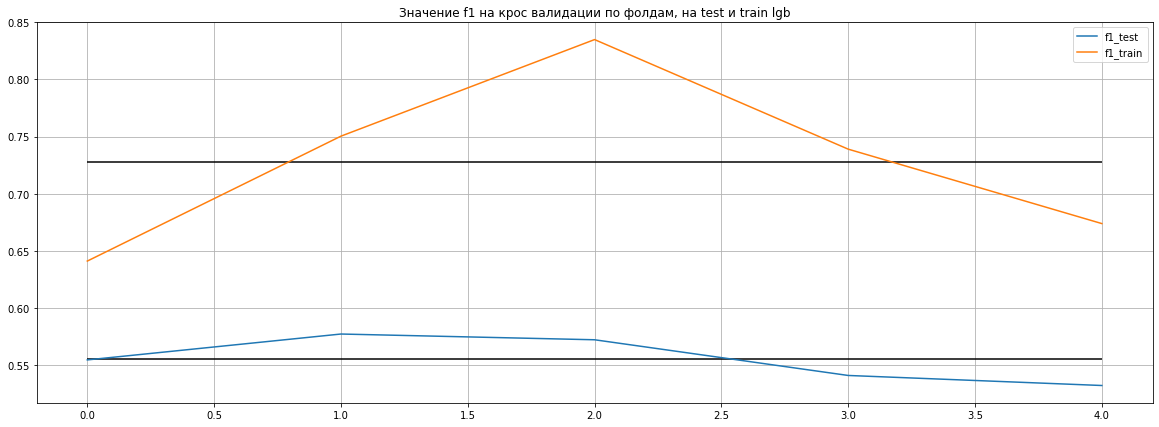

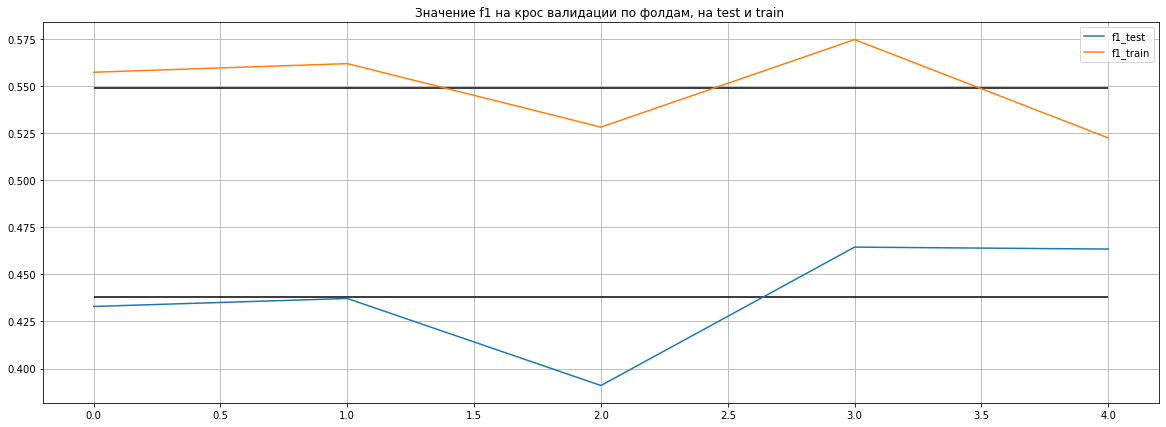

In [34]:
fig = plt.figure(figsize=(20,7))
plt.plot(res_base_df['lgb'].index.to_list(),res_base_df['lgb']['f1_test'],label='f1_test')
plt.plot(res_base_df['lgb'].index.to_list(),res_base_df['lgb']['f1_train'],label='f1_train')
plt.hlines(res_base['lgb']['f1_test'][5],0,4)
plt.hlines(res_base['lgb']['f1_train'][5],0,4)
plt.title('Значение f1 на крос валидации по фолдам, на test и train lgb')
plt.grid()
plt.legend()
plt.show()

fig = plt.figure(figsize=(20,7))
plt.plot(res_base_df['cat'].index.to_list(),res_base_df['cat']['f1_test'],label='f1_test')
plt.plot(res_base_df['cat'].index.to_list(),res_base_df['cat']['f1_train'],label='f1_train')
plt.hlines(res_base['cat']['f1_test'][5],0,4)
plt.hlines(res_base['cat']['f1_train'][5],0,4)
plt.title('Значение f1 на крос валидации по фолдам, на test и train ')
plt.grid()
plt.legend()
plt.show()

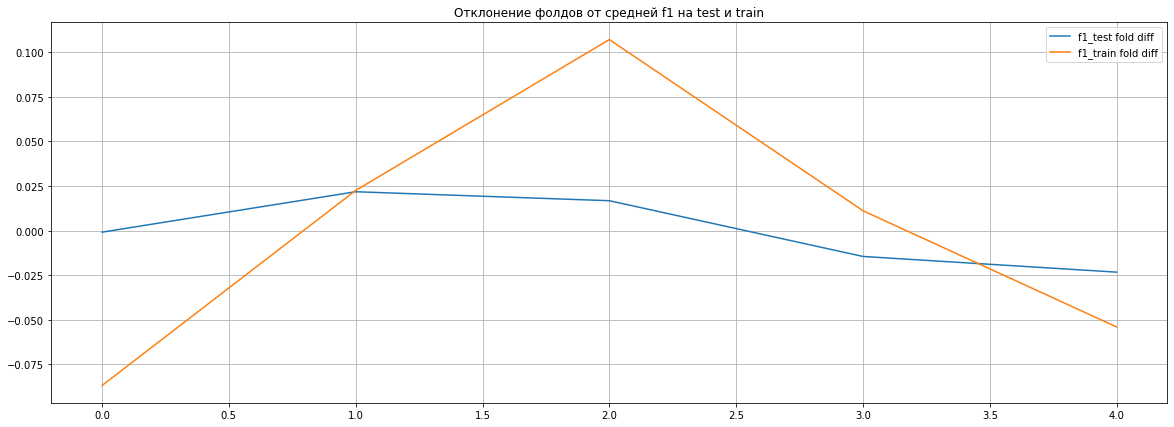

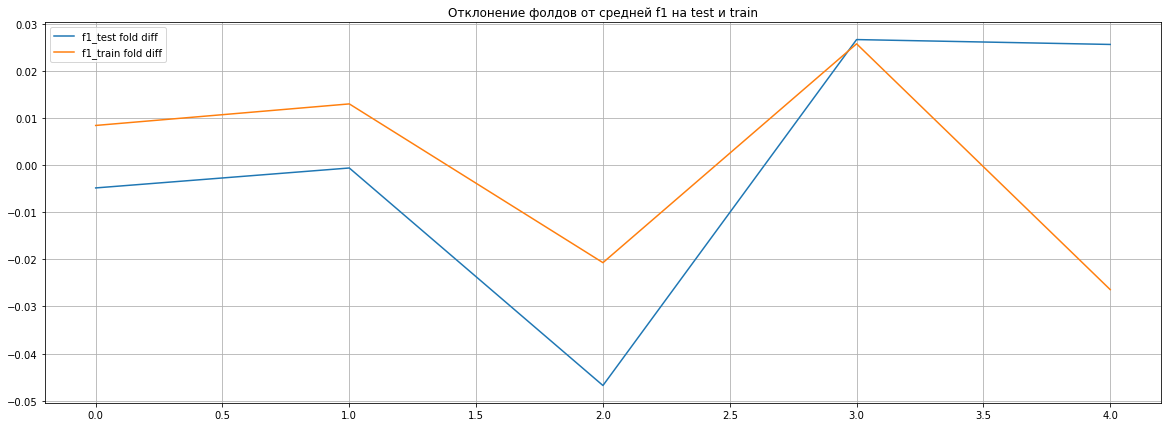

In [35]:
fig = plt.figure(figsize=(20,7))
plt.plot(res_base_df['lgb'].index.to_list(),res_base_df['lgb']['f1_test']-res_base['lgb']['f1_test'][5],\
         label='f1_test fold diff')
plt.plot(res_base_df['lgb'].index.to_list(),res_base_df['lgb']['f1_train']-res_base['lgb']['f1_train'][5],\
         label='f1_train fold diff')
plt.title('Отклонение фолдов от средней f1 на test и train')
plt.grid()
plt.legend()
plt.show()

fig = plt.figure(figsize=(20,7))
plt.plot(res_base_df['cat'].index.to_list(),res_base_df['cat']['f1_test']-res_base['cat']['f1_test'][5],\
         label='f1_test fold diff')
plt.plot(res_base_df['cat'].index.to_list(),res_base_df['cat']['f1_train']-res_base['cat']['f1_train'][5],\
         label='f1_train fold diff')
plt.title('Отклонение фолдов от средней f1 на test и train')
plt.grid()
plt.legend()
plt.show()

Прповедем анализ схожести признаков на train и  test

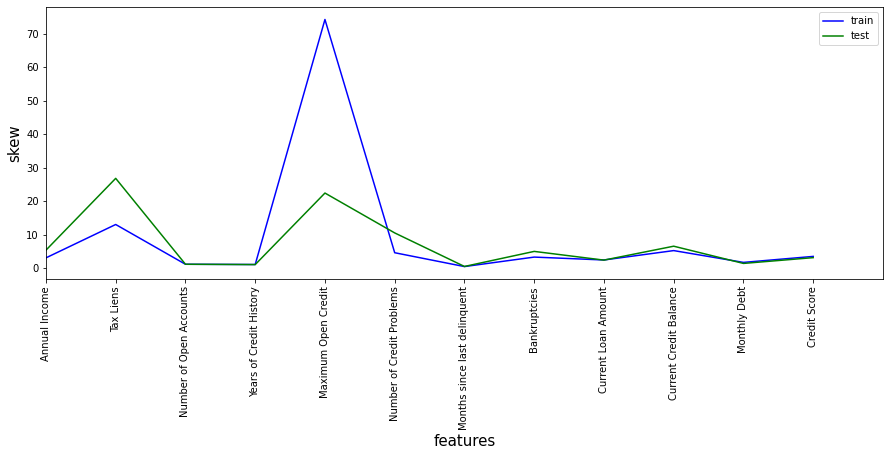

In [36]:
# статистика skew
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = train.drop('Credit Default',axis = 1).skew(), test.skew()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.xlim(0, len(train_stats))
plt.ylabel("skew", size=15)
plt.legend()
plt.show()

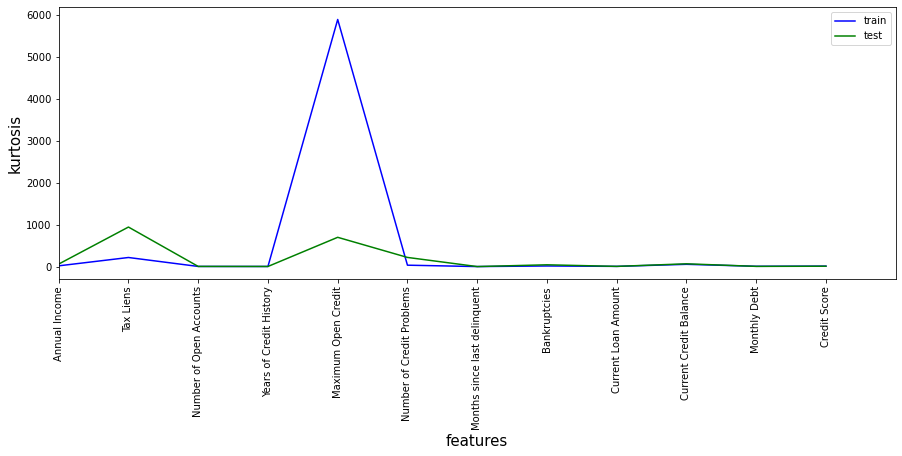

In [37]:
# статистика kurtosis
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = train.drop('Credit Default',axis = 1).kurtosis(), test.kurtosis()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.ylabel("kurtosis", size=15)
plt.xlim(0, len(train_stats))
plt.legend()
plt.show()

Как видно по признакам Tax Liens и Maximum Open Credit данные в тесте и трейне не релевантны могут плохо прогнозировать

Сразу внесем необходимые изменения в данные

In [38]:
test['Years in current job'].value_counts().index

Index(['10+ years', '3 years', '2 years', '< 1 year', '5 years', '1 year',
       '4 years', '7 years', '6 years', '8 years', '9 years'],
      dtype='object')

In [39]:
d={}
for i in train['Years in current job'].value_counts().index:
    if i[:2]=='10':
        d[i]=10
        continue
    if i[0]=='<':
        d[i]=0
        continue    
    d[i]=int(i[0])
d    

{'10+ years': 10,
 '2 years': 2,
 '3 years': 3,
 '< 1 year': 0,
 '5 years': 5,
 '1 year': 1,
 '4 years': 4,
 '6 years': 6,
 '7 years': 7,
 '8 years': 8,
 '9 years': 9}

In [40]:
train['Years in current job'] = train['Years in current job'].map(d)
test['Years in current job'] = test['Years in current job'].map(d)

In [41]:
# train.loc[train['Credit Score']>1000,'Credit Score'] = train[train['Credit Score']>1000]['Credit Score']/10
# test.loc[test['Credit Score']>1000,'Credit Score'] = test[test['Credit Score']>1000]['Credit Score']/10

In [42]:
train.loc[train['Maximum Open Credit']>7000000,'Maximum Open Credit']=7000000
test.loc[test['Maximum Open Credit']>7000000,'Maximum Open Credit']=7000000


In [43]:
# train.loc[train['Current Loan Amount']==99999999,'Current Loan Amount']=np.nan
# test.loc[test['Current Loan Amount']==99999999,'Current Loan Amount']=np.nan

In [44]:
train_work['start'] = train.copy()
test_work['start'] = test.copy()

Посмотрим пропуски

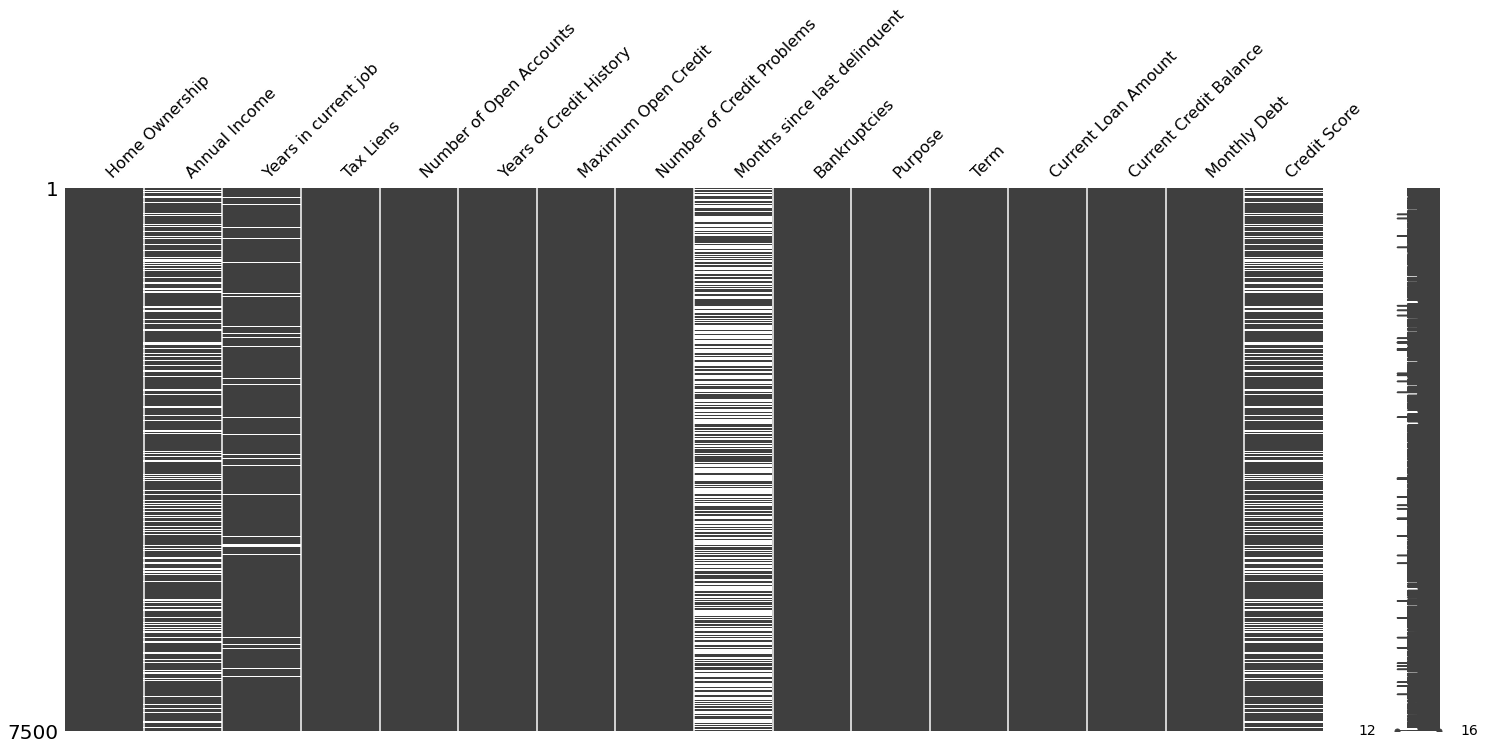

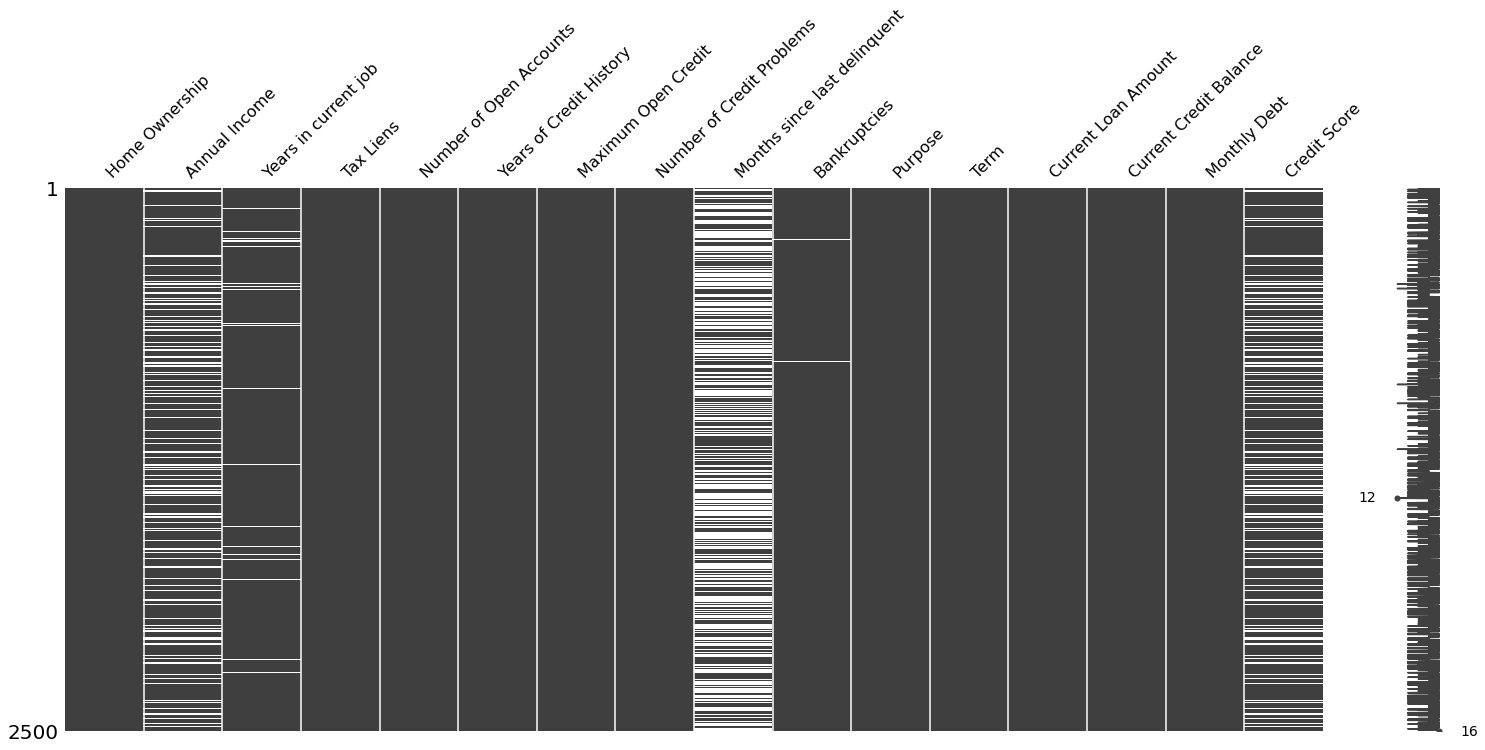

In [45]:
# train
msno.matrix(train.drop('Credit Default',axis = 1))

# test
msno.matrix(test)

Text(0.5, 0, 'Missing  Count')

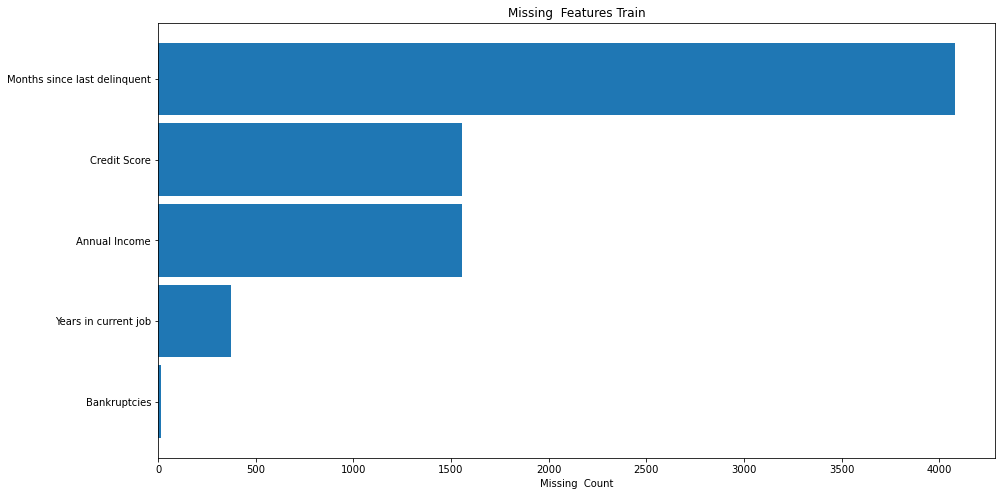

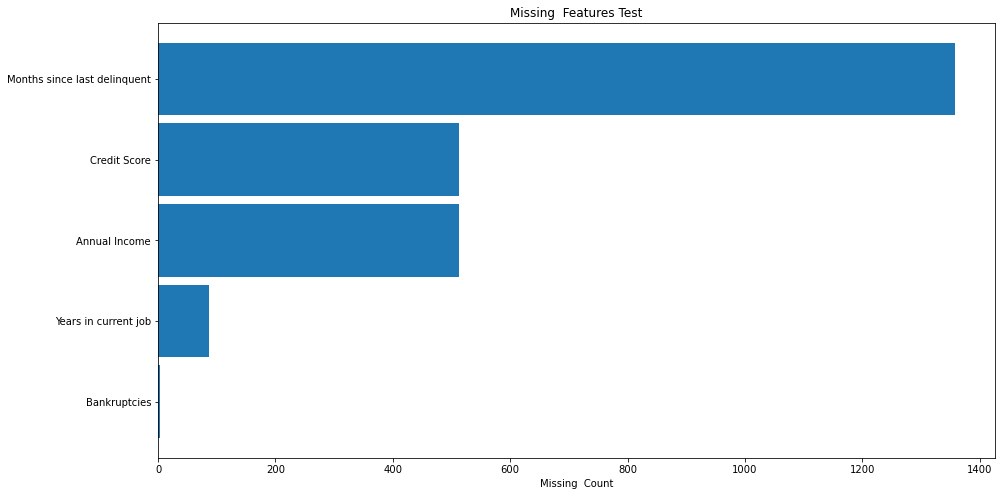

In [46]:
missing_values = train.isnull().sum(axis=0).reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values.loc[missing_values['missing_count']>0]
missing_values = missing_values.sort_values(by='missing_count')

ind = np.arange(missing_values.shape[0])
fig, axes = plt.subplots(figsize=(15, 8))
rects = axes.barh(ind, missing_values.missing_count.values, height=0.9)
axes.set_yticks(ind)
axes.set_yticklabels(missing_values.column_name.values, rotation='horizontal')
axes.set_title("Missing  Features Train")
axes.set_xlabel("Missing  Count")

missing_values = test.isnull().sum(axis=0).reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values.loc[missing_values['missing_count']>0]
missing_values = missing_values.sort_values(by='missing_count')

ind = np.arange(missing_values.shape[0])
fig, axes = plt.subplots(figsize=(15, 8))
rects = axes.barh(ind, missing_values.missing_count.values, height=0.9)
axes.set_yticks(ind)
axes.set_yticklabels(missing_values.column_name.values, rotation='horizontal')
axes.set_title("Missing  Features Test")
axes.set_xlabel("Missing  Count")

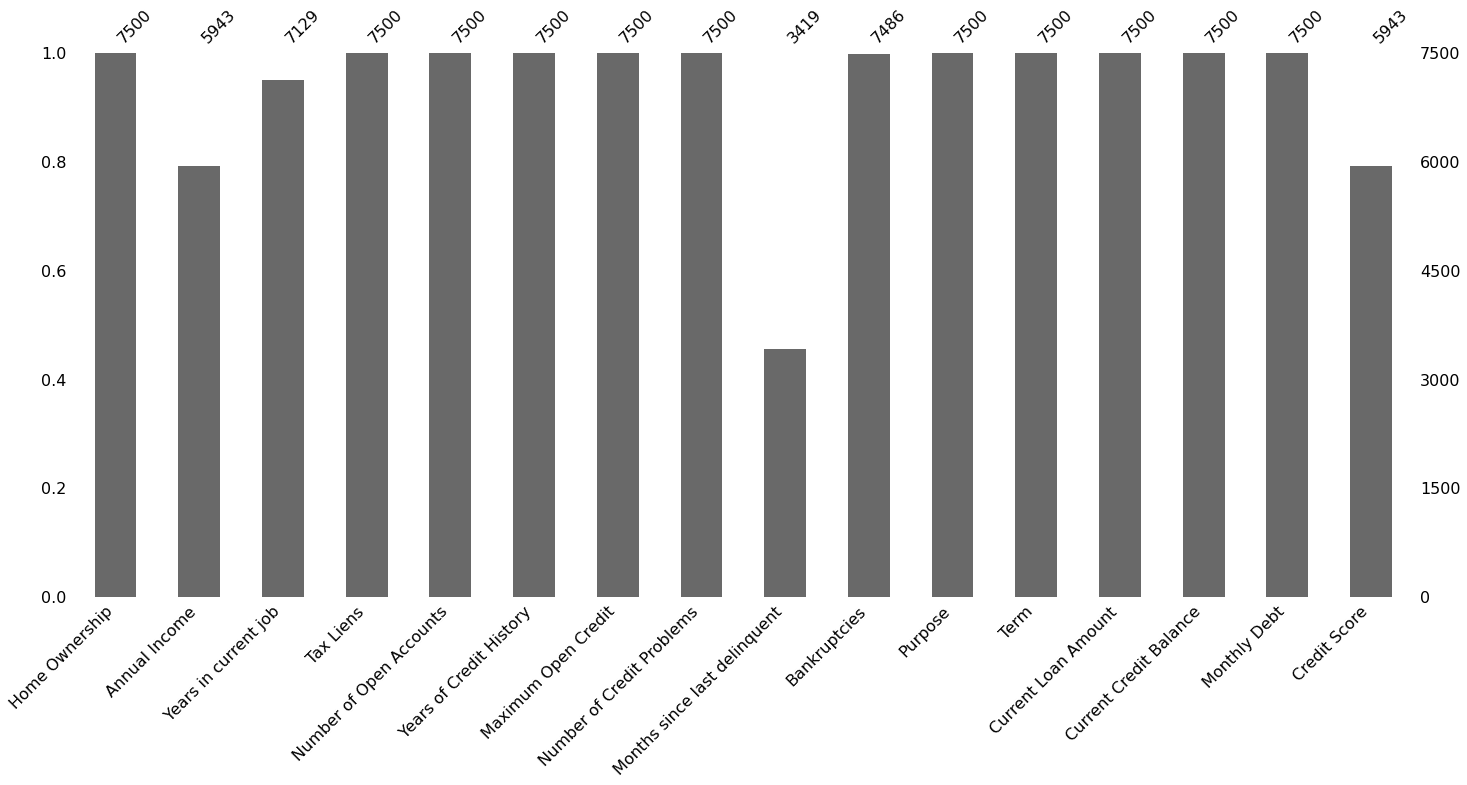

In [47]:
msno.bar(train.drop('Credit Default',axis = 1), labels=True)



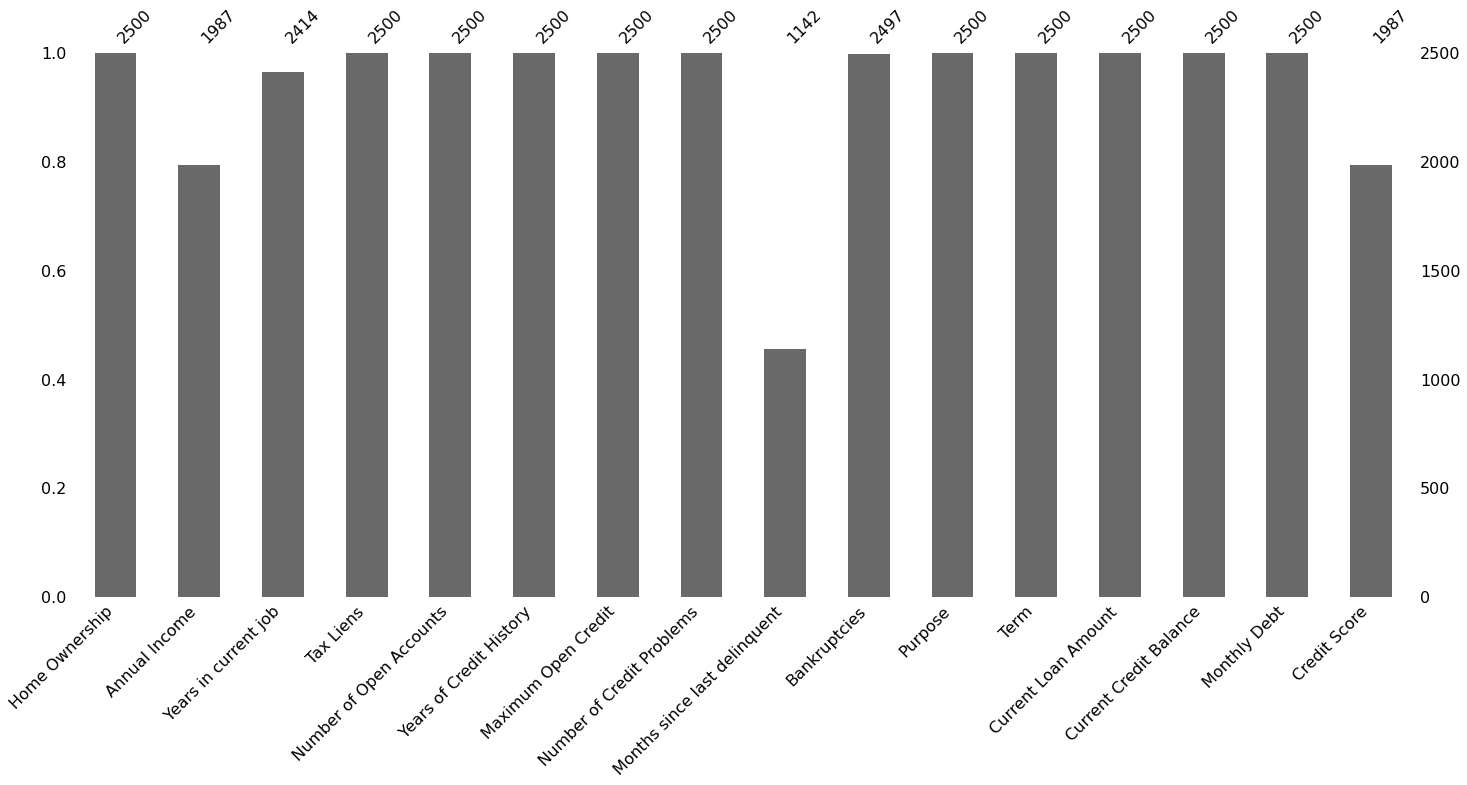

In [48]:
msno.bar(test, labels=True)

Сравним на одном графике пропуски на train и test

(0.0, 17.0)

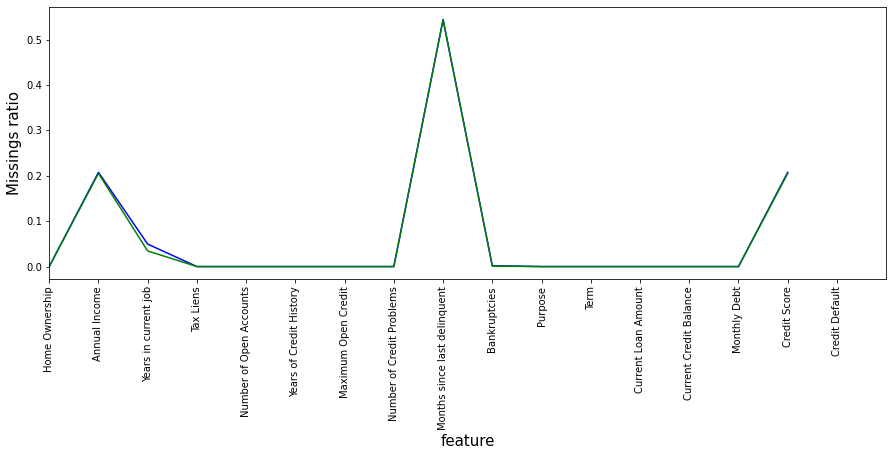

In [49]:
fig = plt.figure(figsize=(15, 5))
plt.plot(train.drop('Credit Default',axis = 1).isnull().mean(), label="train", color="blue")
plt.plot(test.isnull().mean(), label="test", color="green")
plt.xticks(range(train.shape[1]), train.columns, rotation=90)
plt.ylabel("Missings ratio", size=15)
plt.xlabel("feature", size=15)
plt.xlim(0, train.shape[1])

Как видно пропуски схожи на тесте и трене. Проблемы в полях :

    Months since last delinquent
    Credit Score
    Annual Income
    Years in current job
    Bankruptcies	
    
    
    

решим вопрос с пропусками

Months since last delinquent

Основные статистические показатели
Количество пропусков  - 4081
 ------------------------------------------------------------
Значения показателя и их частоты:
14.0     76
29.0     71
8.0      68
33.0     68
13.0     65
         ..
86.0      1
92.0      1
118.0     1
84.0      1
91.0      1
Name: Months since last delinquent, Length: 89, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
0    0.723107
1    0.276893
Name: Credit Default, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.712489
1    0.287511
Name: Credit Default, 

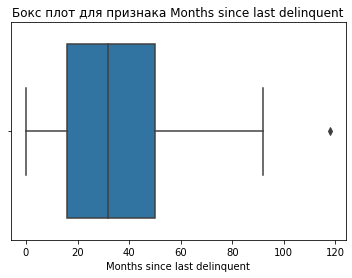

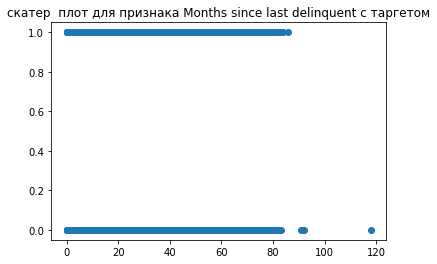

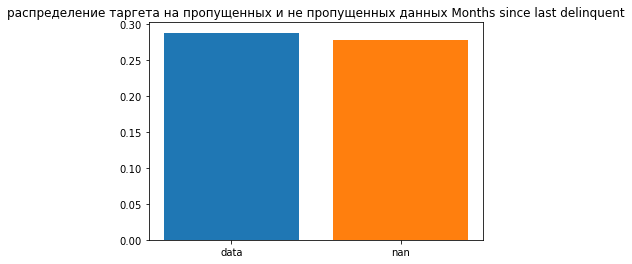

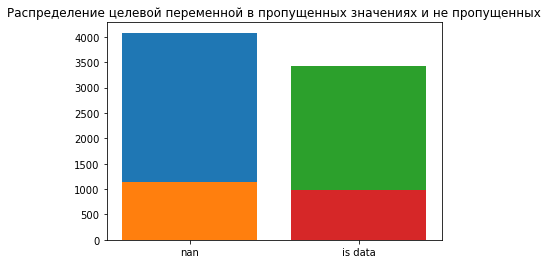

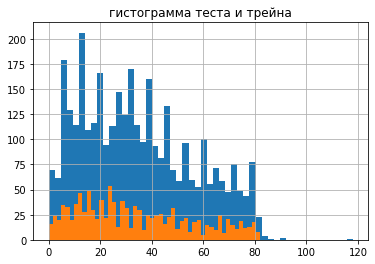

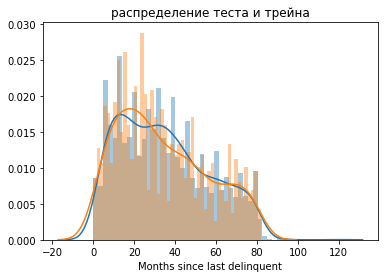

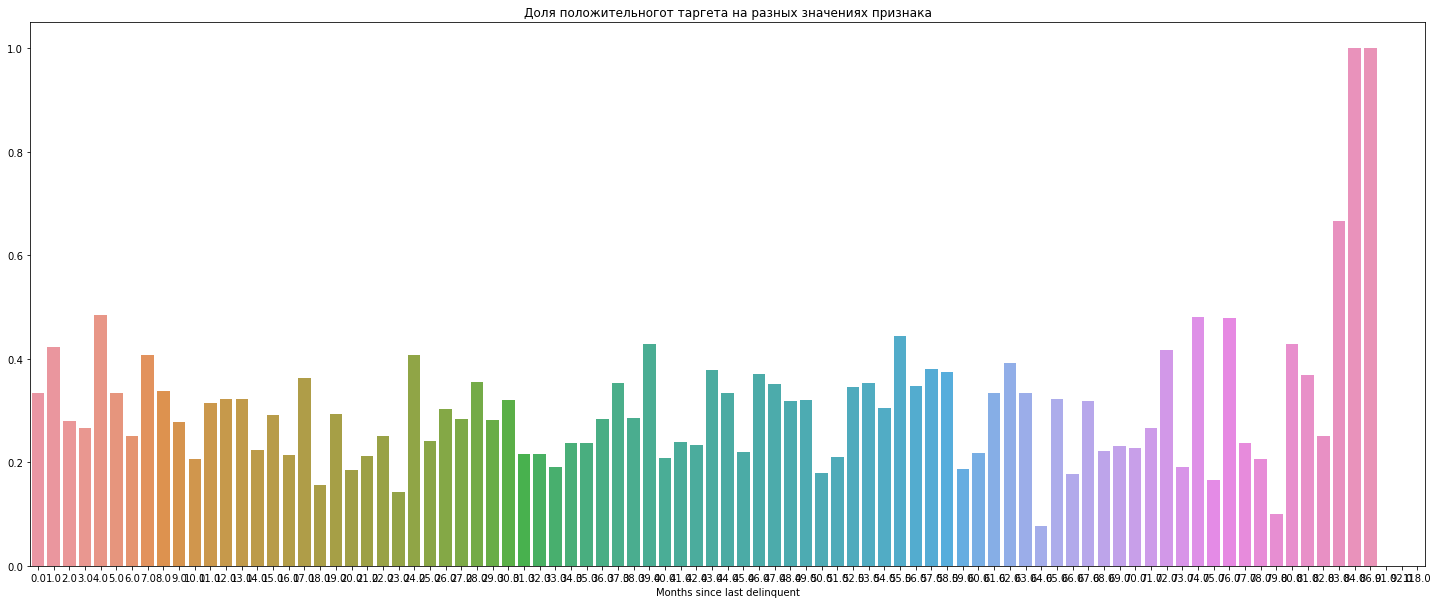

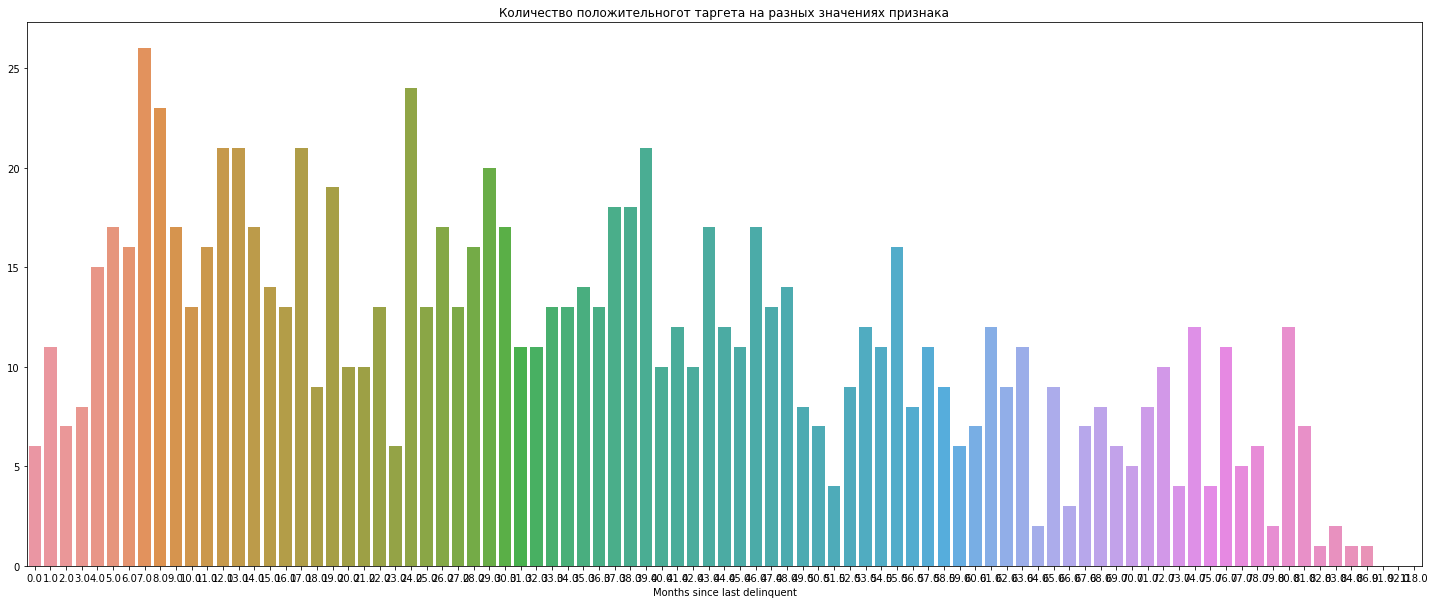

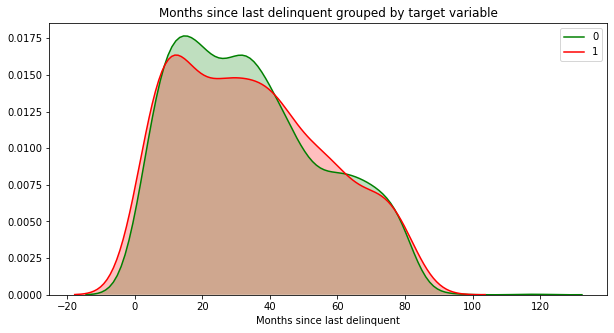

Значения теста Колмогорова-Смирнова (0.018, 0.5748285169064886)
Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (4187753.5, 2.2303574646660457e-71)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


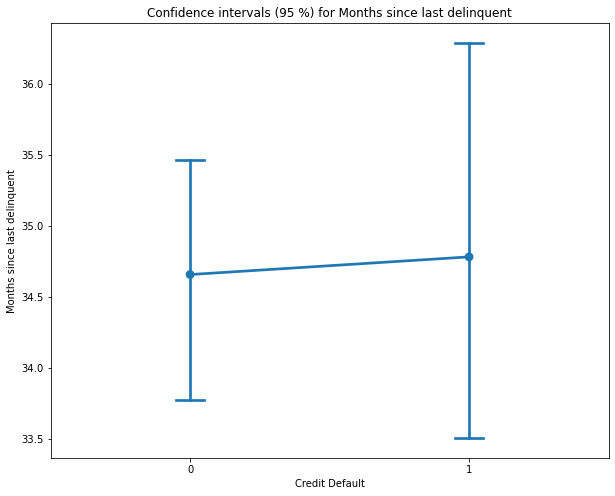

Посмотрим на корреляцию данного признака к другим
Bankruptcies                 0.162710
Number of Credit Problems    0.139905
Tax Liens                    0.052446
Credit Default               0.002598
Current Loan Amount          0.000459
Credit Score                -0.004395
Years in current job        -0.007207
Years of Credit History     -0.015375
Current Credit Balance      -0.027198
Number of Open Accounts     -0.032740
Maximum Open Credit         -0.049261
Monthly Debt                -0.057702
Annual Income               -0.101787
Name: Months since last delinquent, dtype: float64


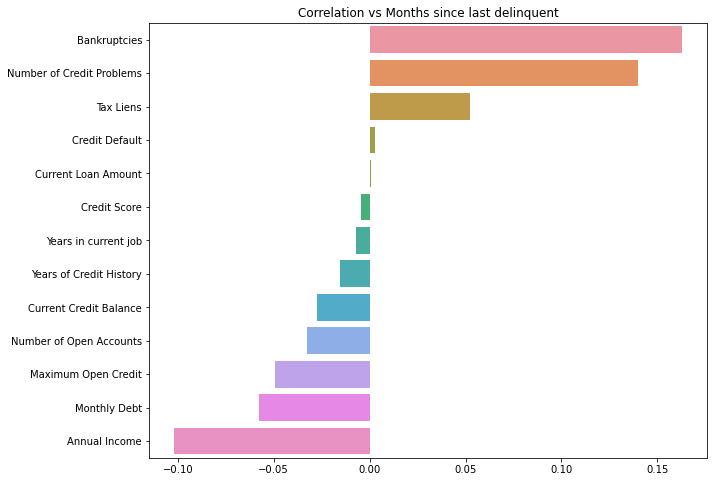

Коэф. Кендала
Bankruptcies                 0.121453
Number of Credit Problems    0.118877
Tax Liens                    0.034440
Credit Default               0.000014
Credit Score                -0.002429
Current Credit Balance      -0.009722
Years in current job        -0.010384
Current Loan Amount         -0.014071
Years of Credit History     -0.017340
Number of Open Accounts     -0.026767
Maximum Open Credit         -0.034142
Monthly Debt                -0.042211
Annual Income               -0.068333
Name: Months since last delinquent, dtype: float64


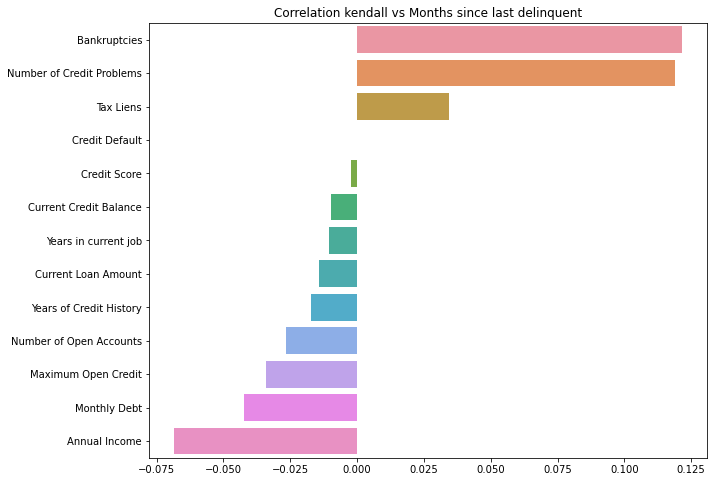

In [50]:
nan_feature_analysis(train,test,'Months since last delinquent',target_col[0])

Выводы:

    1. Распредлеление положительного таргета схожи для пустых значений и заполенных
    
    2. Распределение по джанному признаку на трейне и тесете похожи
    
    3. Данный признак плохо корелирует с таргетом, так и с другими признаками

In [51]:
best_distribution_value(train,target_col[0],'Months since last delinquent')

(9.0, 0.27689291840235236, 0.0017956061878115492)

In [52]:

train[train['Months since last delinquent']==9]['Credit Default'].value_counts(normalize=True)

0    0.721311
1    0.278689
Name: Credit Default, dtype: float64

Создадим три варианта модели с заменой на 36 и подбором данных через обучение на остальных признака и третий вариант заменим на 999

In [53]:
model,ind,pred = miss_forecast(train.drop(target_col,axis=1),'Months since last delinquent',categorical_features)

In [54]:
train_work['1']=train.copy()
train_work['1'].loc[ind,'Months since last delinquent'] = pred
train_work['2']=train.copy()
train_work['2'].loc[ind,'Months since last delinquent'] = 9
train_work['3']=train.copy()
train_work['3'].loc[ind,'Months since last delinquent'] = 999


На тесте

In [55]:
_,ind,pred = miss_forecast(test,'Months since last delinquent',categorical_features)

In [56]:
test_work['1']=test.copy()
test_work['1'].loc[ind,'Months since last delinquent'] = pred
test_work['2']=test.copy()
test_work['2'].loc[ind,'Months since last delinquent'] = 9
test_work['3']=test.copy()
test_work['3'].loc[ind,'Months since last delinquent'] = 999


Не линейная связь Months since last delinquent с другими признаками на основе модели обучения

Annual Income                83031
Years of Credit History      82502
Monthly Debt                 79273
Credit Score                 74948
Current Credit Balance       74513
Maximum Open Credit          74495
Current Loan Amount          73896
Number of Open Accounts      43062
Years in current job         42376
Home Ownership               13416
Term                          4961
Number of Credit Problems     4302
Bankruptcies                  2961
Purpose                        194
Tax Liens                        0
dtype: int32


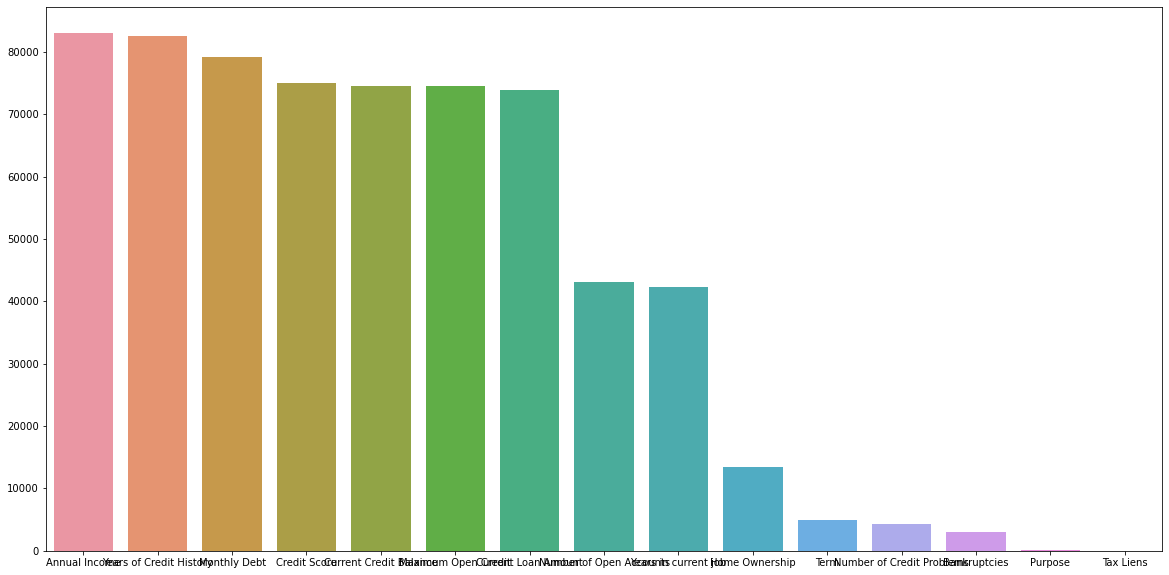

6 наиболее значимых признаков Index(['Annual Income', 'Years of Credit History', 'Monthly Debt',
       'Credit Score', 'Current Credit Balance', 'Maximum Open Credit'],
      dtype='object')


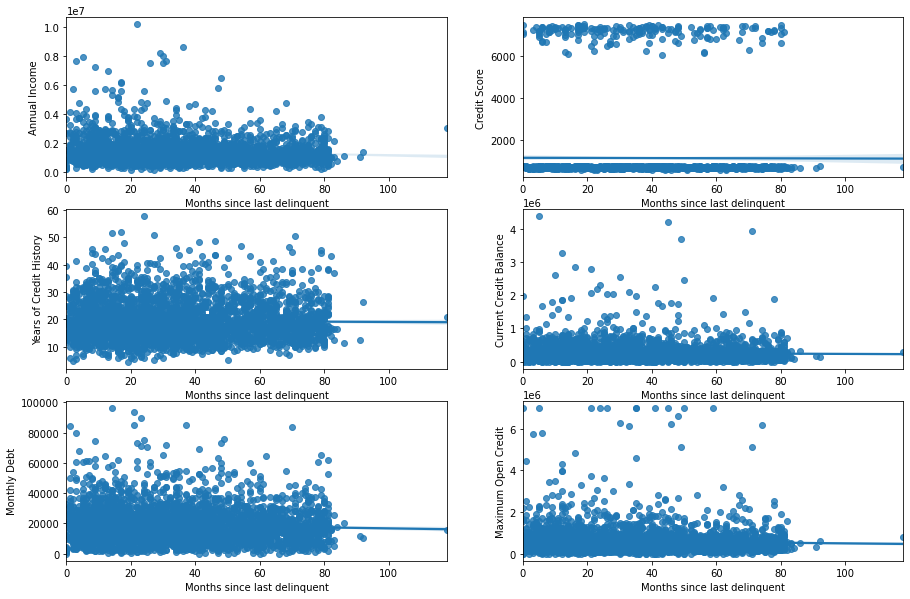

In [57]:
non_linear_link_for_nan(model,'Months since last delinquent',train.drop([target_col[0],'Months since last delinquent'],axis=1).columns)

Сравним до и после изменений

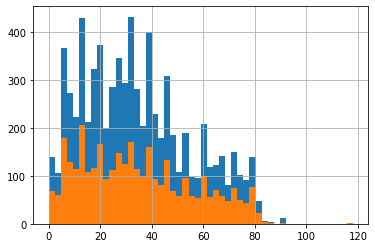

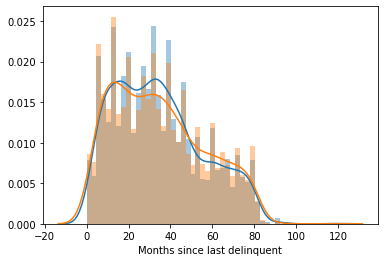

In [58]:
matching_after_changes(train,train_work['1'],'Months since last delinquent')

Рассмотрим следующий прзнак с пропусками Credit Score

Основные статистические показатели
Количество пропусков  - 1557
 ------------------------------------------------------------
Значения показателя и их частоты:
740.0     169
747.0     168
748.0     157
745.0     152
741.0     151
         ... 
602.0       1
616.0       1
585.0       1
620.0       1
7010.0      1
Name: Credit Score, Length: 268, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
0    0.660244
1    0.339756
Name: Credit Default, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.733468
1    0.266532
Name: Credit Default, dtype: fl

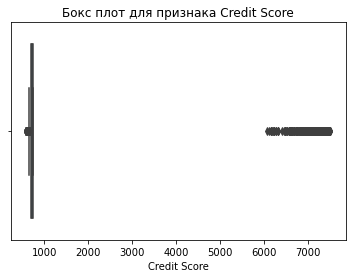

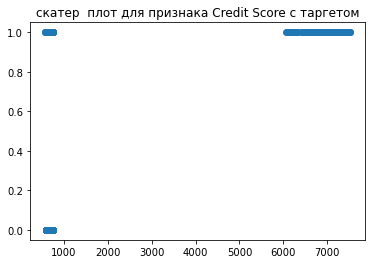

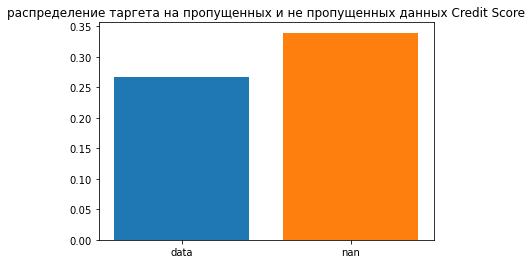

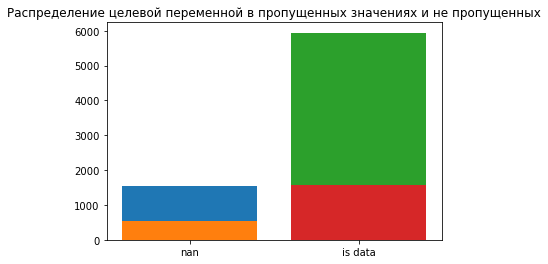

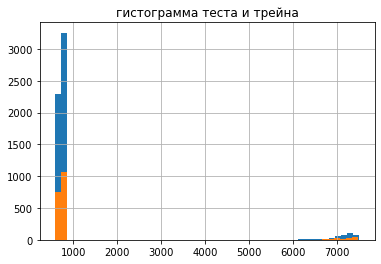

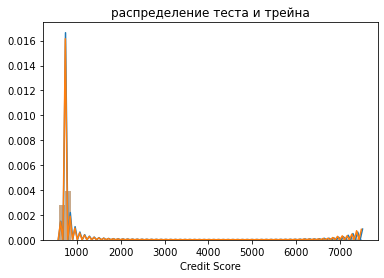

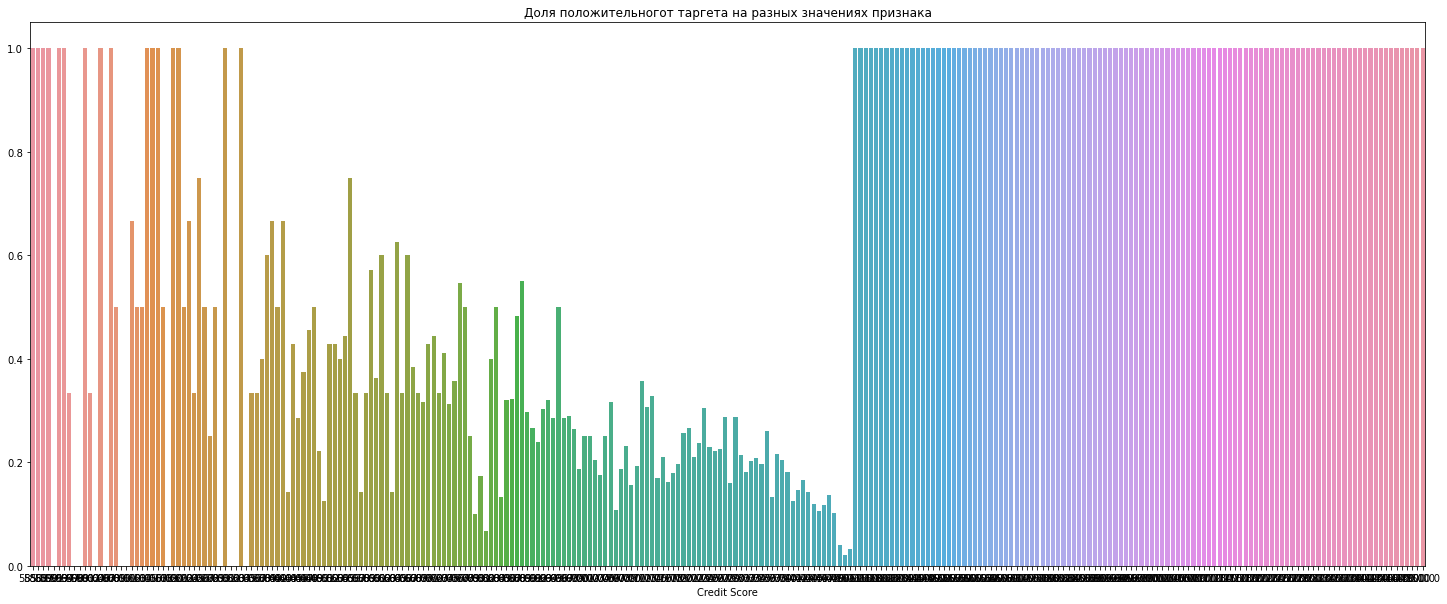

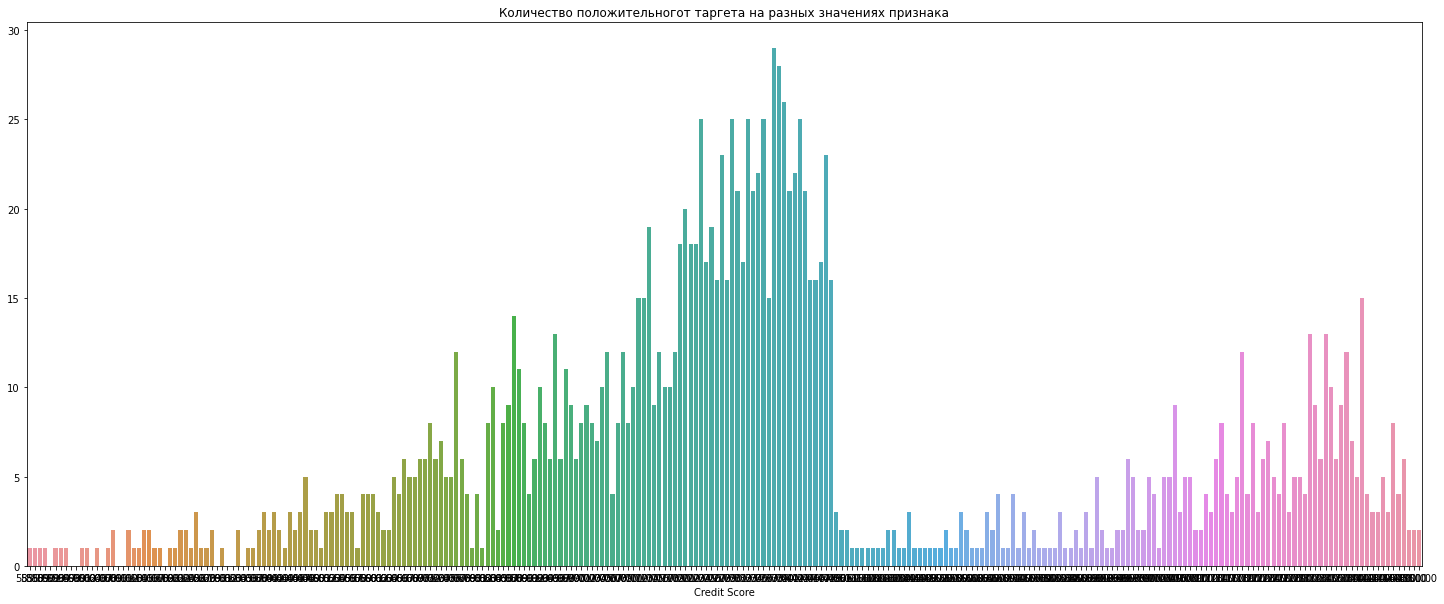

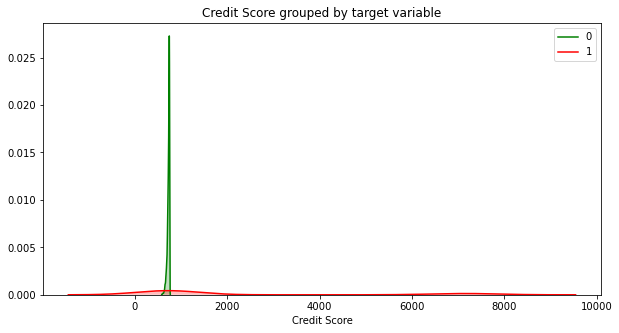

Значения теста Колмогорова-Смирнова (0.0144, 0.828953155607026)
Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (5197665.0, 2.4094608408145815e-09)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


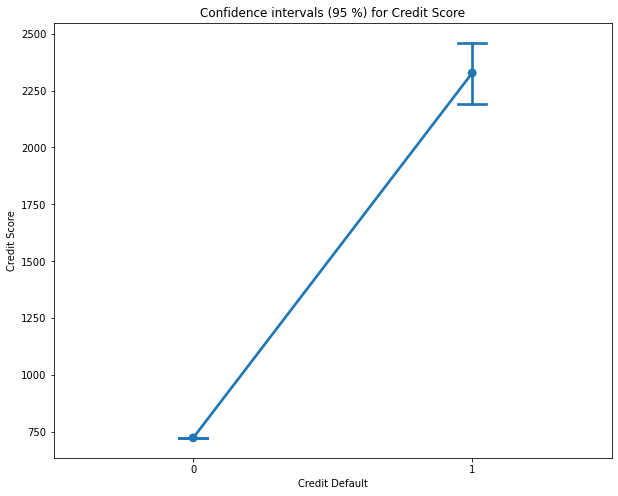

Посмотрим на корреляцию данного признака к другим
Credit Default                  0.442050
Number of Open Accounts         0.016095
Tax Liens                       0.010581
Monthly Debt                    0.000234
Months since last delinquent   -0.004395
Current Credit Balance         -0.006159
Years in current job           -0.009754
Years of Credit History        -0.015683
Number of Credit Problems      -0.018473
Maximum Open Credit            -0.026116
Bankruptcies                   -0.027488
Annual Income                  -0.037832
Current Loan Amount            -0.108552
Name: Credit Score, dtype: float64


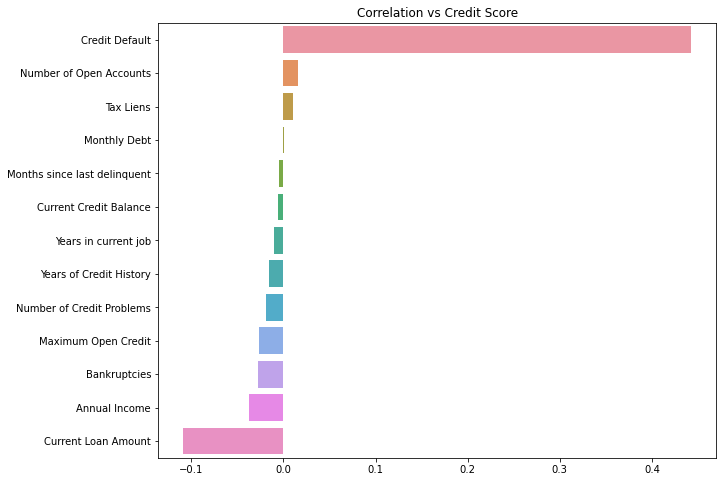

Коэф. Кендала
Maximum Open Credit             0.102776
Years of Credit History         0.040975
Credit Default                  0.029857
Annual Income                   0.027676
Current Credit Balance          0.004598
Months since last delinquent   -0.002429
Number of Open Accounts        -0.013987
Years in current job           -0.016003
Tax Liens                      -0.019350
Current Loan Amount            -0.021581
Monthly Debt                   -0.042276
Bankruptcies                   -0.057808
Number of Credit Problems      -0.066844
Name: Credit Score, dtype: float64


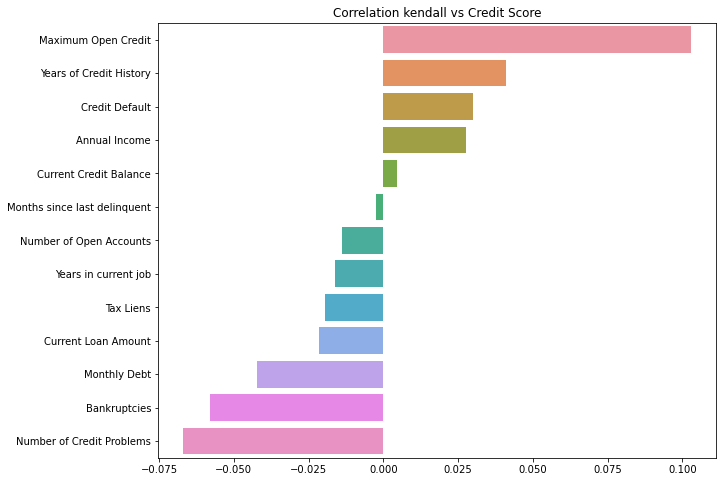

In [59]:
nan_feature_analysis(train,test,'Credit Score',target_col[0])

Выводы:

1. Распредлеление положительного таргета сильно различаются для пустых значений и заполенных

2. Распределение по данному признаку на трейне и тесете похожи

3. Данный признак не плохо корелирует с таргетом, а так же с Current Loan Amount и Maximum Open Credit

Найдем значение признака при котором распределние таргета будет такое же как при его отсутвии      
            
    

In [60]:
best_distribution_value(train,target_col[0],'Credit Score')

(624.0, 0.3397559409120103, 0.006422607578676964)

Создадим три варианта модели с заменой на 723 и подбором данных через обучение на остальных признака и третий вариант заменим на 999

In [61]:
model,ind,pred = miss_forecast(train.drop(target_col,axis=1),'Credit Score',categorical_features)

In [62]:
train_work['1'].loc[ind,'Credit Score'] = pred
train_work['2'].loc[ind,'Credit Score'] = 723
train_work['3'].loc[ind,'Credit Score']  = 999

In [63]:
_,ind,pred = miss_forecast(test,'Credit Score',categorical_features)

In [64]:
test_work['1'].loc[ind,'Credit Score'] = pred
test_work['2'].loc[ind,'Credit Score'] = 723
test_work['3'].loc[ind,'Credit Score']  = 999

Annual Income                   21560
Years of Credit History         20970
Monthly Debt                    20288
Current Credit Balance          19147
Maximum Open Credit             18434
Months since last delinquent    17861
Current Loan Amount             13626
Number of Open Accounts         11548
Years in current job             8076
Term                             4799
Home Ownership                   4784
Number of Credit Problems        1517
Bankruptcies                     1161
Purpose                            21
Tax Liens                           0
dtype: int32


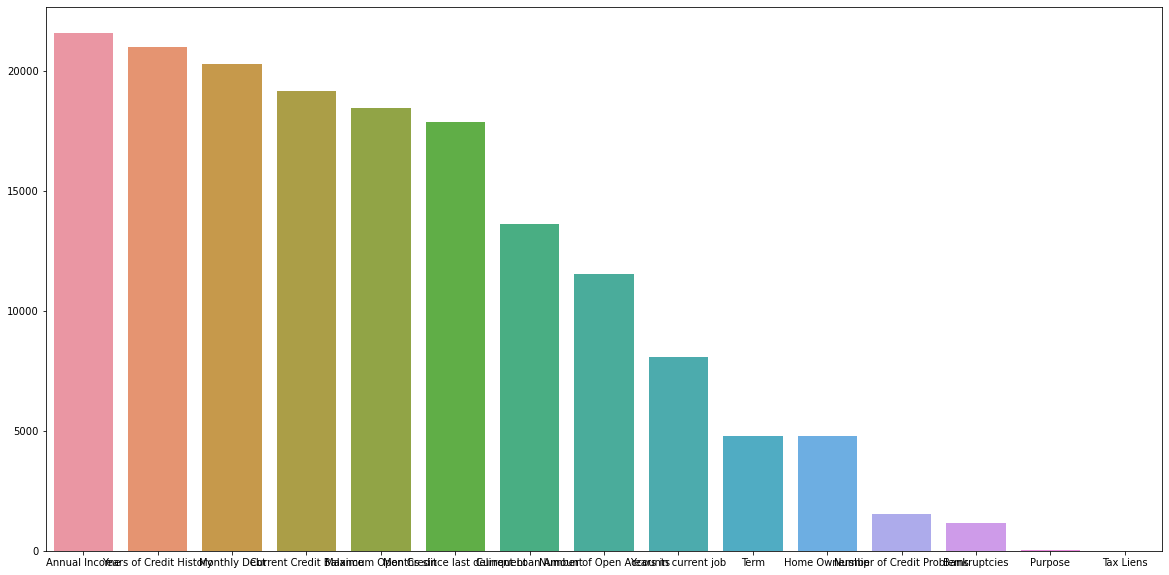

6 наиболее значимых признаков Index(['Annual Income', 'Years of Credit History', 'Monthly Debt',
       'Current Credit Balance', 'Maximum Open Credit',
       'Months since last delinquent'],
      dtype='object')


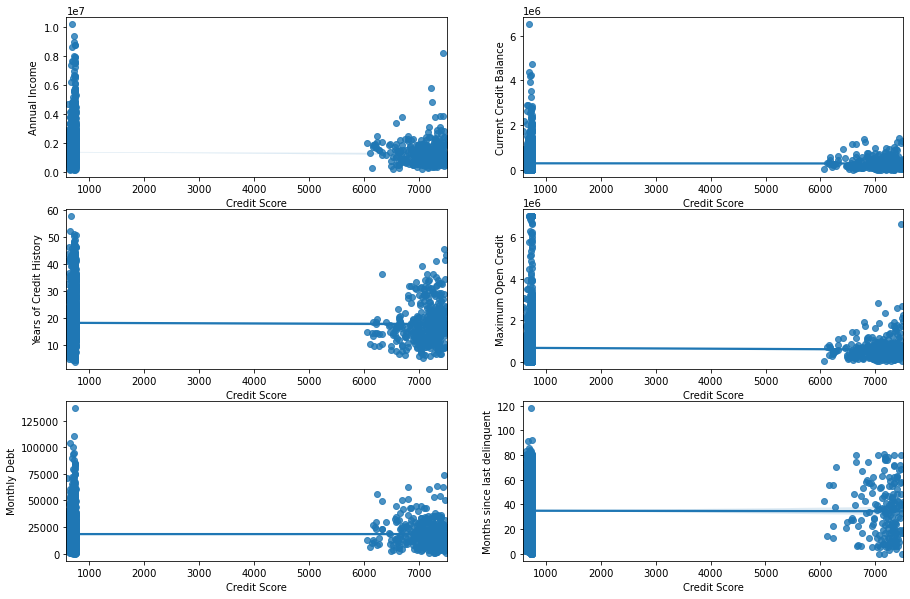

In [65]:
# Не линейная связь Months since last delinquent с другими признаками на основе модели обучения
non_linear_link_for_nan(model,'Credit Score',train.drop([target_col[0],'Credit Score'],axis=1).columns)

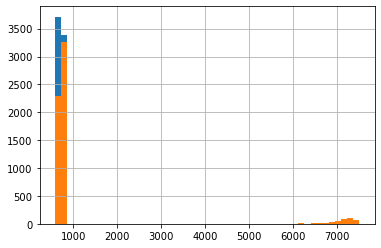

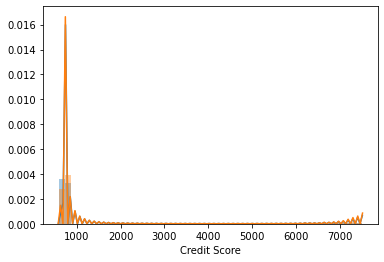

In [66]:
# Сравним до и после изменений
matching_after_changes(train,train_work['1'],'Credit Score')

Следующий признак Annual Income

In [67]:
feature = 'Annual Income'

Основные статистические показатели
Количество пропусков  - 1557
 ------------------------------------------------------------
Значения показателя и их частоты:
1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
            ..
1141254.0    1
7907382.0    1
1534478.0    1
972040.0     1
1654786.0    1
Name: Annual Income, Length: 5478, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
0    0.660244
1    0.339756
Name: Credit Default, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.733468
1    0.266532
Name: Cre

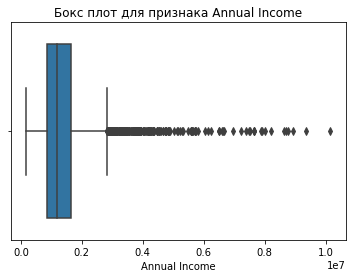

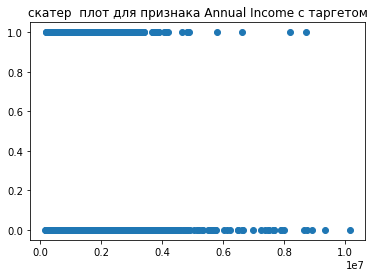

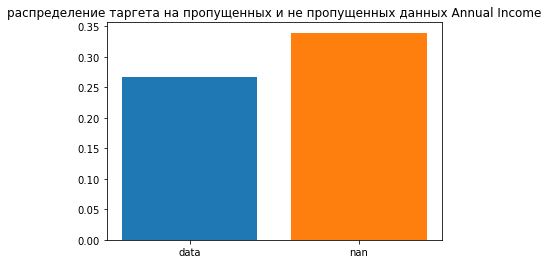

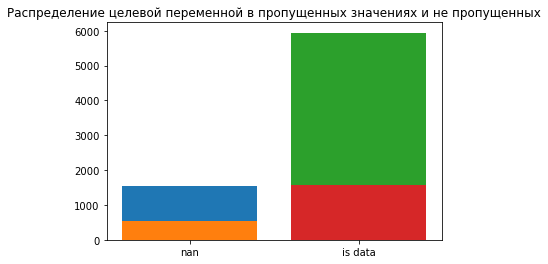

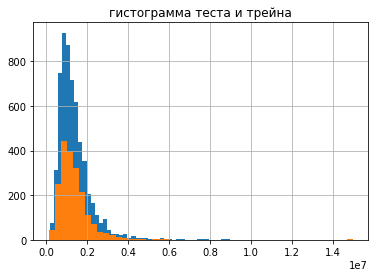

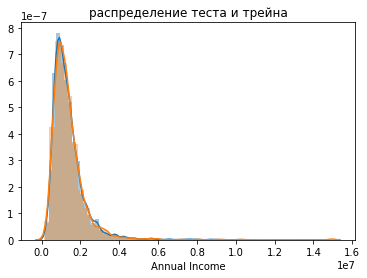

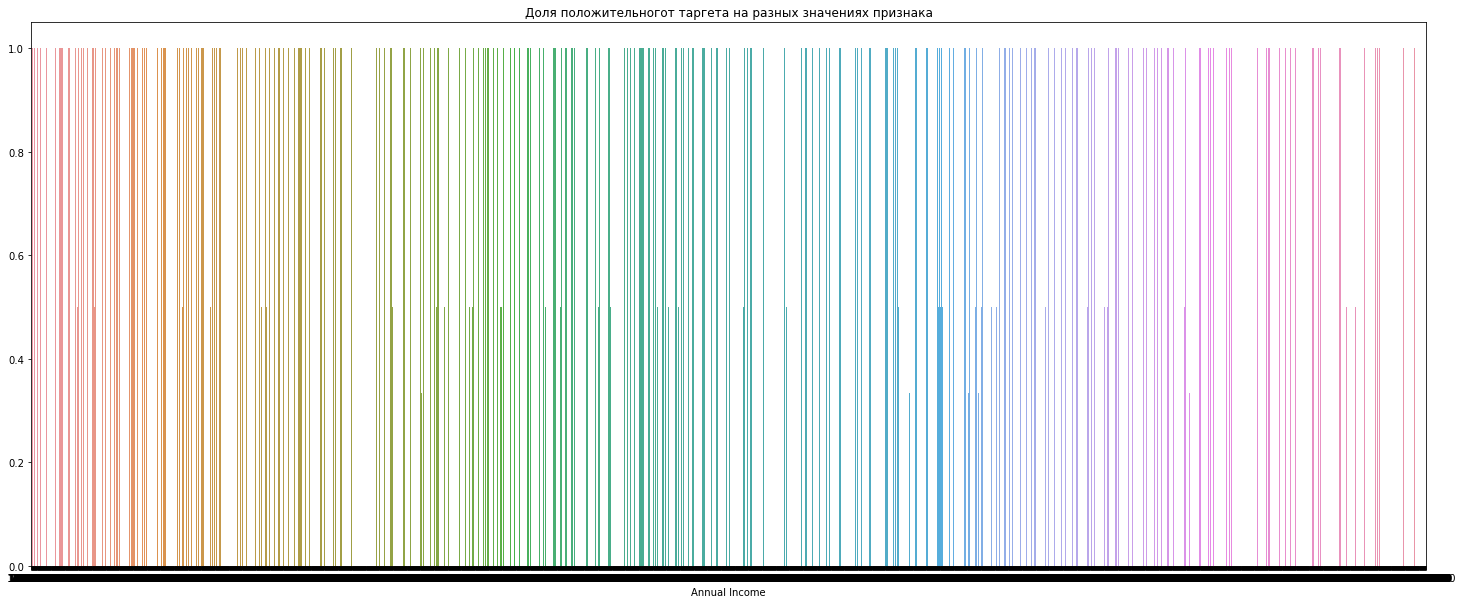

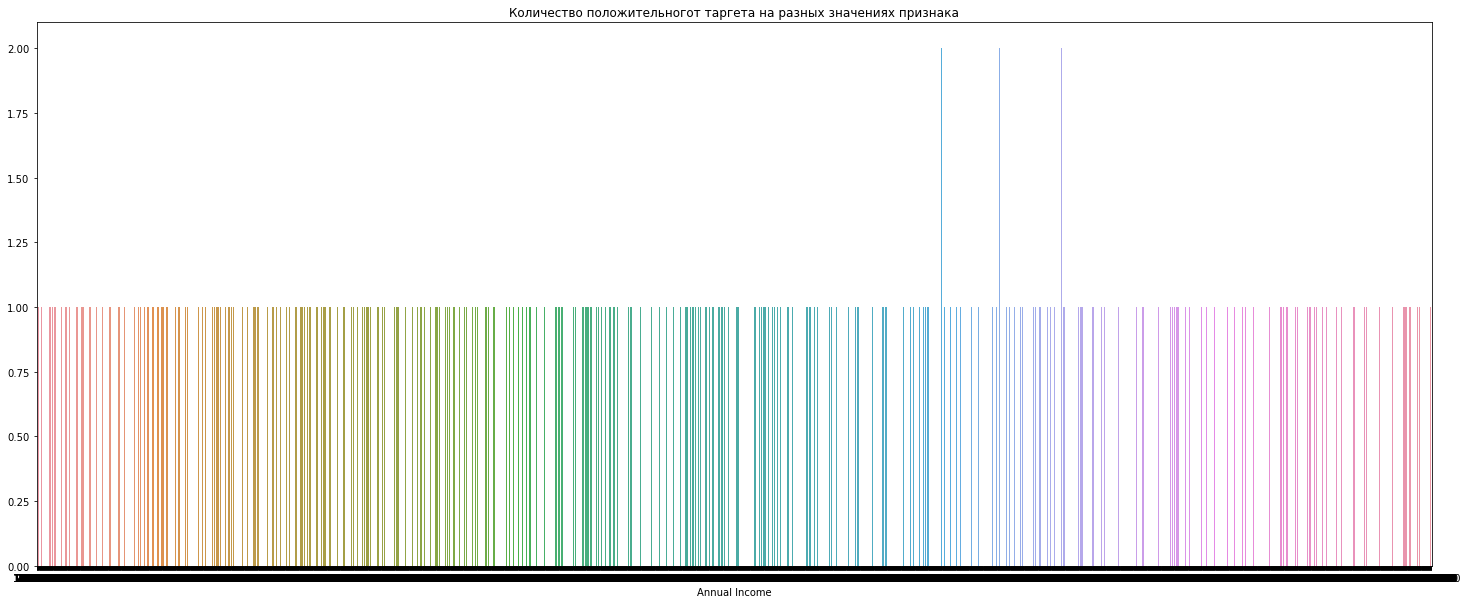

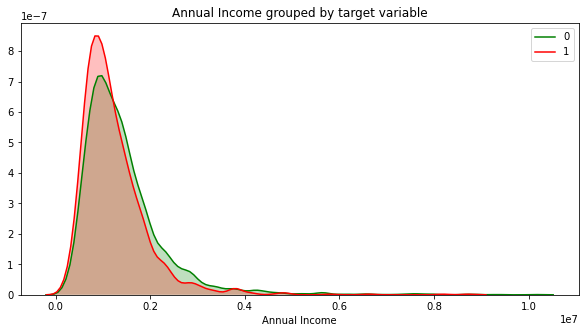

Значения теста Колмогорова-Смирнова (0.010933333333333333, 0.9775967821625542)
Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (5534342.5, 0.031334788783133206)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


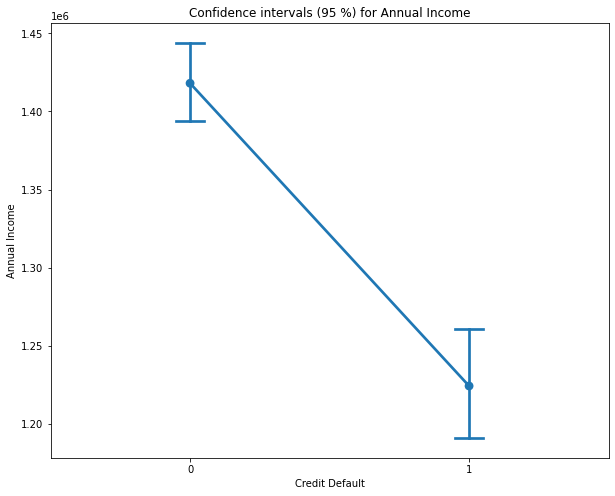

Посмотрим на корреляцию данного признака к другим
Monthly Debt                    0.584819
Current Credit Balance          0.386481
Maximum Open Credit             0.323672
Number of Open Accounts         0.188524
Years of Credit History         0.186531
Years in current job            0.104637
Tax Liens                       0.066245
Current Loan Amount             0.032082
Number of Credit Problems      -0.015407
Credit Score                   -0.037832
Bankruptcies                   -0.066877
Credit Default                 -0.101375
Months since last delinquent   -0.101787
Name: Annual Income, dtype: float64


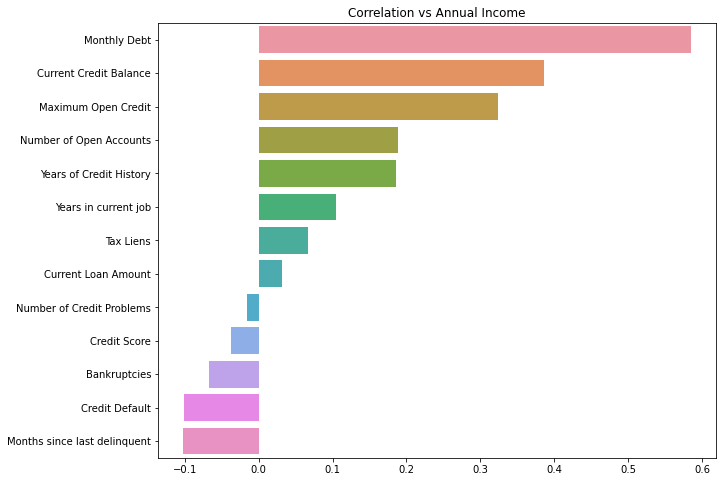

Коэф. Кендала
Monthly Debt                    0.426938
Current Loan Amount             0.281500
Current Credit Balance          0.272327
Maximum Open Credit             0.270076
Years of Credit History         0.175359
Number of Open Accounts         0.164784
Years in current job            0.121040
Tax Liens                       0.039103
Credit Score                    0.027676
Number of Credit Problems      -0.038700
Bankruptcies                   -0.053962
Months since last delinquent   -0.068333
Credit Default                 -0.091806
Name: Annual Income, dtype: float64


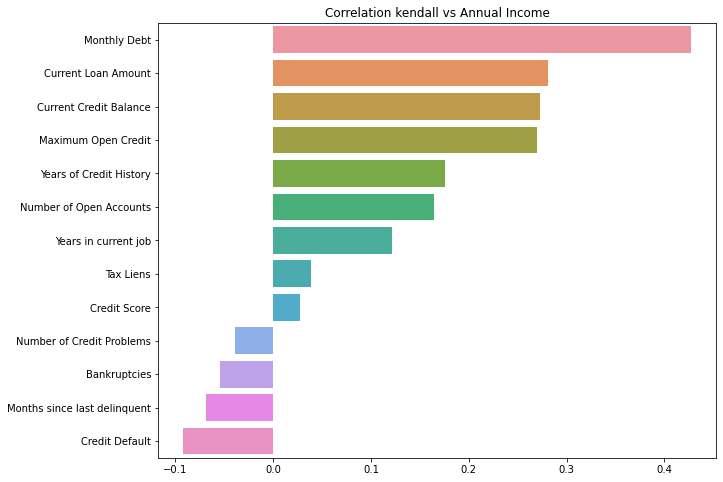

In [68]:
nan_feature_analysis(train,test,feature,target_col[0])

Выводы:

    1. Распредлеление положительного таргета сильно различаются для пустых значений и заполенных

    2. Распределение по данному признаку на трейне и тесете похожи

    3. Данный признак не очень корелирует с таргетом, зате есть более сильная кореляция с другими признаками  Monthly Debt, Current Credit Balance ,Number of Open Accounts ,Years of Credit History  
    
    4. Все данные логически обоснованны, менять ничего не будем
    

Создадим три варианта модели с заменой на 999 и подбором данных через обучение на остальных признака и заменой медианным значением

In [69]:
model,ind,pred = miss_forecast_reg(train.drop(target_col,axis=1),feature,categorical_features)

In [70]:
train_work['1'].loc[ind,feature] = pred
train_work['2'].loc[ind,feature] = train[feature].median()
train_work['3'].loc[ind,feature]  = 999

In [71]:
_,ind,pred = miss_forecast_reg(test,feature,categorical_features)

In [72]:
test_work['1'].loc[ind,feature] = pred
test_work['2'].loc[ind,feature] = test[feature].median()
test_work['3'].loc[ind,feature]  = 999

Credit Score                    3990
Monthly Debt                    3936
Current Credit Balance          3850
Maximum Open Credit             3718
Years of Credit History         3712
Current Loan Amount             3462
Months since last delinquent    2339
Years in current job            1901
Number of Open Accounts         1847
Home Ownership                   549
Term                             221
Purpose                          216
Number of Credit Problems        174
Bankruptcies                      75
Tax Liens                         10
dtype: int32


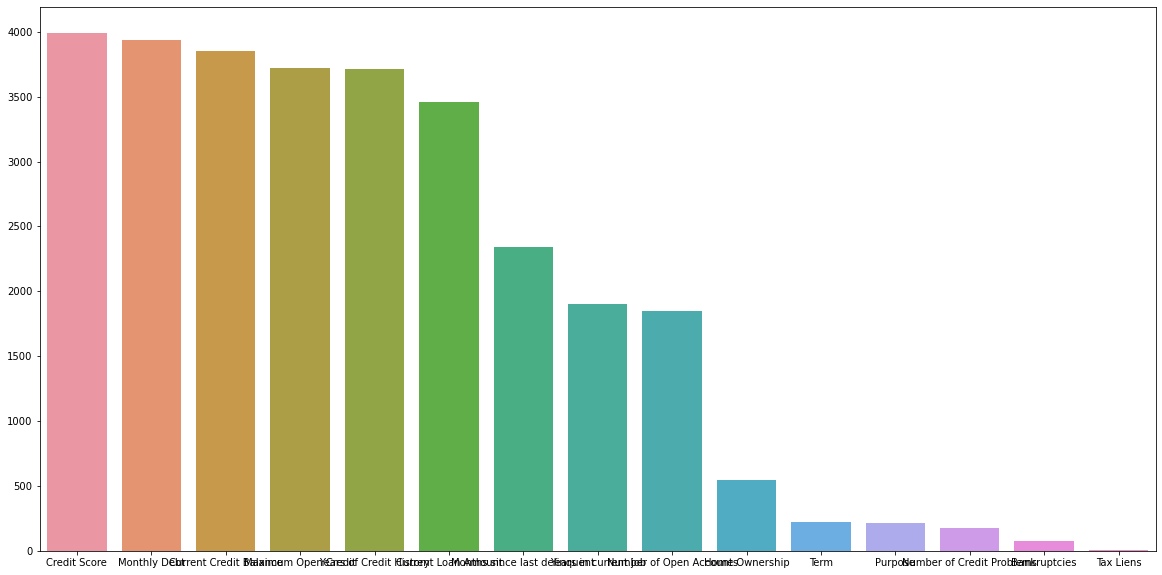

6 наиболее значимых признаков Index(['Credit Score', 'Monthly Debt', 'Current Credit Balance',
       'Maximum Open Credit', 'Years of Credit History',
       'Current Loan Amount'],
      dtype='object')


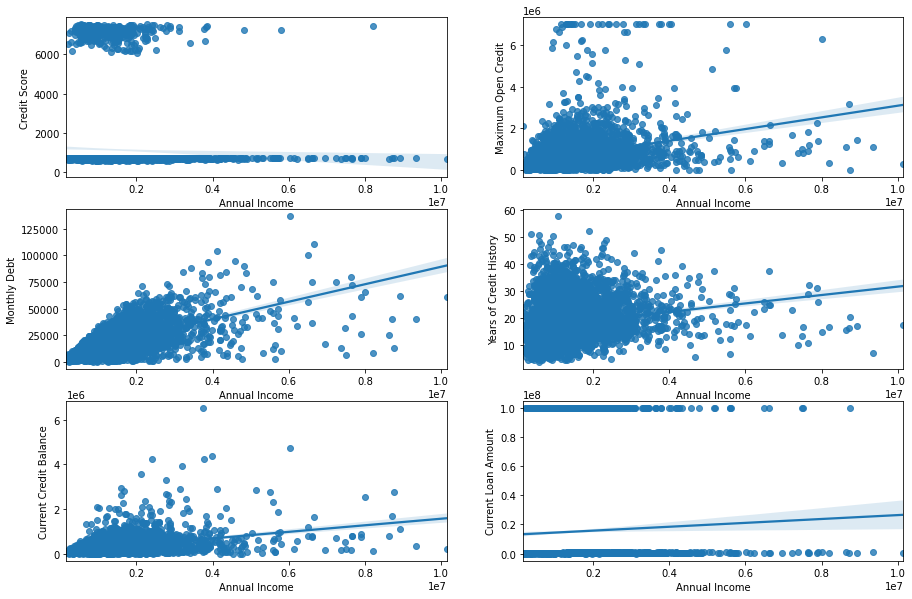

In [73]:
# Не линейная связь Months since last delinquent с другими признаками на основе модели обучения
non_linear_link_for_nan(model,feature,train.drop([target_col[0],feature],axis=1).columns)

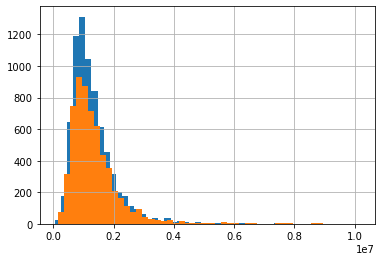

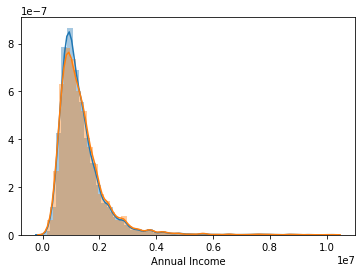

In [74]:
# Сравним до и после изменений
matching_after_changes(train,train_work['1'],feature)

следующий признак Years in current job

In [75]:
feature = 'Years in current job'

Основные статистические показатели
Количество пропусков  - 371
 ------------------------------------------------------------
Значения показателя и их частоты:
10.0    2332
2.0      705
3.0      620
0.0      563
5.0      516
1.0      504
4.0      469
6.0      426
7.0      396
8.0      339
9.0      259
Name: Years in current job, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    7129.000000
mean        5.880348
std         3.620092
min         0.000000
25%         3.000000
50%         6.000000
75%        10.000000
max        10.000000
Name: Years in current job, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
0    0.630728
1    0.369272
Name: Credit Default, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.722822
1    0.277178
Name: Credit Default, dtype: float64 
 -

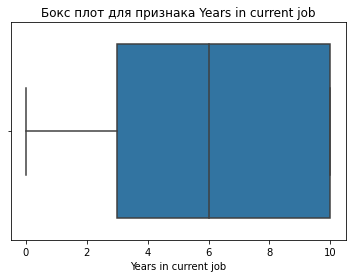

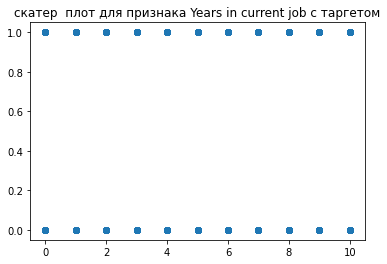

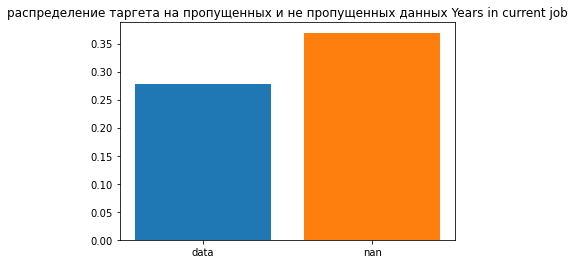

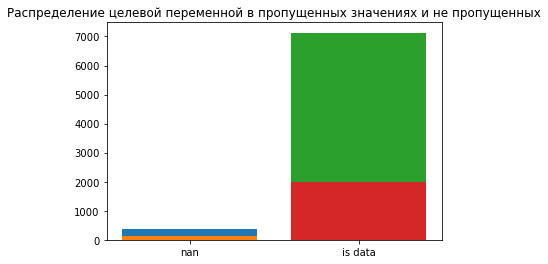

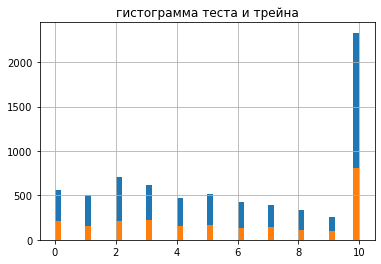

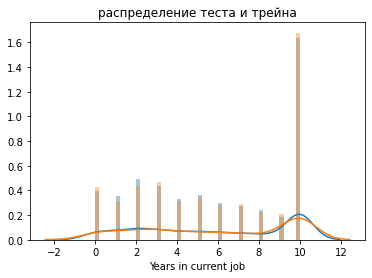

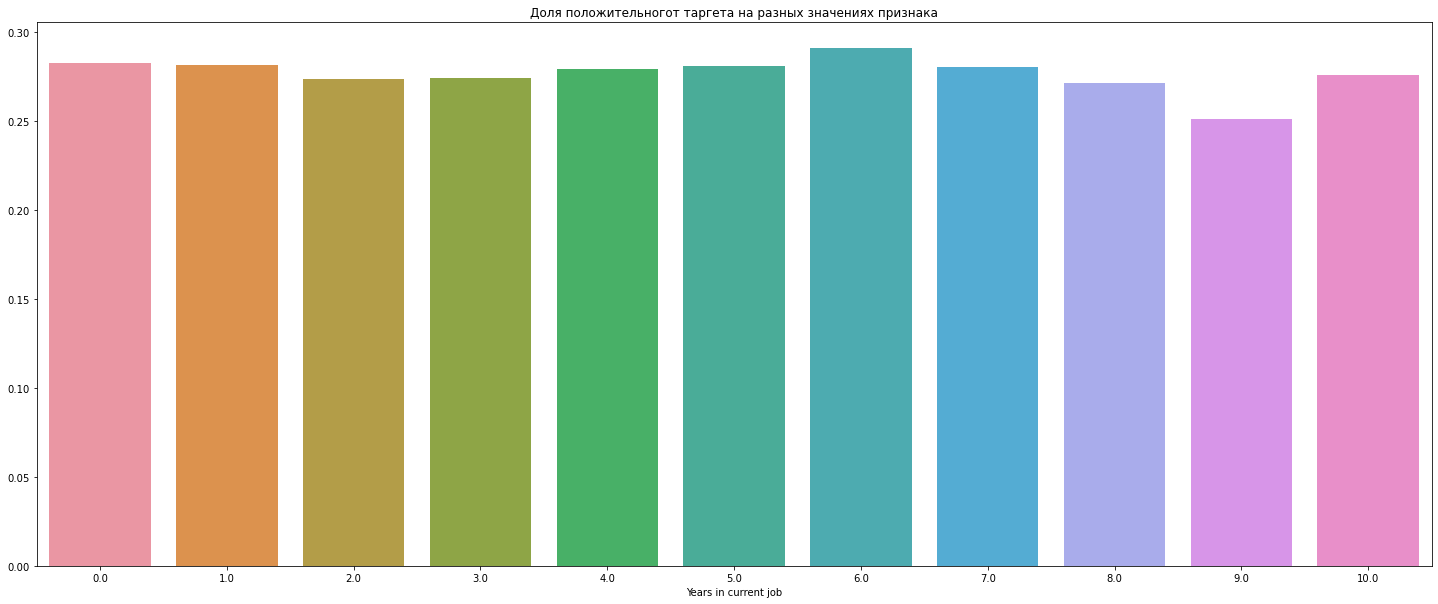

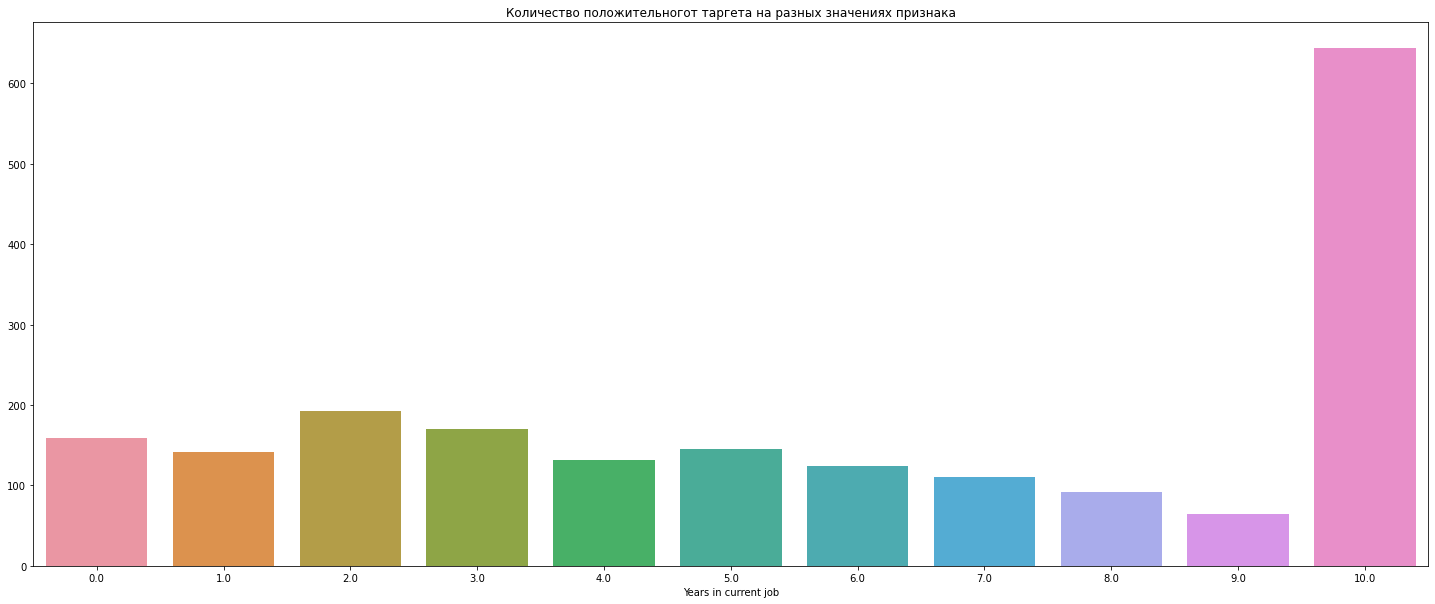

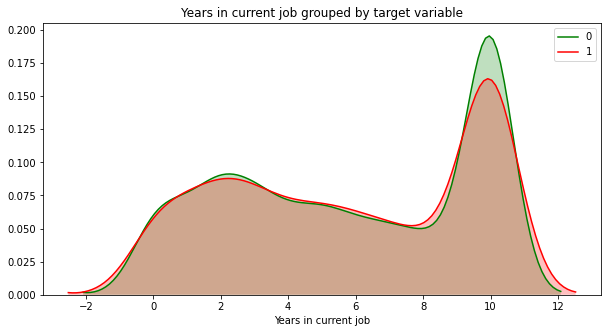

Значения теста Колмогорова-Смирнова (0.015066666666666667, 0.7853487354916262)
Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (5594511.0, 0.1214478487857717)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


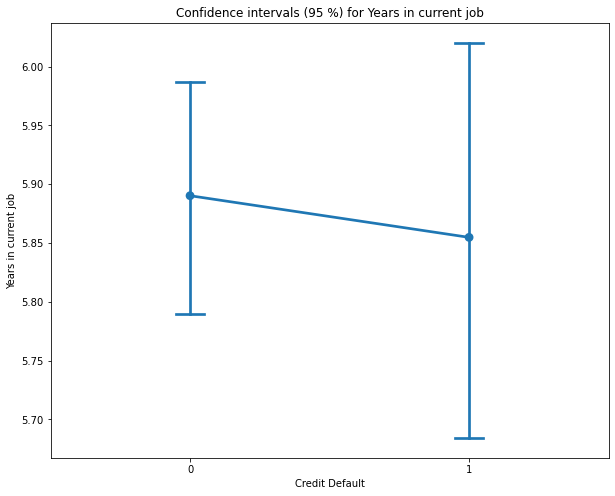

Посмотрим на корреляцию данного признака к другим
Years of Credit History         0.233286
Monthly Debt                    0.125483
Current Credit Balance          0.110127
Maximum Open Credit             0.105162
Annual Income                   0.104637
Bankruptcies                    0.058089
Number of Open Accounts         0.055124
Number of Credit Problems       0.050220
Tax Liens                       0.017723
Current Loan Amount            -0.001335
Credit Default                 -0.004378
Months since last delinquent   -0.007207
Credit Score                   -0.009754
Name: Years in current job, dtype: float64


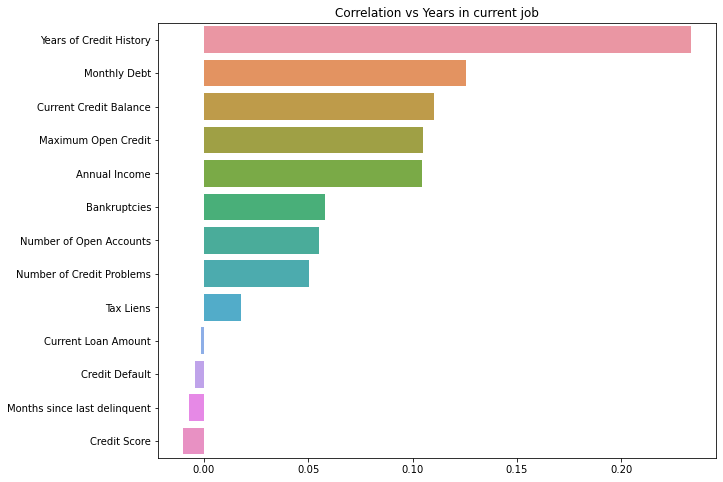

Коэф. Кендала
Years of Credit History         0.186524
Annual Income                   0.121040
Monthly Debt                    0.106264
Current Credit Balance          0.104260
Maximum Open Credit             0.097286
Current Loan Amount             0.080459
Number of Credit Problems       0.061682
Bankruptcies                    0.057170
Number of Open Accounts         0.045375
Tax Liens                       0.021523
Credit Default                 -0.003247
Months since last delinquent   -0.010384
Credit Score                   -0.016003
Name: Years in current job, dtype: float64


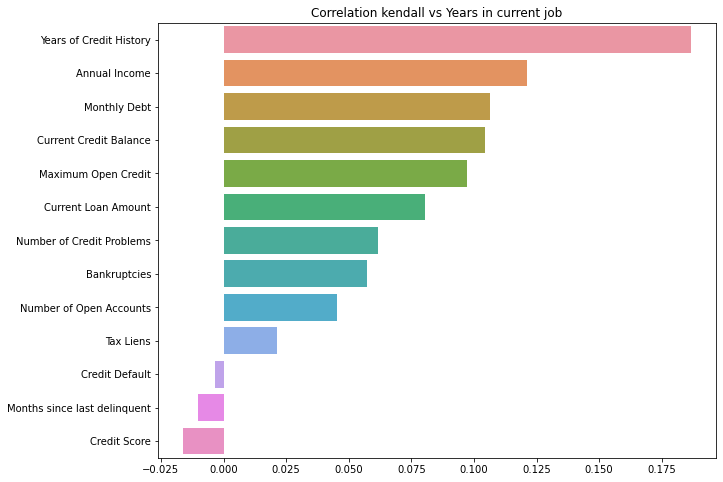

In [76]:
nan_feature_analysis(train,test,feature,target_col[0])

In [77]:
best_distribution_value(train,target_col[0],feature)

(6.0, 0.3692722371967655, 0.07819242499019274)

Создадим три варианта модели с заменой на 6 и подбором данных через обучение на остальных признака и третий вариант заменим на 999

In [78]:
model,ind,pred = miss_forecast(train.drop(target_col,axis=1),feature,categorical_features)

In [79]:
train_work['1'].loc[ind,feature] = pred
train_work['2'].loc[ind,feature] = 6
train_work['3'].loc[ind,feature]  = 999

In [80]:
_,ind,pred = miss_forecast(test,feature,categorical_features)

In [81]:
test_work['1'].loc[ind,feature] = pred
test_work['2'].loc[ind,feature] = 6
test_work['3'].loc[ind,feature]  = 999

Years of Credit History         41546
Monthly Debt                    40893
Current Credit Balance          39365
Maximum Open Credit             38264
Annual Income                   38198
Current Loan Amount             37027
Credit Score                    34861
Months since last delinquent    24903
Number of Open Accounts         21483
Home Ownership                   6619
Term                             2685
Number of Credit Problems        1840
Bankruptcies                     1385
Purpose                           927
Tax Liens                           4
dtype: int32


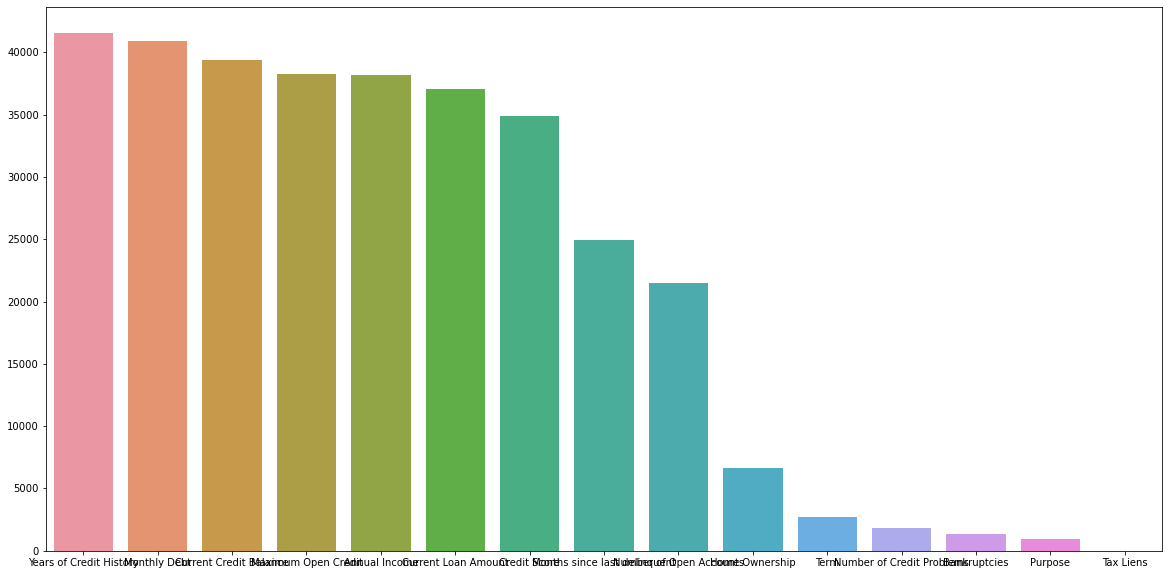

6 наиболее значимых признаков Index(['Years of Credit History', 'Monthly Debt', 'Current Credit Balance',
       'Maximum Open Credit', 'Annual Income', 'Current Loan Amount'],
      dtype='object')


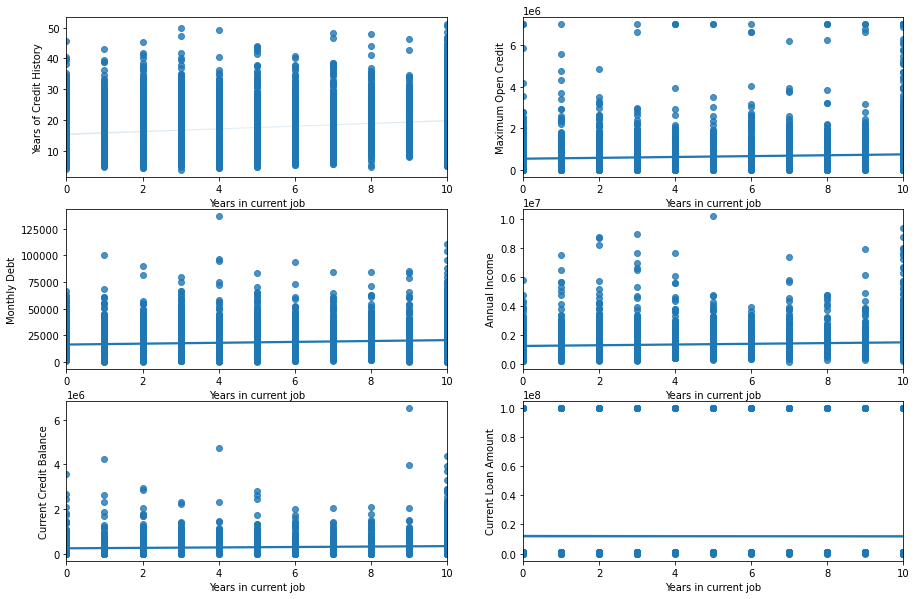

In [82]:
# Не линейная связь Months since last delinquent с другими признаками на основе модели обучения
non_linear_link_for_nan(model,feature,train.drop([target_col[0],feature],axis=1).columns)

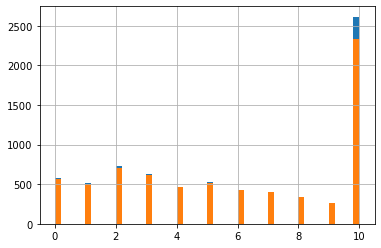

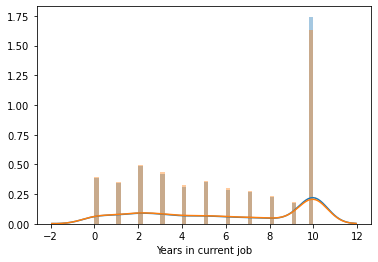

In [83]:
# Сравним до и после изменений
matching_after_changes(train,train_work['1'],feature)

Отработаем Bankruptcies 

In [84]:
feature = 'Bankruptcies' 

Основные статистические показатели
Количество пропусков  - 14
 ------------------------------------------------------------
Значения показателя и их частоты:
0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    7486.000000
mean        0.117152
std         0.347192
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
0    0.714286
1    0.285714
Name: Credit Default, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.718274
1    0.281726
Name: Credit Default, dtype: float64 
 ------------------------------------------------------------
Общая доля целевой переменной:
0    0.71

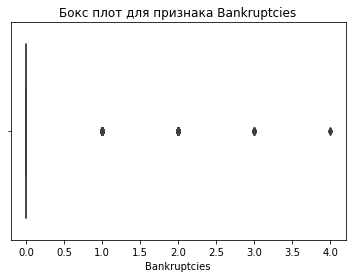

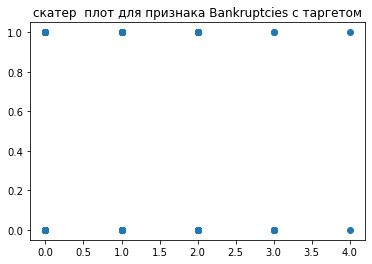

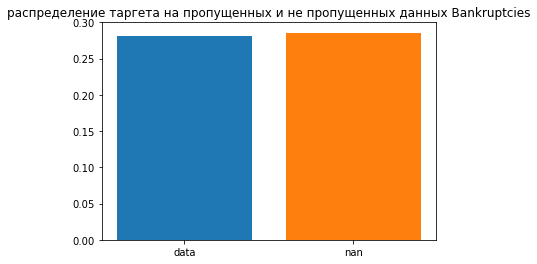

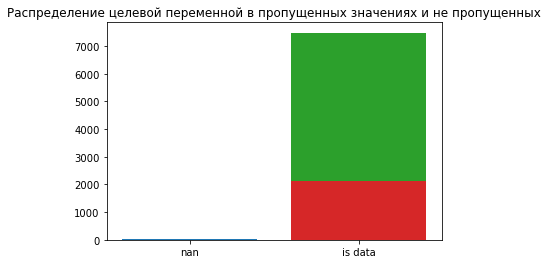

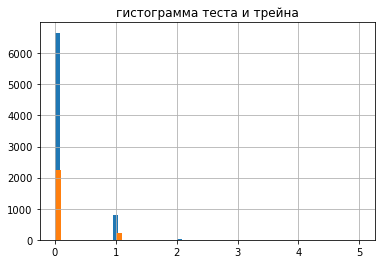

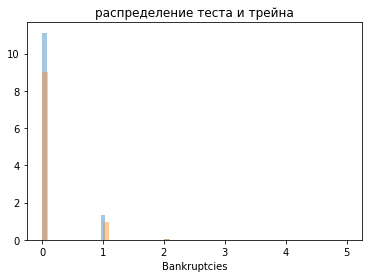

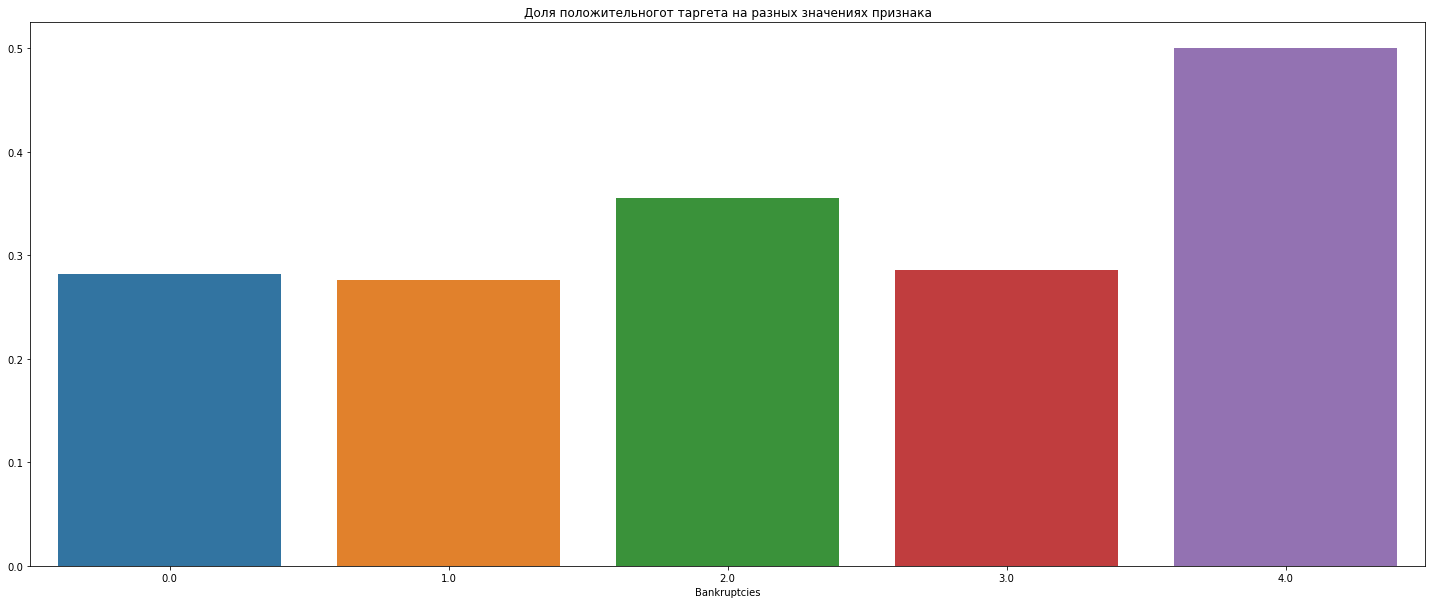

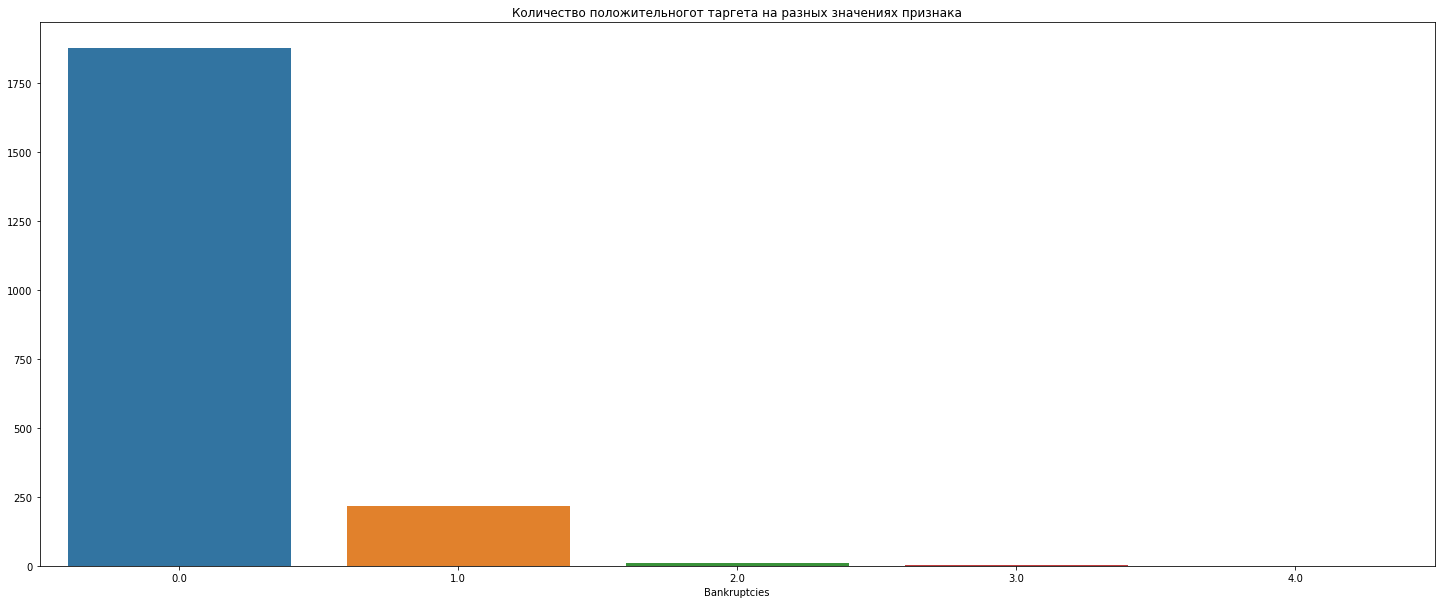

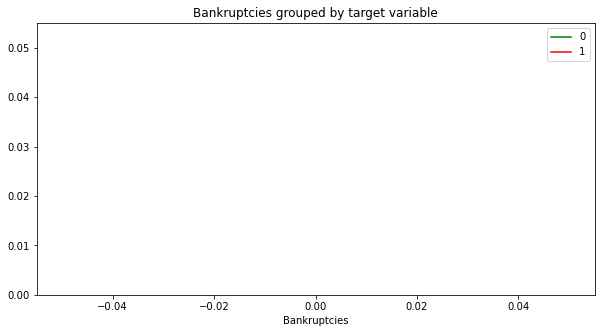

Значения теста Колмогорова-Смирнова (0.0128, 0.9165331645472685)
Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (5686353.0, 0.4567074598086799)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


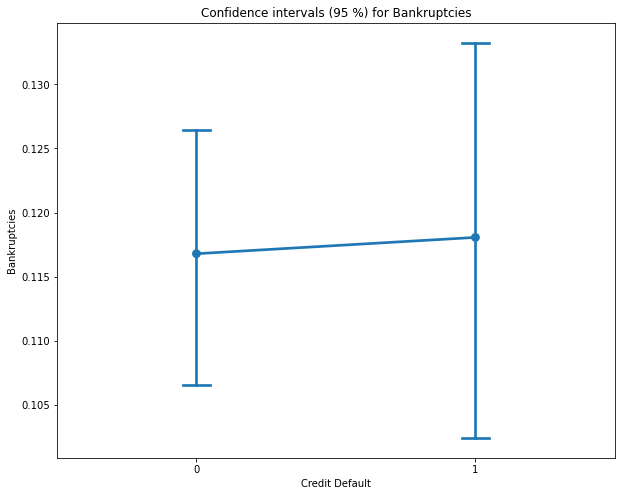

Посмотрим на корреляцию данного признака к другим
Number of Credit Problems       0.730751
Months since last delinquent    0.162710
Years of Credit History         0.085699
Years in current job            0.058089
Tax Liens                       0.057360
Credit Default                  0.001648
Current Loan Amount            -0.005987
Number of Open Accounts        -0.019130
Credit Score                   -0.027488
Annual Income                  -0.066877
Monthly Debt                   -0.079579
Maximum Open Credit            -0.124143
Current Credit Balance         -0.142849
Name: Bankruptcies, dtype: float64


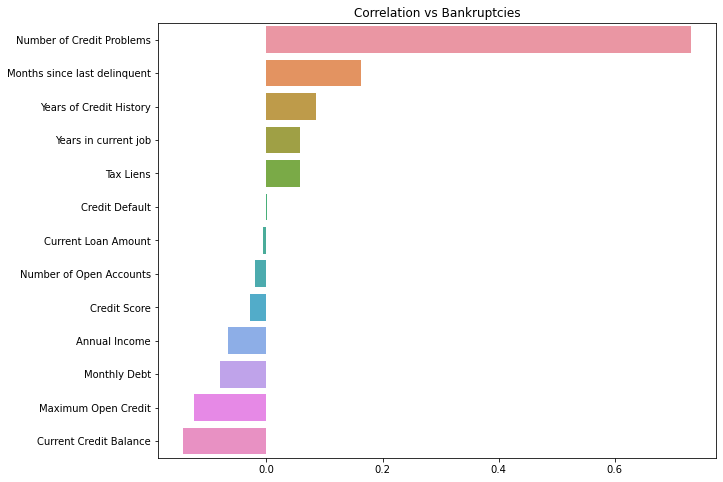

Коэф. Кендала
Number of Credit Problems       0.869222
Months since last delinquent    0.121453
Years of Credit History         0.073993
Tax Liens                       0.068044
Years in current job            0.057170
Credit Default                 -0.001319
Number of Open Accounts        -0.011658
Annual Income                  -0.053962
Monthly Debt                   -0.057146
Credit Score                   -0.057808
Current Loan Amount            -0.062713
Maximum Open Credit            -0.149225
Current Credit Balance         -0.166627
Name: Bankruptcies, dtype: float64


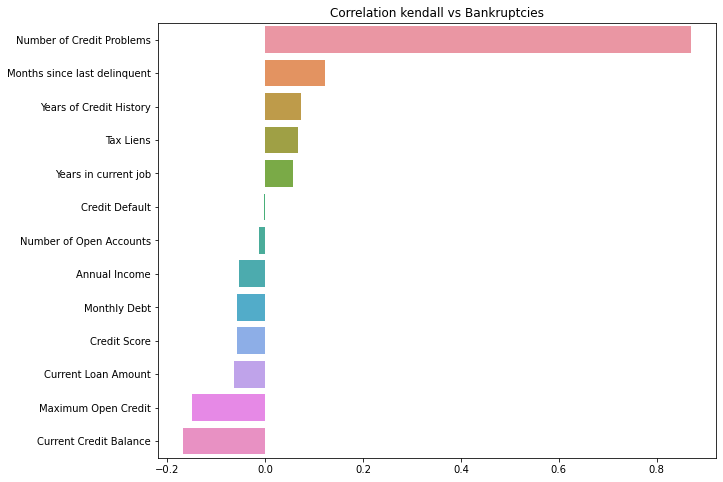

In [85]:
nan_feature_analysis(train,test,feature,target_col[0])

In [86]:
best_distribution_value(train,target_col[0],feature)

(3.0, 0.2857142857142857, 0.0)

Создадим три варианта модели с заменой на 3 и подбором данных через обучение на остальных признака и третий вариант заменим на 999

In [87]:
model,ind,pred = miss_forecast(train.drop(target_col,axis=1),feature,categorical_features)

In [88]:
train_work['1'].loc[ind,feature] = pred
train_work['2'].loc[ind,feature] = 3
train_work['3'].loc[ind,feature]  = 999

In [89]:
_,ind,pred = miss_forecast(test,feature,categorical_features)

In [90]:
test_work['1'].loc[ind,feature] = pred
test_work['2'].loc[ind,feature] = 3
test_work['3'].loc[ind,feature]  = 999

Annual Income                   4118
Years of Credit History         3354
Credit Score                    3301
Current Credit Balance          2808
Maximum Open Credit             2803
Monthly Debt                    2694
Current Loan Amount             2661
Months since last delinquent    2588
Number of Open Accounts         2104
Years in current job            1984
Number of Credit Problems       1596
Home Ownership                   726
Term                             234
Tax Liens                         71
Purpose                            6
dtype: int32


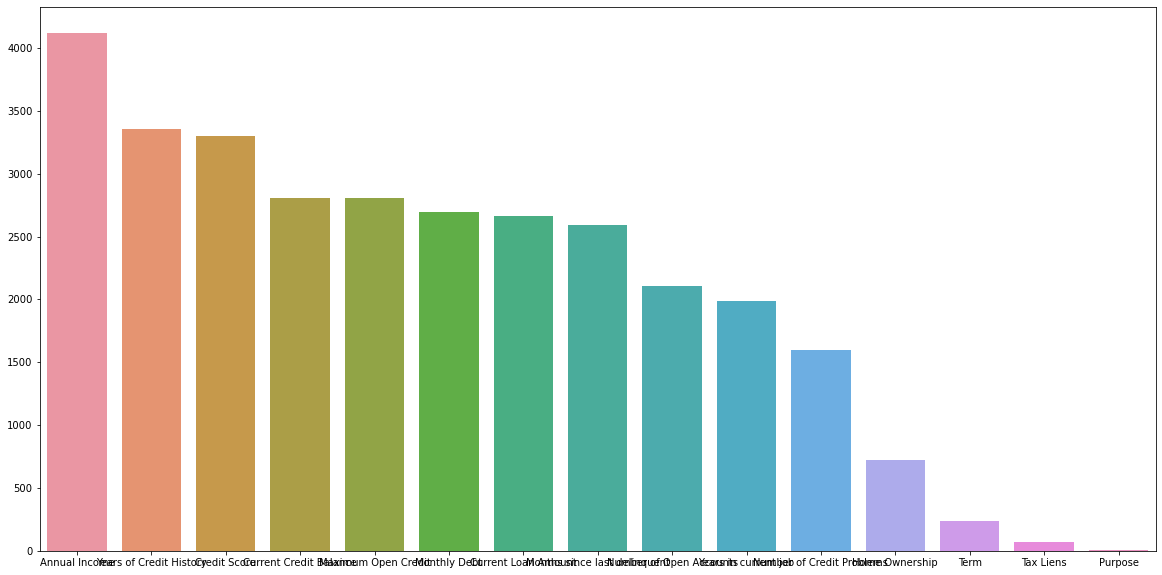

6 наиболее значимых признаков Index(['Annual Income', 'Years of Credit History', 'Credit Score',
       'Current Credit Balance', 'Maximum Open Credit', 'Monthly Debt'],
      dtype='object')


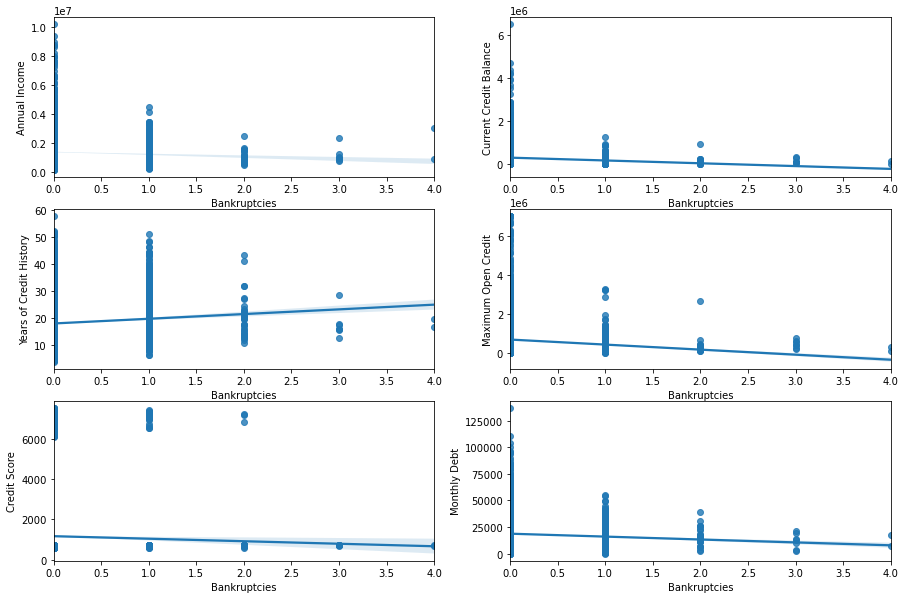

In [91]:
# Не линейная связь Months since last delinquent с другими признаками на основе модели обучения
non_linear_link_for_nan(model,feature,train.drop([target_col[0],feature],axis=1).columns)

Сделаем кодирование категориальных признаков

In [92]:
categorical_features

['Home Ownership', 'Tax Liens', 'Purpose', 'Term']

1. Home Ownership	

In [93]:
feature= 'Home Ownership'

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count              7500
unique                4
top       Home Mortgage
freq               3637
Name: Home Ownership, dtype: object 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: Credit Default, dtype: float64) 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.718267
1    0.281733
Name: Credit Default, dtype: float64 
 ------------------------------------------------------------
Общая доля целевой переменной:
0    0.718267
1    0.281733
Name: Credit Default, dtype: float64 
 

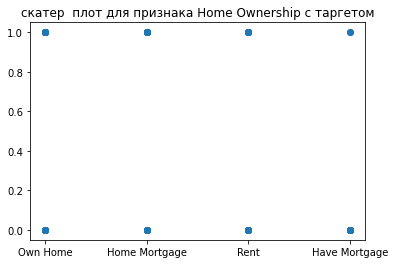

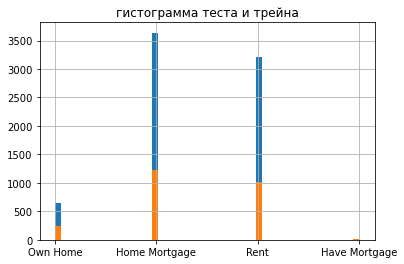

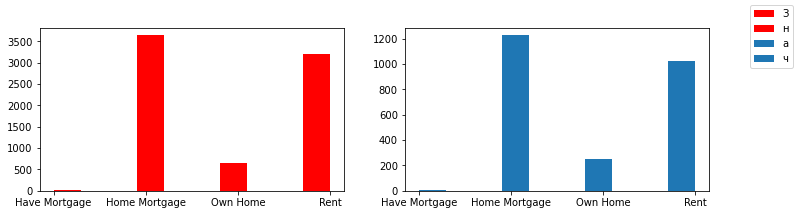

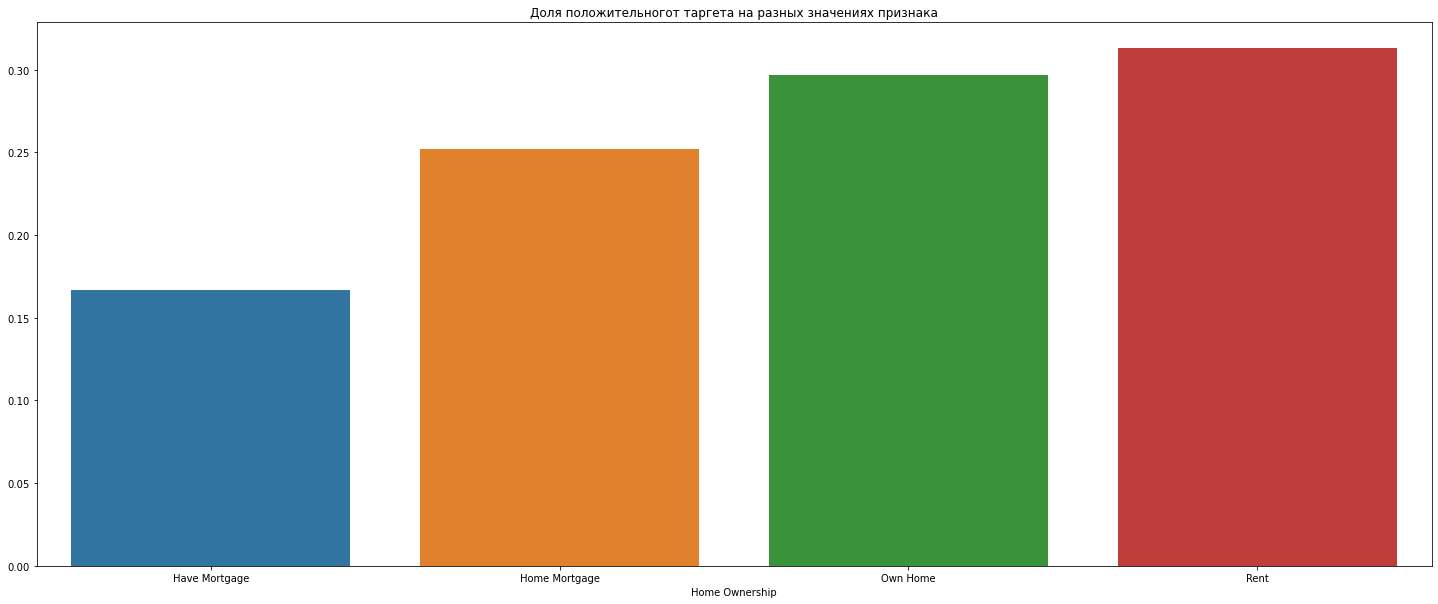

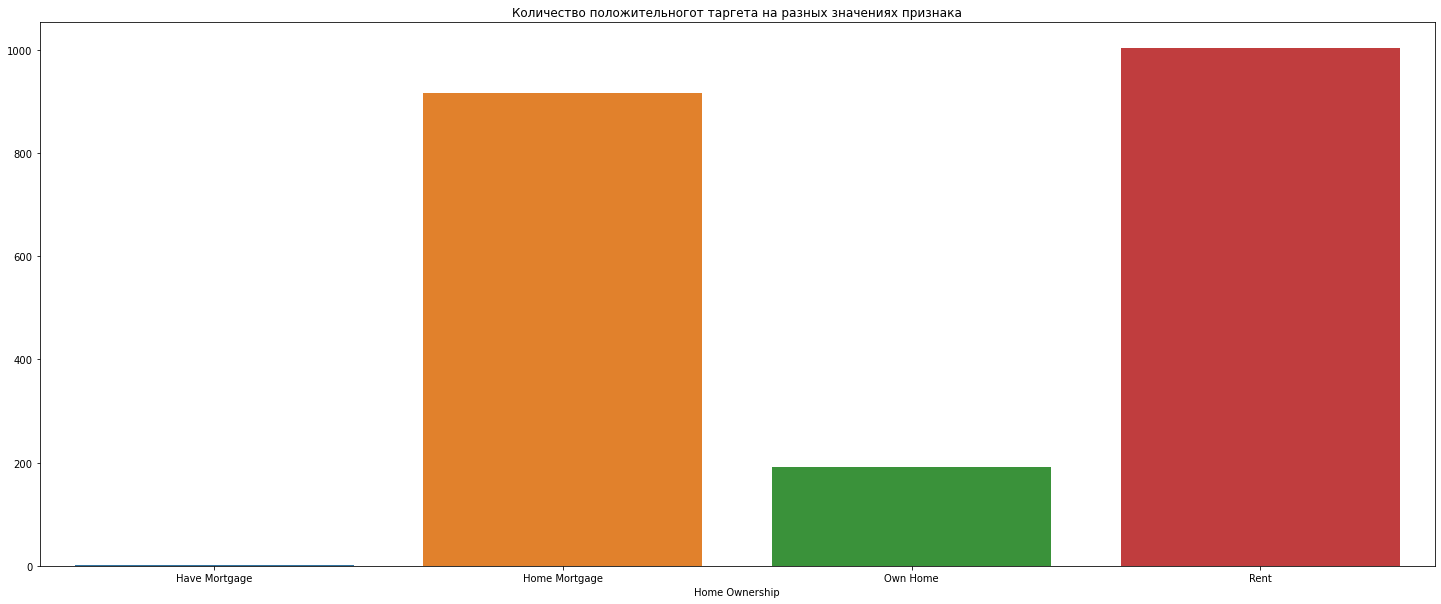

Значения теста Колмогорова-Смирнова (0.0192, 0.49107052748402)
Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (5259951.5, 6.276143967173624e-09)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


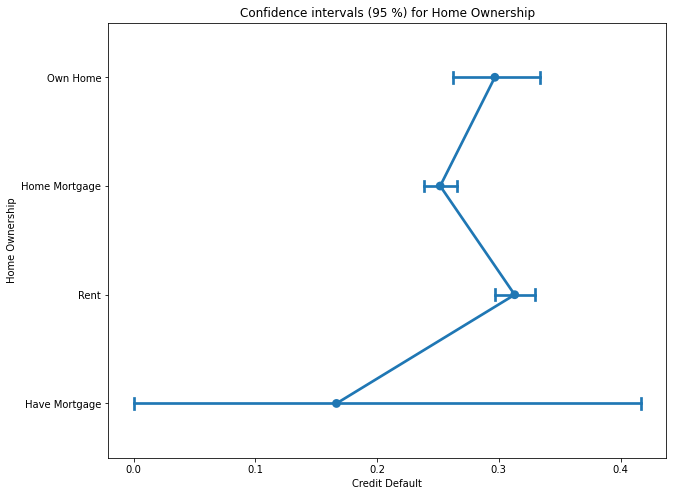

In [94]:
cat_feature_analysis(train,test,feature,target_col[0])

Будем использовать кодирование:
1. label
2. Target 
3. frequency






In [95]:
cat_encoding(train,feature,target_col[0],[train_work,test_work],['1-1','1-2','1-3'],['1','2','3'])

In [96]:
cat_encoding(train,feature,target_col[0],[train_work,test_work],['2-1','2-2','2-3'],['1','2','3'])

In [97]:
cat_encoding(train,feature,target_col[0],[train_work,test_work],['3-1','3-2','3-3'],['1','2','3'])

Tax Liens

In [98]:
feature = 'Tax Liens'

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    7500.000000
mean        0.030133
std         0.271604
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Tax Liens, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: Credit Default, dtype: float64) 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.718267
1    0.281733
Name: Credit Default, dtype: float64 
 ------------------------------------------------------------
Общая доля целевой переменн

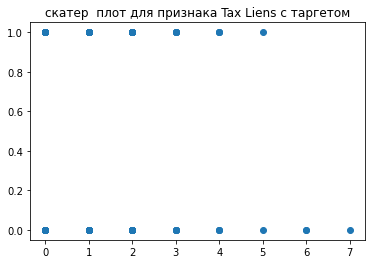

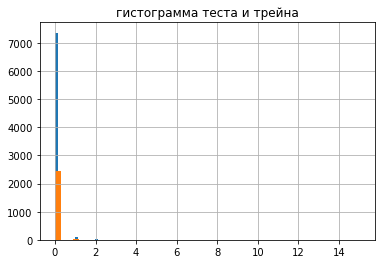

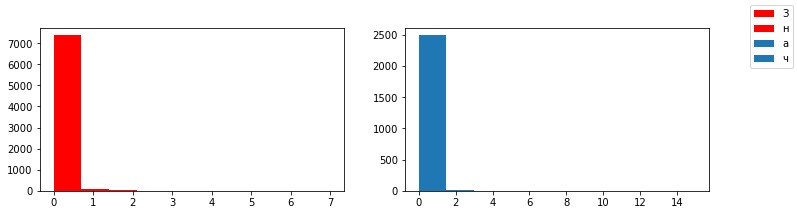

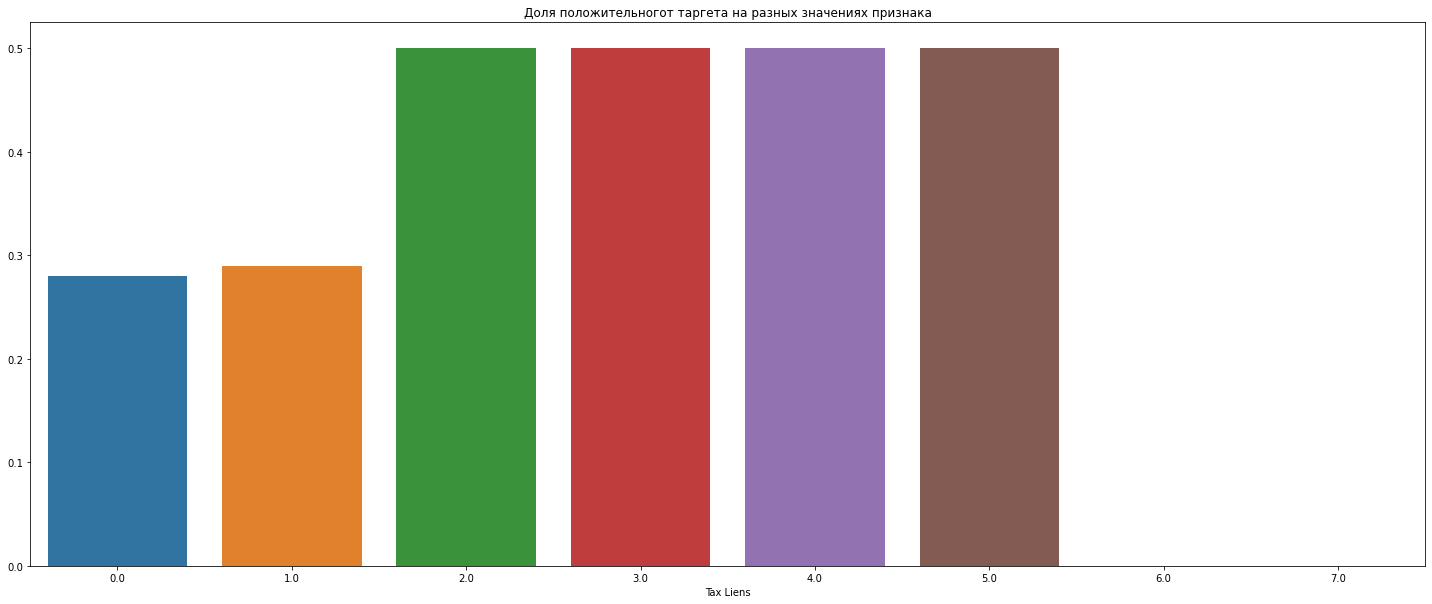

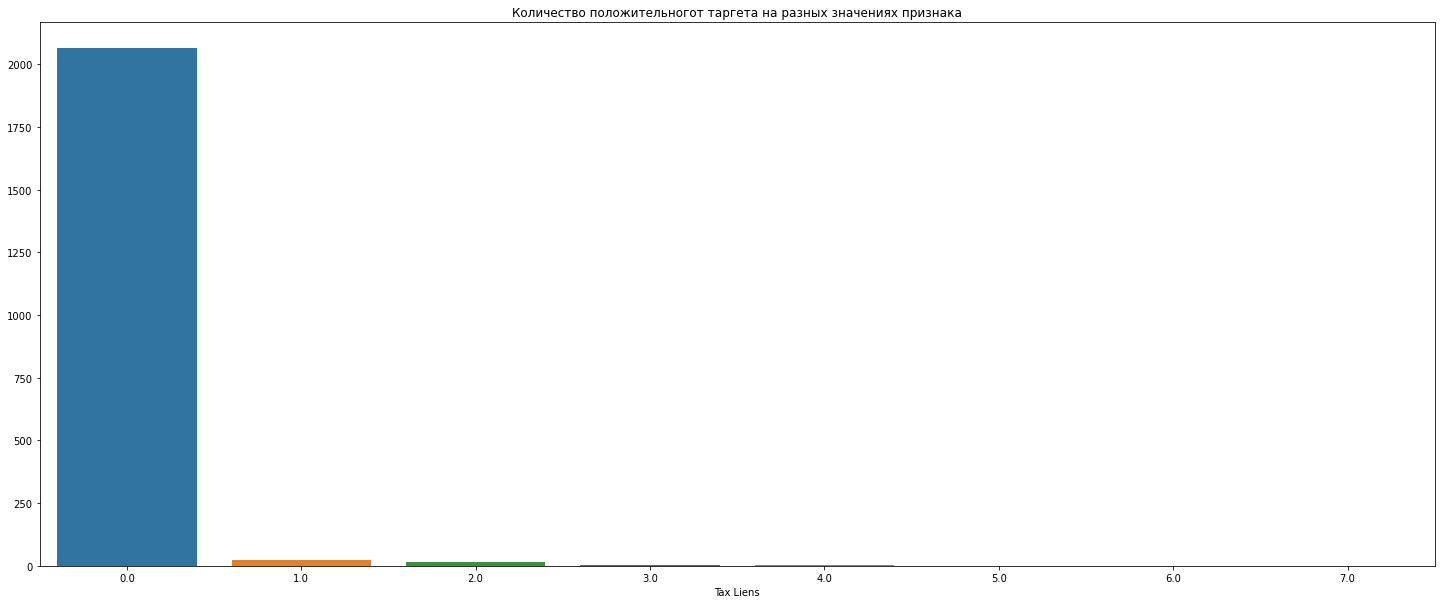

Значения теста Колмогорова-Смирнова (0.0041333333333333335, 0.9999999999999994)
Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (5652588.5, 0.02256138327362573)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


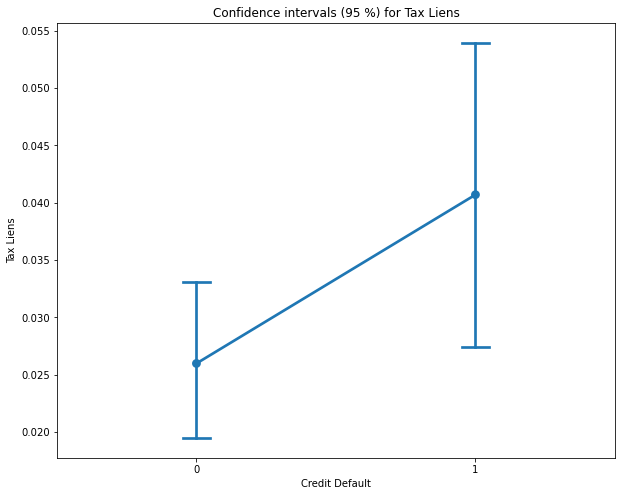

In [99]:
cat_feature_analysis(train,test,feature,target_col[0])

Кодировать его не будем, оставим как есть

'Purpose'

In [100]:
feature = 'Purpose'

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count                   7500
unique                    15
top       debt consolidation
freq                    5944
Name: Purpose, dtype: object 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: Credit Default, dtyp

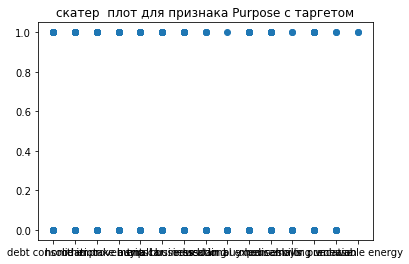

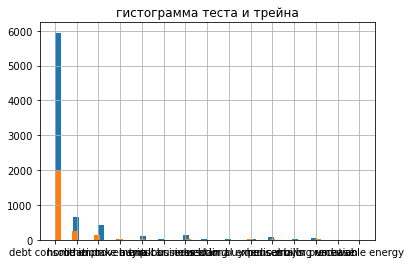

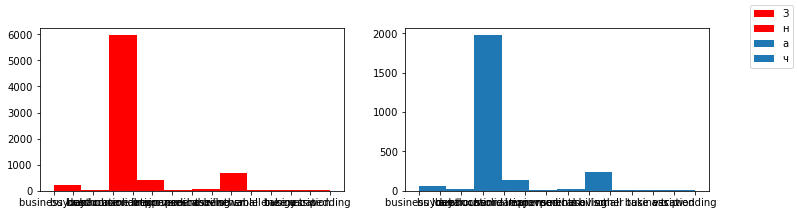

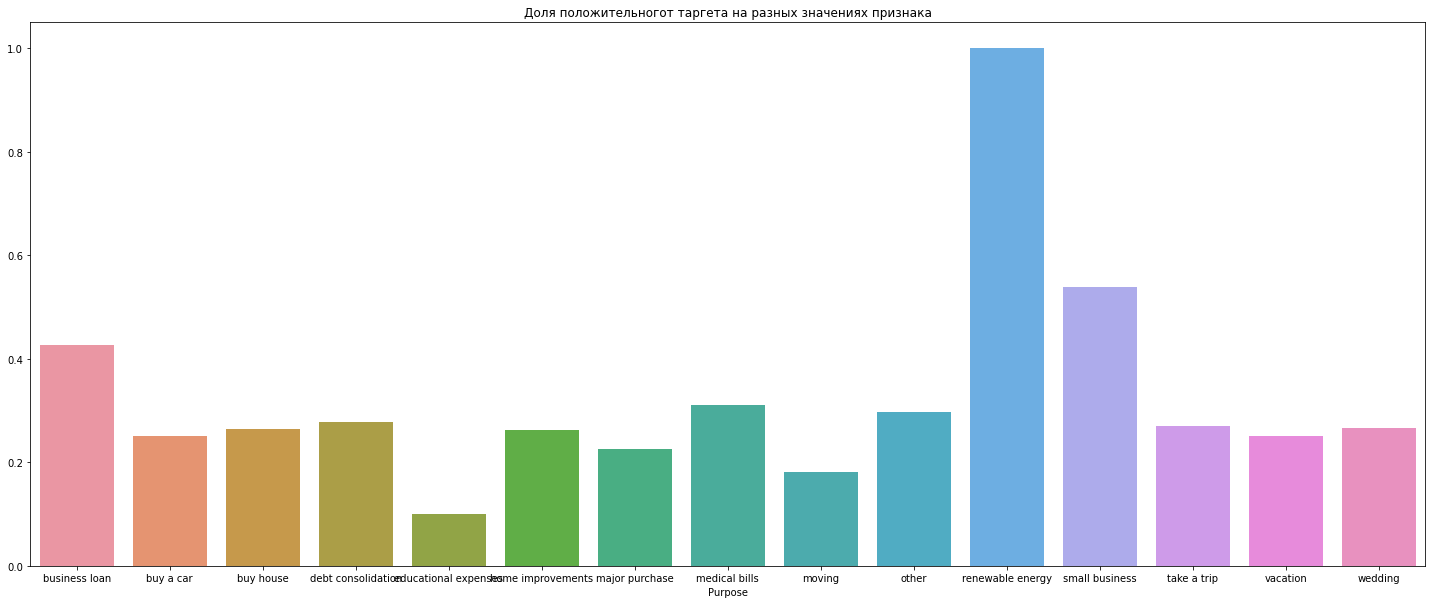

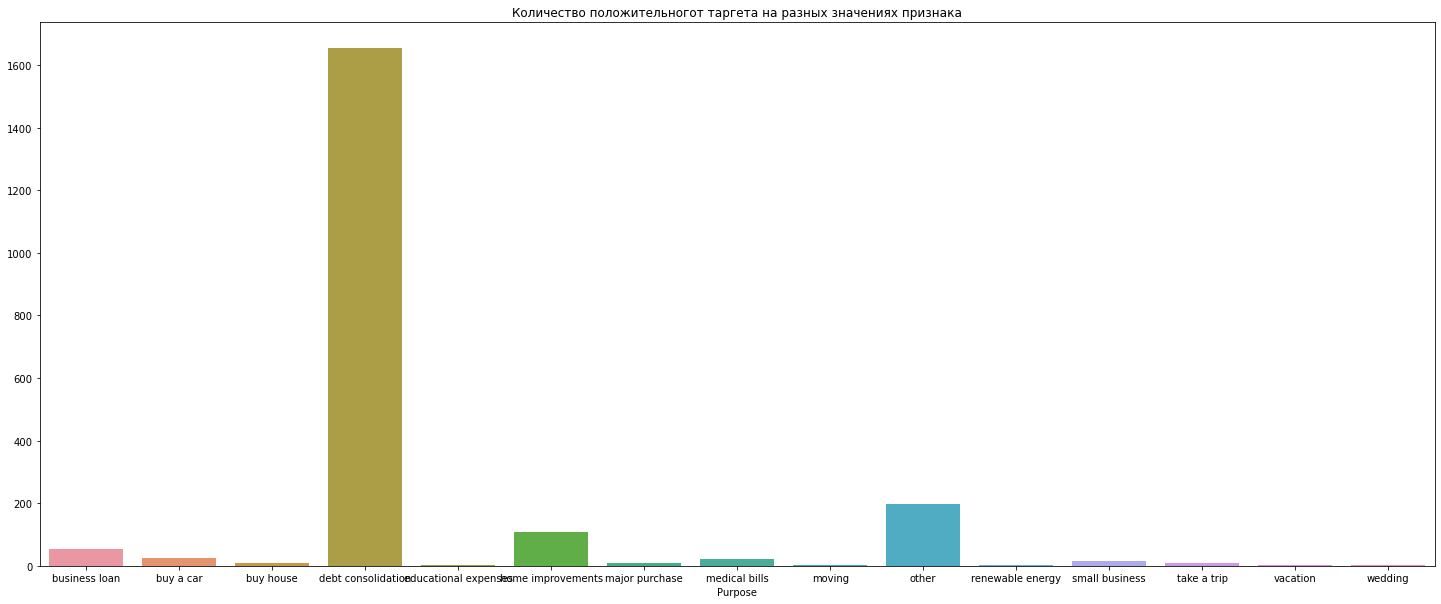

Значения теста Колмогорова-Смирнова (0.0054666666666666665, 0.9999999959881917)
Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (5674804.5, 0.3907824877430847)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


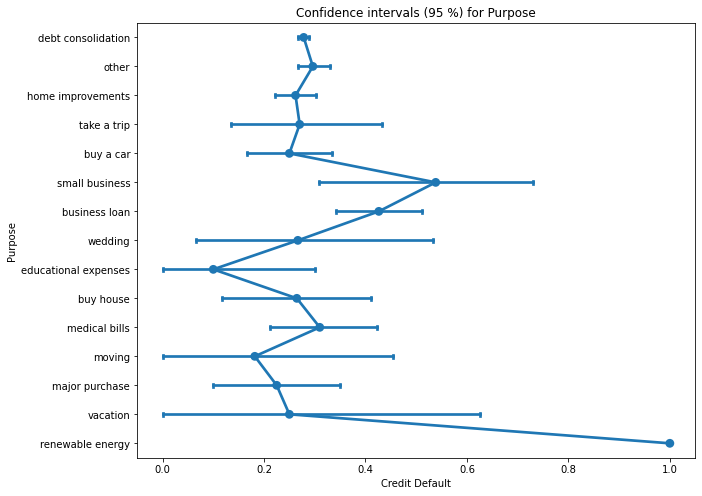

In [101]:
cat_feature_analysis(train,test,feature,target_col[0])

Сделаем кодирование

In [102]:
cat_encoding(train,feature,target_col[0],[train_work,test_work],['1-1','1-2','1-3'],['1-1','1-2','1-3'])
cat_encoding(train,feature,target_col[0],[train_work,test_work],['2-1','2-2','2-3'],['2-1','2-2','2-3'])
cat_encoding(train,feature,target_col[0],[train_work,test_work],['3-1','3-2','3-3'],['3-1','3-2','3-3'])

Term

In [103]:
feature = 'Term'

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
Short Term    5556
Long Term     1944
Name: Term, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count           7500
unique             2
top       Short Term
freq            5556
Name: Term, dtype: object 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: Credit Default, dtype: float64) 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.718267
1    0.281733
Name: Credit Default, dtype: float64 
 ------------------------------------------------------------
Общая доля целевой переменной:
0    0.718267
1    0.281733
Name: Credit Default, dtype: float64 
 ------------------------------------------------------------


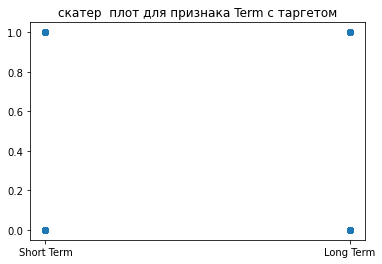

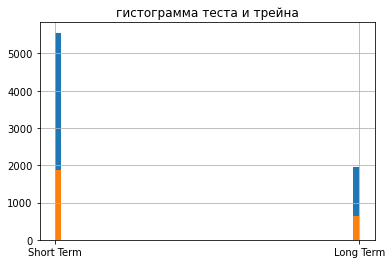

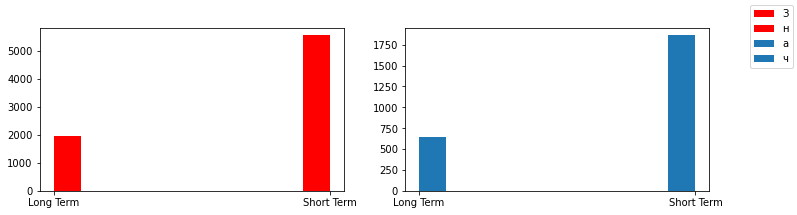

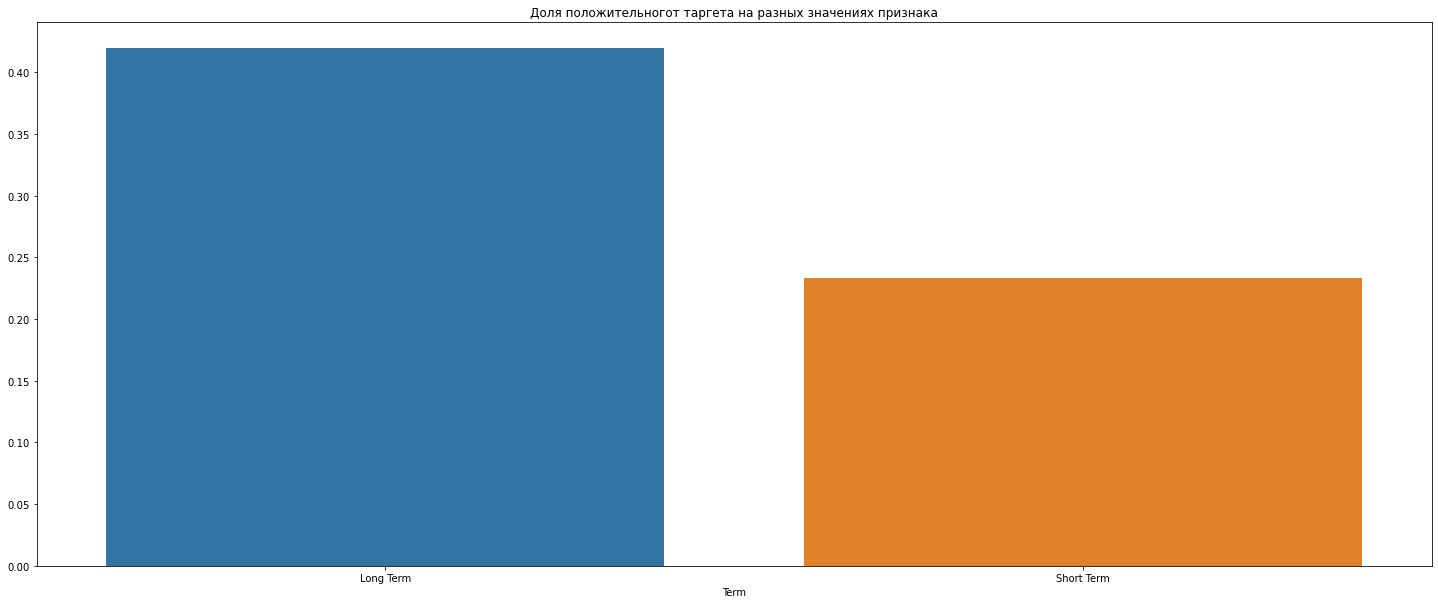

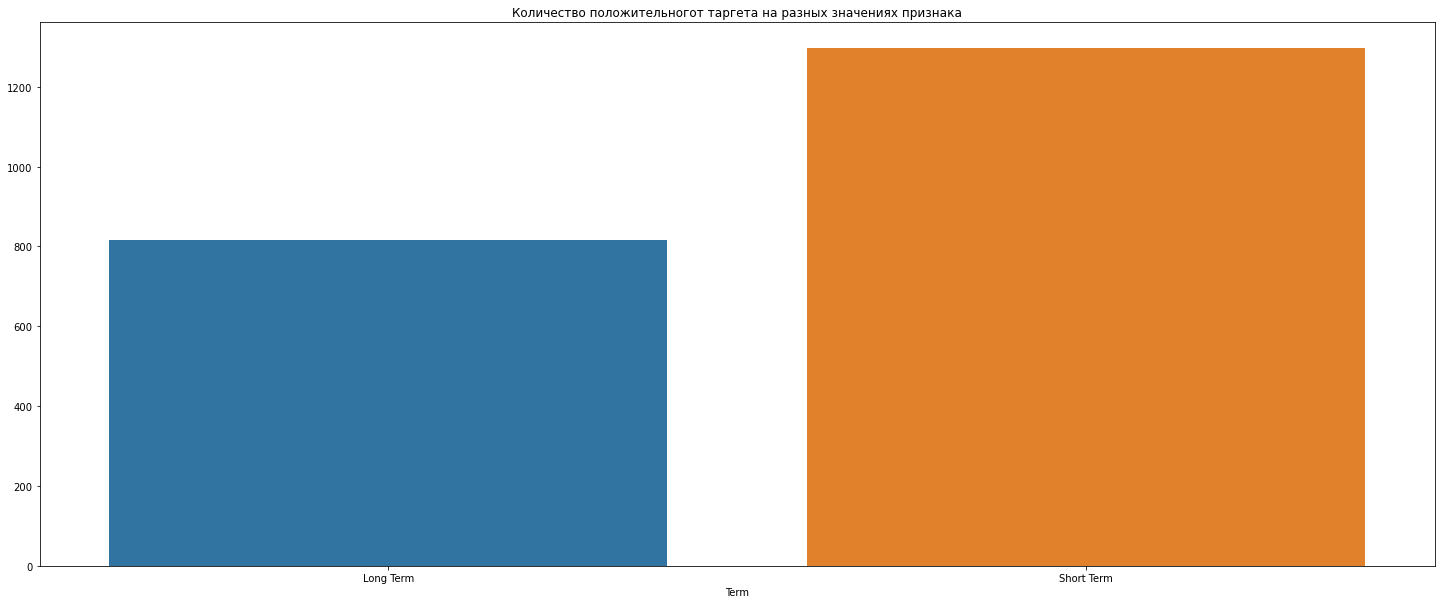

Значения теста Колмогорова-Смирнова (0.0036, 1.0)
Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (4685201.5, 5.856436596201763e-56)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


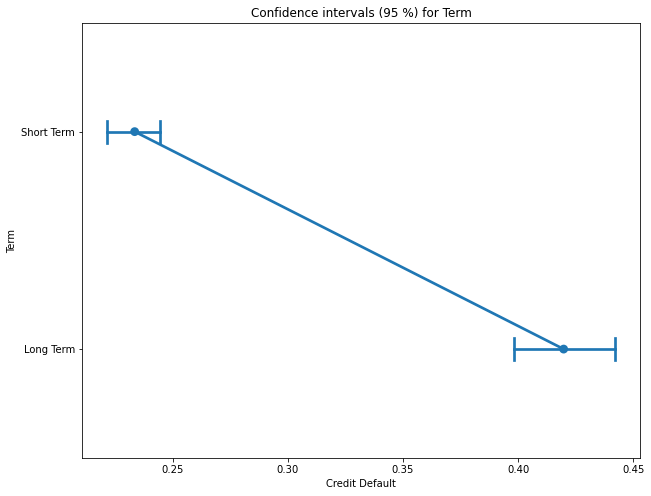

In [104]:
cat_feature_analysis(train,test,feature,target_col[0])

Закодируем

In [105]:
cat_encoding(train,feature,target_col[0],[train_work,test_work],['1-1','1-2','1-3'],['1-1','1-2','1-3'])
cat_encoding(train,feature,target_col[0],[train_work,test_work],['2-1','2-2','2-3'],['2-1','2-2','2-3'])
cat_encoding(train,feature,target_col[0],[train_work,test_work],['3-1','3-2','3-3'],['3-1','3-2','3-3'])

Мера взаимосвязи между двумя категориальными переменными — коэффициент V Крамера

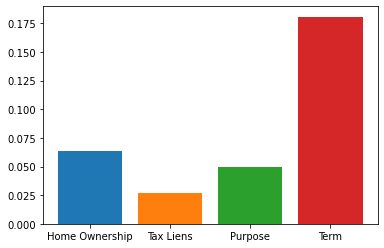

In [106]:
for i in categorical_features:
    mat = pd.crosstab(train_work['1-1'][i],train_work['1-1'][target_col[0]])
    plt.bar(i,cramers_v(mat))
plt.show()    
    
    
    

Рассмотрим остальные признаки

Number of Open Accounts

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      2
43.0      1
35.0      1
41.0      1
38.0      1
42.0      1
Name: Number of Open Accounts, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    7500.000000
mean       11.130933
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64 
 -----------------------------

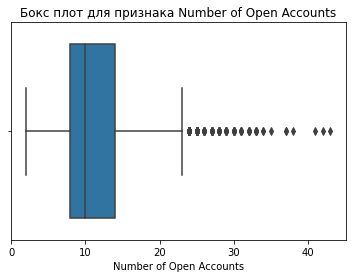

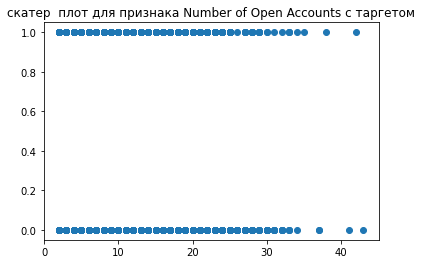

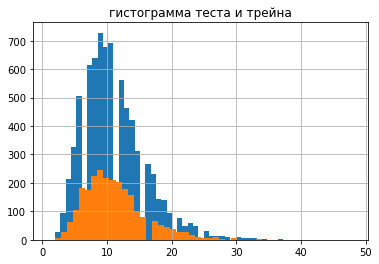

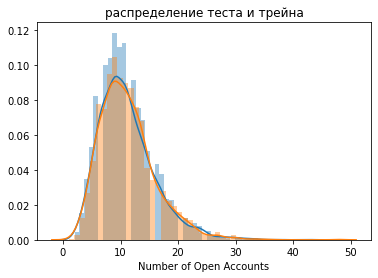

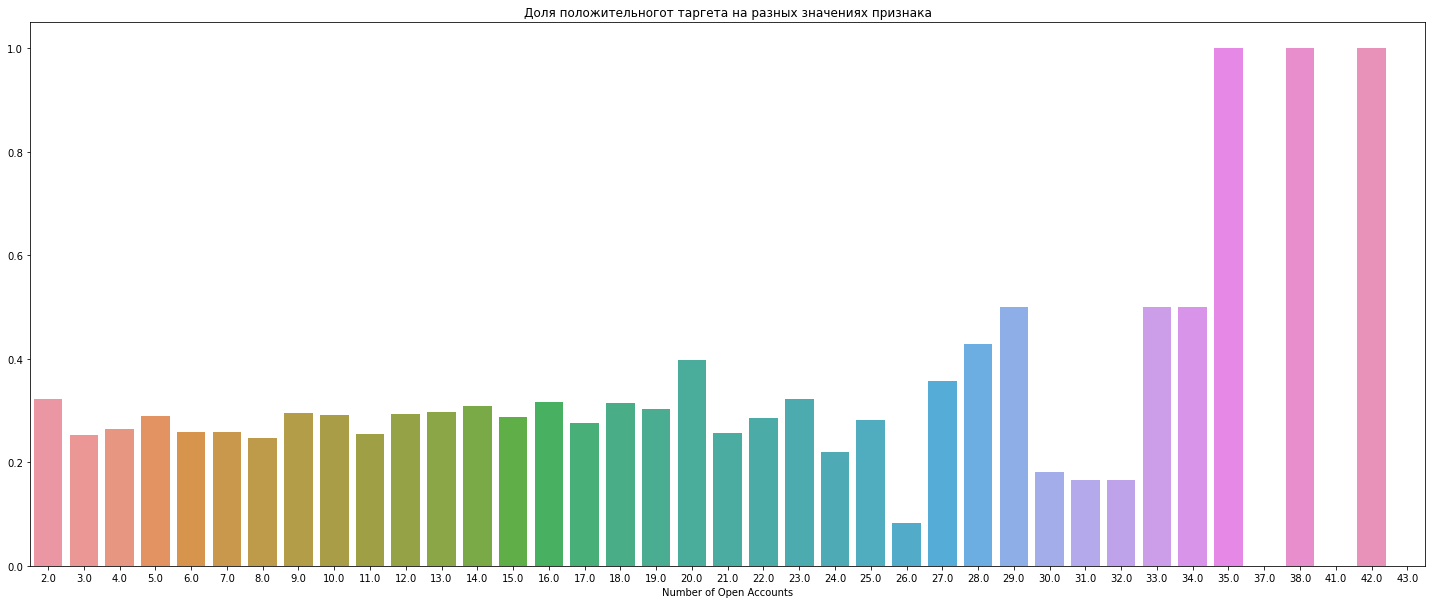

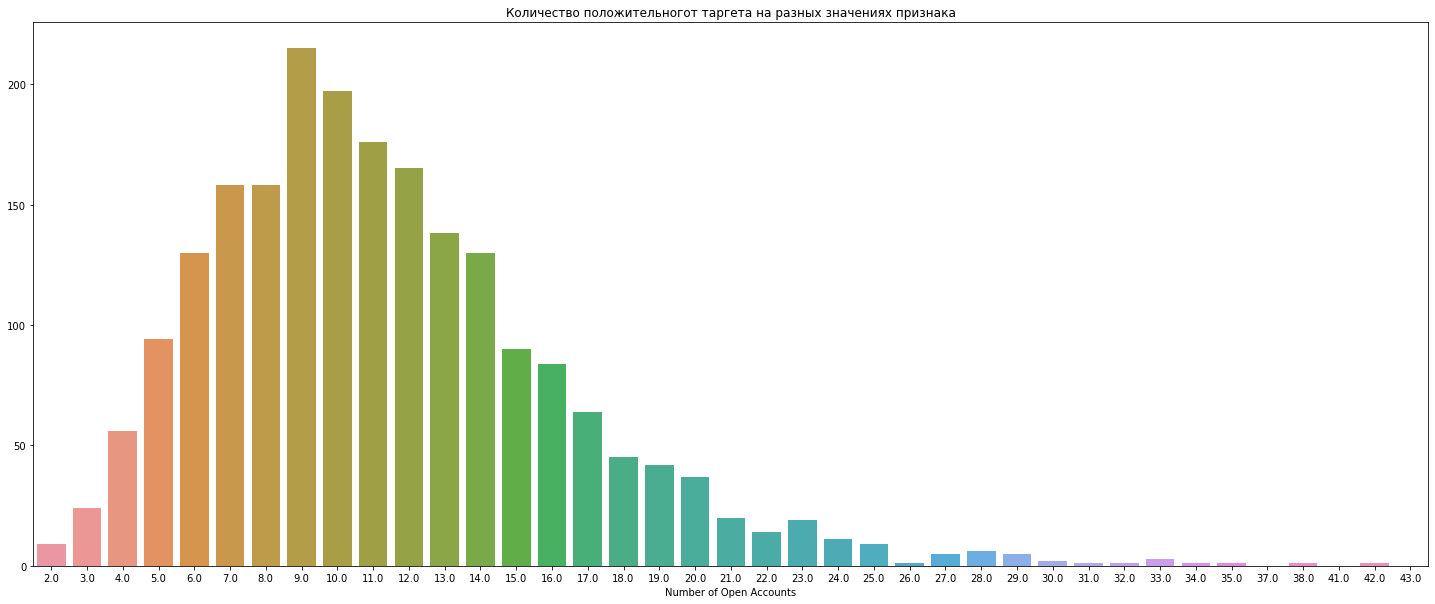

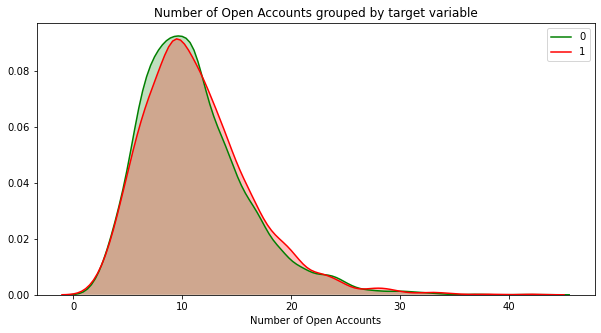

Значения теста Колмогорова-Смирнова (0.0168, 0.6619915189806798)
Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (5466480.0, 0.003761646078803518)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


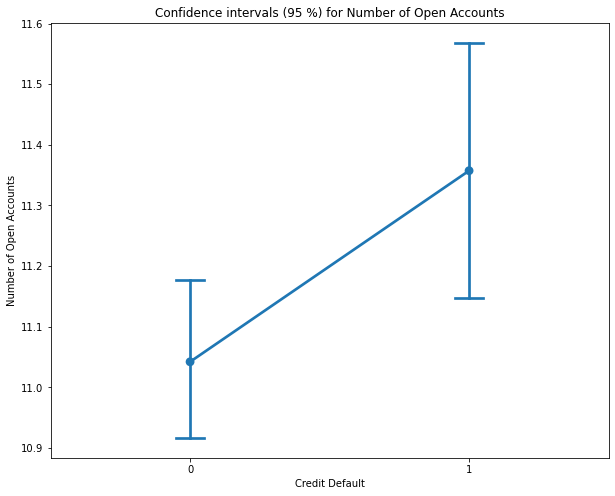

Посмотрим на корреляцию данного признака к другим
Monthly Debt                    0.413904
Maximum Open Credit             0.332023
Current Credit Balance          0.267325
Annual Income                   0.188524
Years of Credit History         0.144819
Years in current job            0.055124
Credit Default                  0.028884
Credit Score                    0.016095
Current Loan Amount             0.001346
Tax Liens                      -0.005360
Number of Credit Problems      -0.017813
Bankruptcies                   -0.019130
Months since last delinquent   -0.032740
Name: Number of Open Accounts, dtype: float64


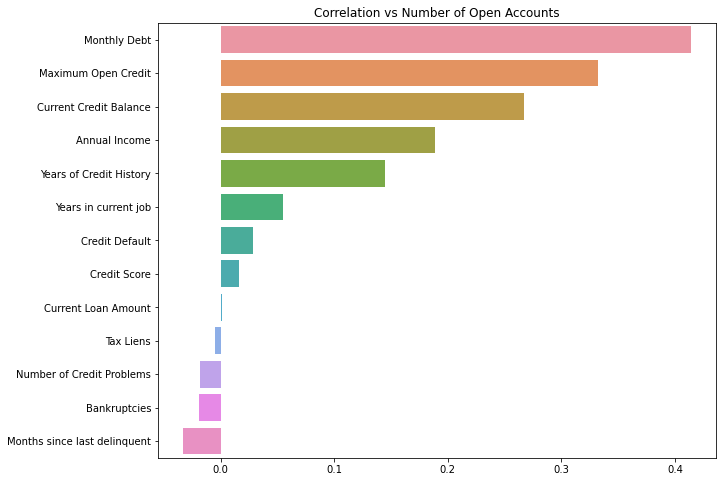

Коэф. Кендала
Maximum Open Credit             0.339757
Monthly Debt                    0.324219
Current Credit Balance          0.260005
Annual Income                   0.164784
Current Loan Amount             0.124711
Years of Credit History         0.107759
Years in current job            0.045375
Credit Default                  0.025997
Tax Liens                      -0.005226
Number of Credit Problems      -0.008421
Bankruptcies                   -0.011658
Credit Score                   -0.013987
Months since last delinquent   -0.026767
Name: Number of Open Accounts, dtype: float64


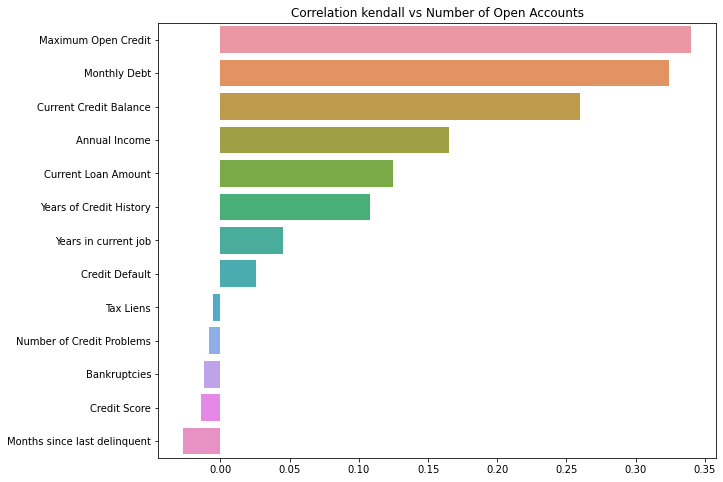

In [107]:
feature = 'Number of Open Accounts'
feature_analysis(train,test,feature,target_col[0])

Years of Credit History

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
43.2      1
4.9       1
39.5      1
42.4      1
39.8      1
Name: Years of Credit History, Length: 408, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    7500.000000
mean       18.317467
std         7.041946
min         4.000000
25%        13.500000
50%        17.000000
75%        21.800000
max        57.700000
Name: Years of Credit History, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: Credit Default, dtype: float64) 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.718267
1    0.281733
Name: Credit Default, dtype: float64 
 -----------

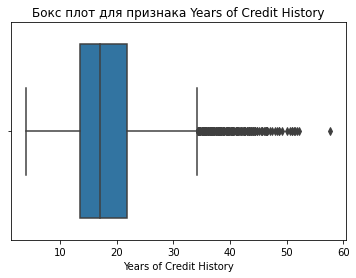

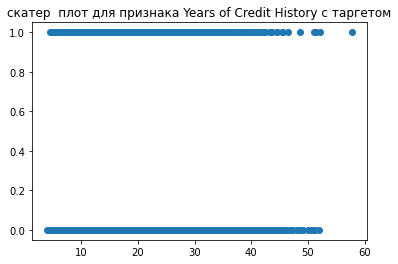

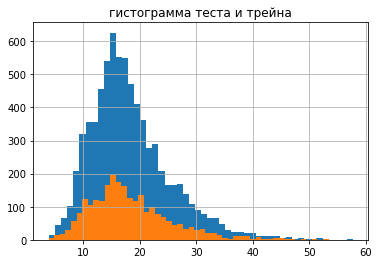

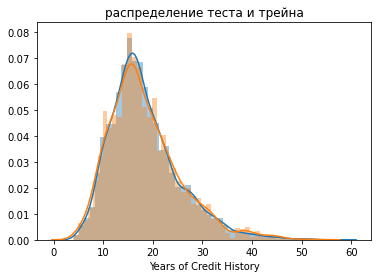

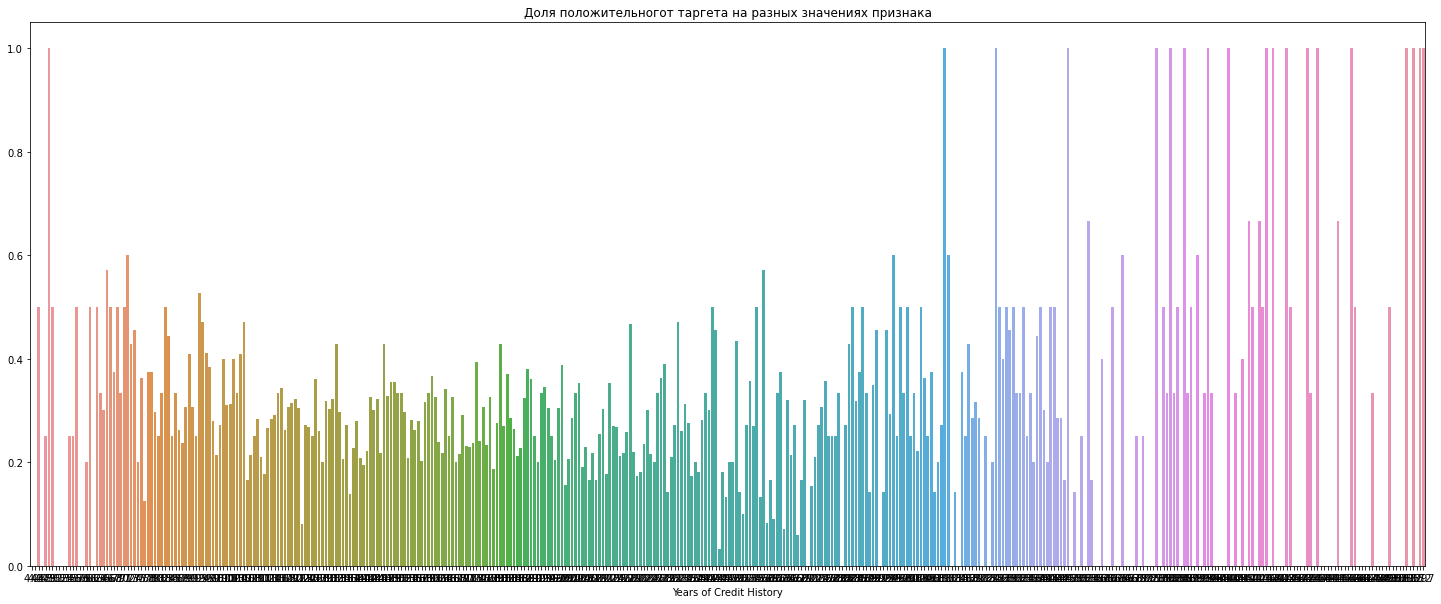

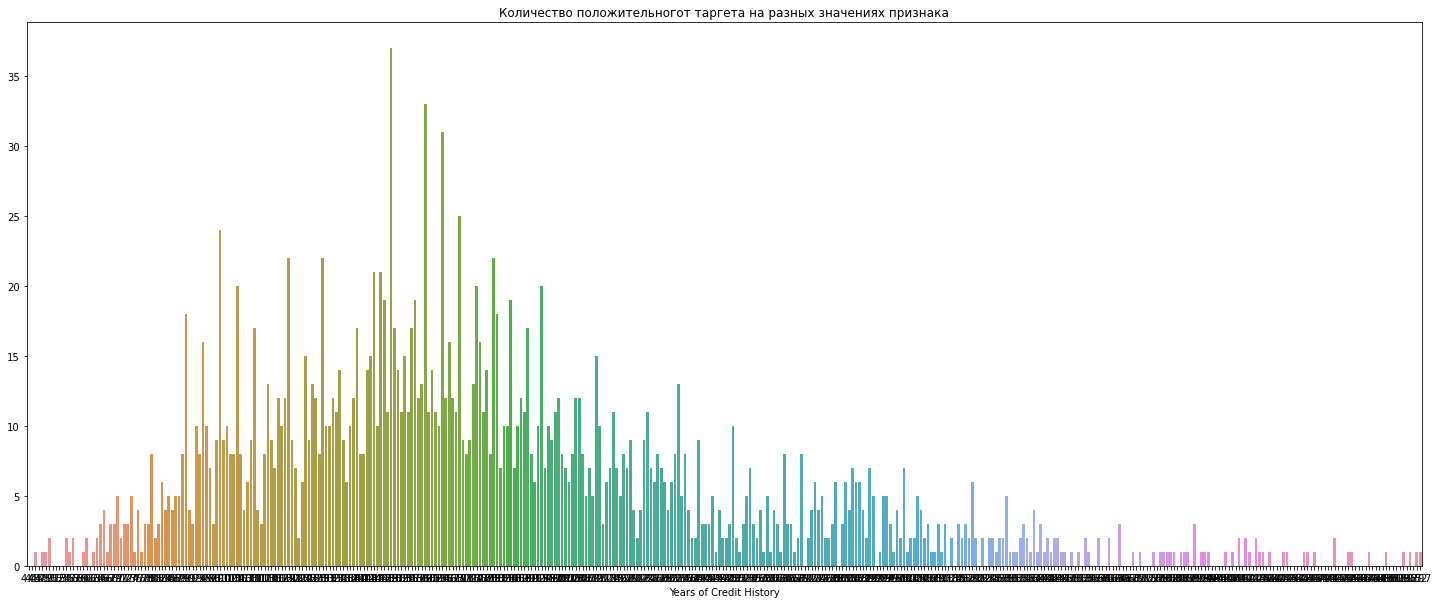

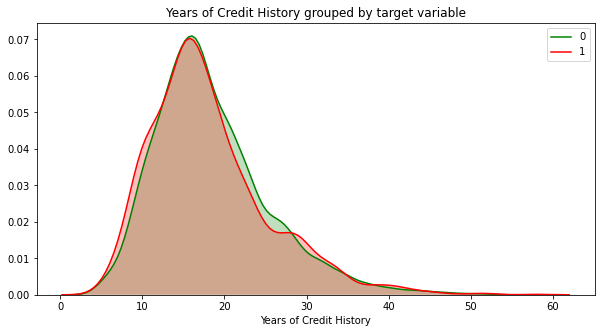

Значения теста Колмогорова-Смирнова (0.0168, 0.6619915189806798)
Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (5461129.5, 0.003171215731103466)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


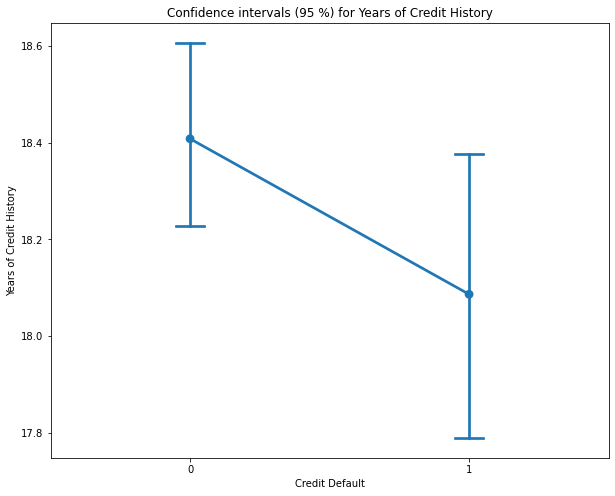

Посмотрим на корреляцию данного признака к другим
Years in current job            0.233286
Maximum Open Credit             0.228467
Current Credit Balance          0.217856
Monthly Debt                    0.191978
Annual Income                   0.186531
Number of Open Accounts         0.144819
Bankruptcies                    0.085699
Number of Credit Problems       0.071259
Current Loan Amount             0.010623
Tax Liens                       0.009109
Months since last delinquent   -0.015375
Credit Score                   -0.015683
Credit Default                 -0.020567
Name: Years of Credit History, dtype: float64


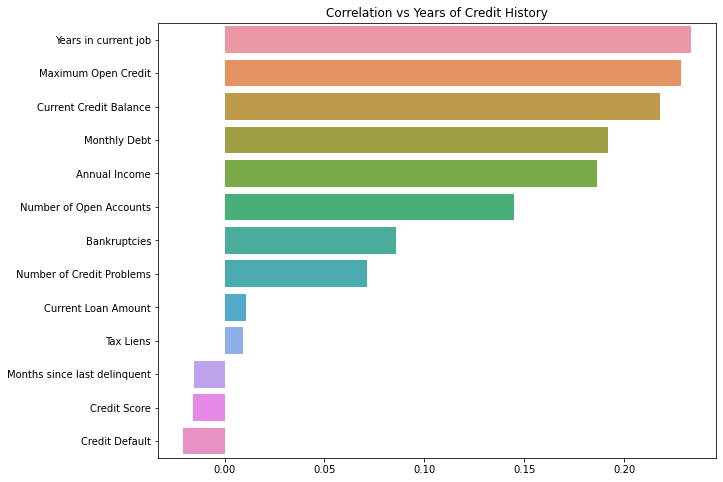

Коэф. Кендала
Maximum Open Credit             0.194809
Years in current job            0.186524
Current Credit Balance          0.176226
Annual Income                   0.175359
Monthly Debt                    0.150542
Number of Open Accounts         0.107759
Current Loan Amount             0.094082
Bankruptcies                    0.073993
Number of Credit Problems       0.072750
Credit Score                    0.040975
Tax Liens                       0.018346
Months since last delinquent   -0.017340
Credit Default                 -0.025803
Name: Years of Credit History, dtype: float64


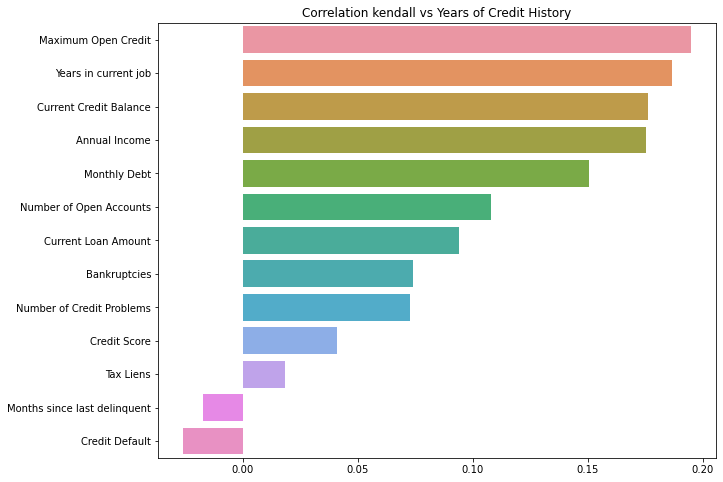

In [108]:
feature = 'Years of Credit History'
feature_analysis(train,test,feature,target_col[0])

Maximum Open Credit

Ограничим слишком большие значения

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
0.0          65
7000000.0    30
319110.0      5
513524.0      3
727958.0      3
             ..
50820.0       1
2219844.0     1
534600.0      1
1026124.0     1
1163008.0     1
Name: Maximum Open Credit, Length: 6934, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    7.500000e+03
mean     6.574168e+05
std      7.215049e+05
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      7.000000e+06
Name: Maximum Open Credit, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: Credit Default, dtype: float64) 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.718267
1    0.281733
Name:

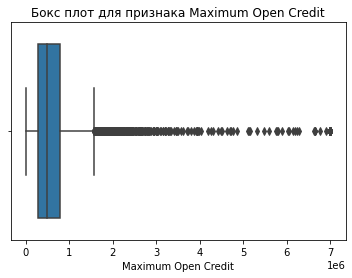

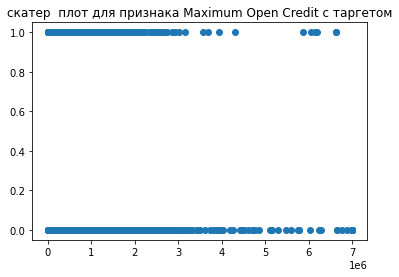

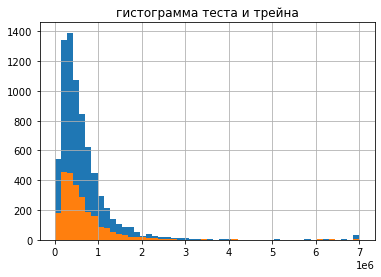

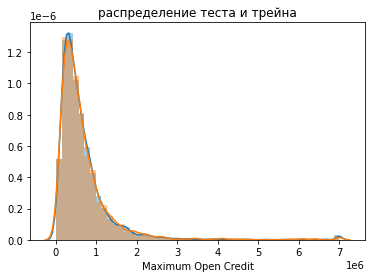

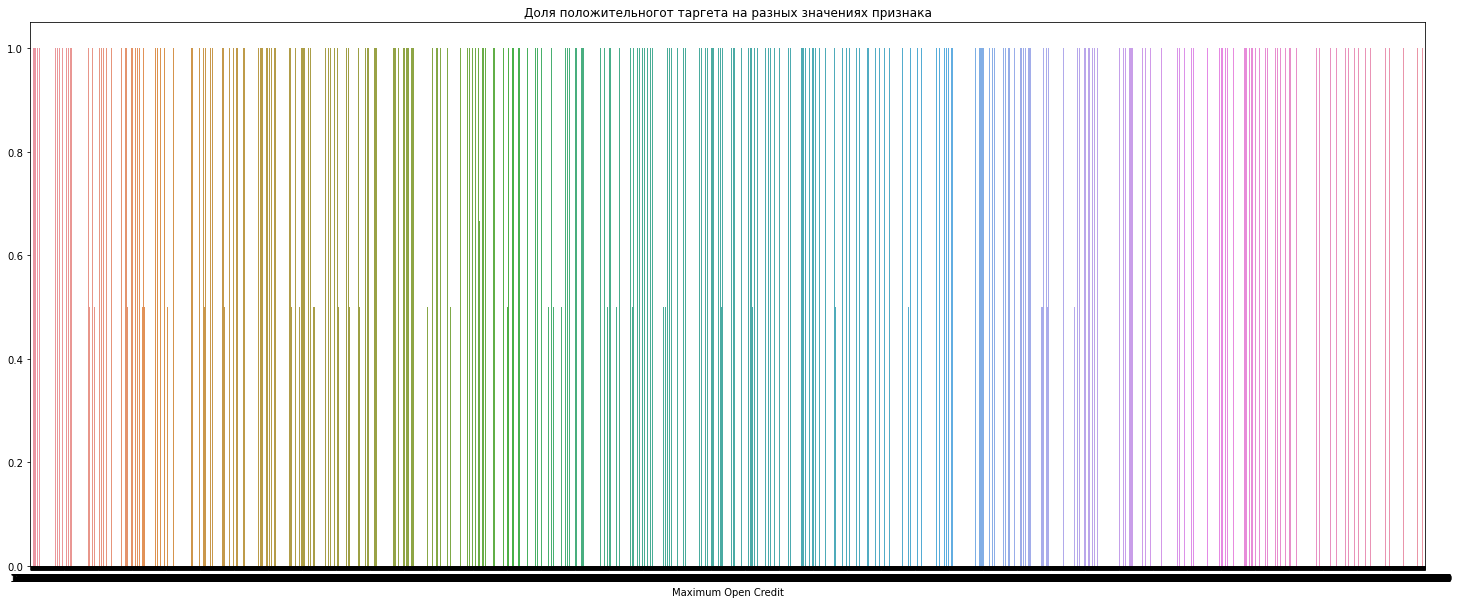

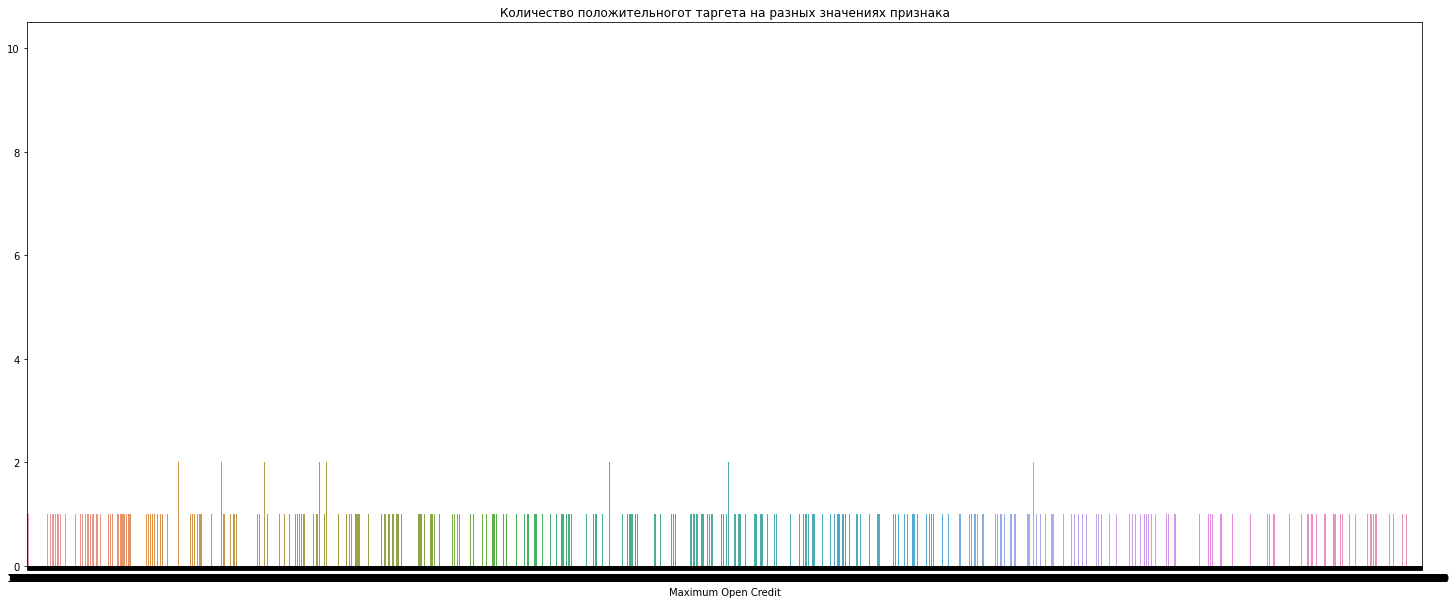

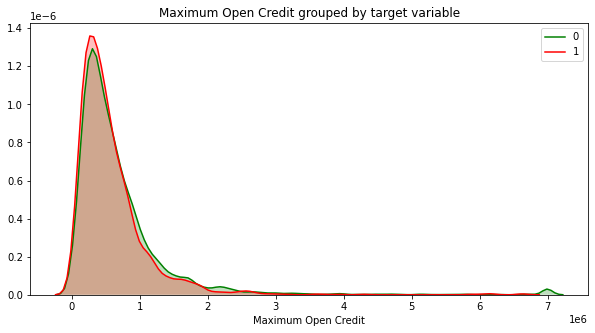

Значения теста Колмогорова-Смирнова (0.011466666666666667, 0.9649695267542777)
Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (5230602.0, 2.3483581043691246e-08)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


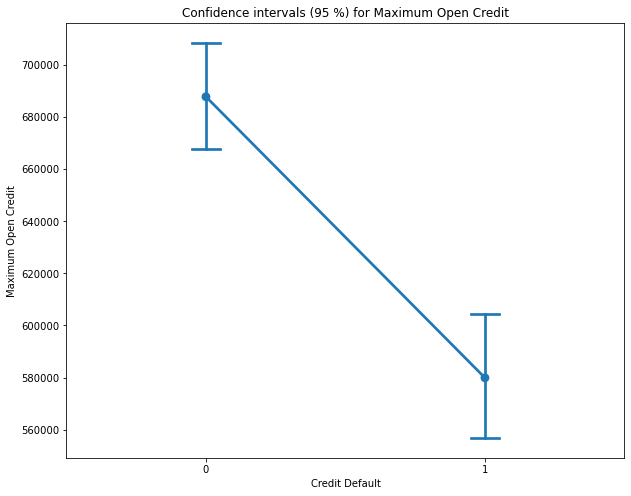

Посмотрим на корреляцию данного признака к другим
Current Credit Balance          0.769682
Monthly Debt                    0.358984
Number of Open Accounts         0.332023
Annual Income                   0.323672
Years of Credit History         0.228467
Years in current job            0.105162
Current Loan Amount             0.035924
Tax Liens                      -0.009274
Credit Score                   -0.026116
Months since last delinquent   -0.049261
Credit Default                 -0.067293
Number of Credit Problems      -0.107795
Bankruptcies                   -0.124143
Name: Maximum Open Credit, dtype: float64


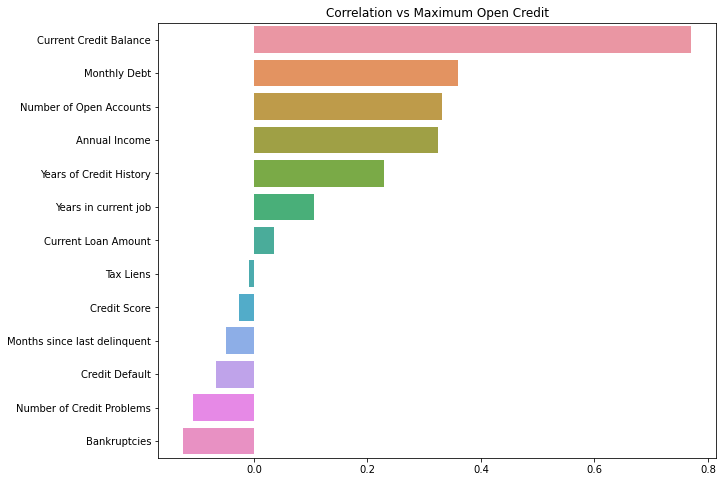

Коэф. Кендала
Current Credit Balance          0.603016
Number of Open Accounts         0.339757
Monthly Debt                    0.296326
Annual Income                   0.270076
Current Loan Amount             0.254338
Years of Credit History         0.194809
Credit Score                    0.102776
Years in current job            0.097286
Tax Liens                      -0.013245
Months since last delinquent   -0.034142
Credit Default                 -0.051510
Bankruptcies                   -0.149225
Number of Credit Problems      -0.151100
Name: Maximum Open Credit, dtype: float64


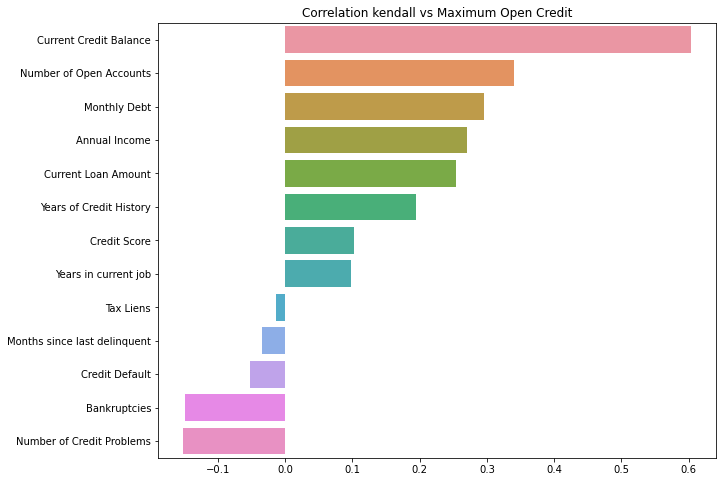

In [109]:
feature = 'Maximum Open Credit'
feature_analysis(train,test,feature,target_col[0])

Number of Credit Problems

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    7500.000000
mean        0.170000
std         0.498598
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Number of Credit Problems, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: Credit Default, dtype: float64) 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.718267
1    0.281733
Name: Credit Default, dtype: float64 
 --------------------------------------------------------

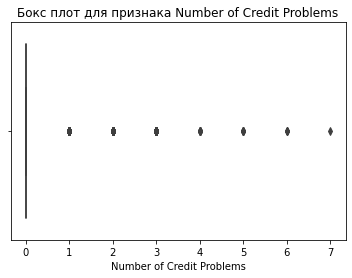

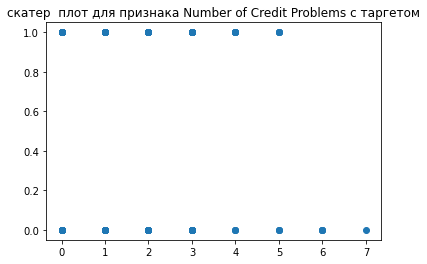

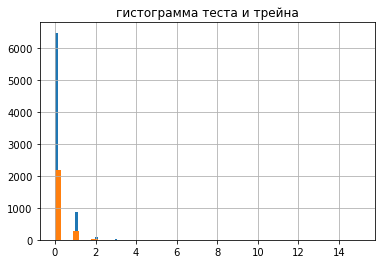

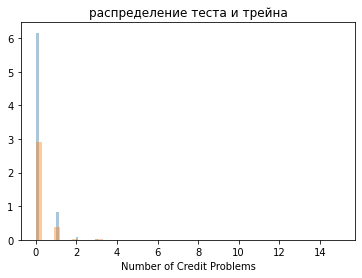

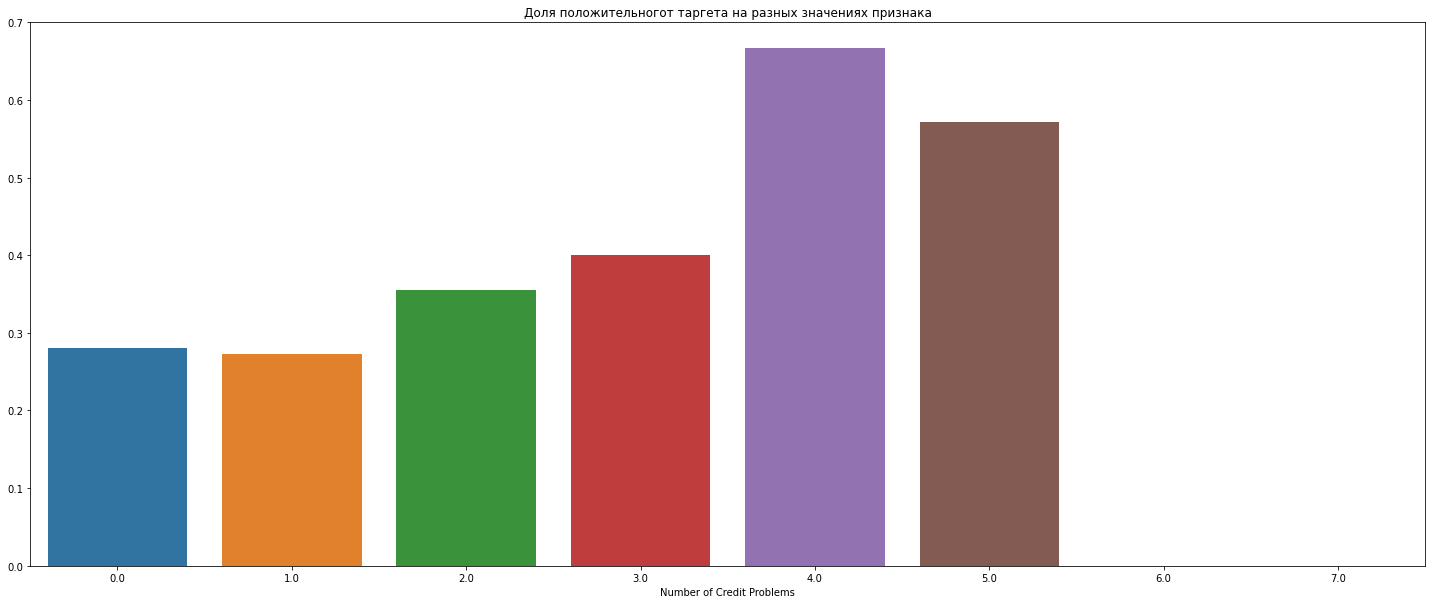

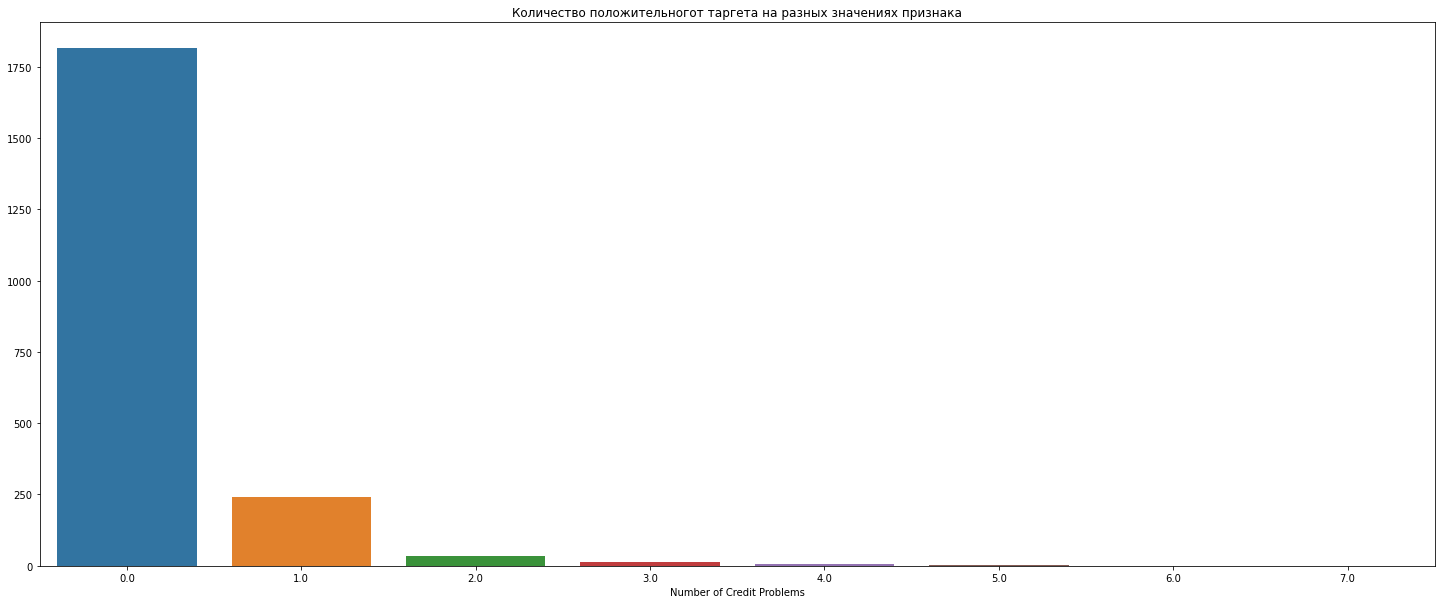

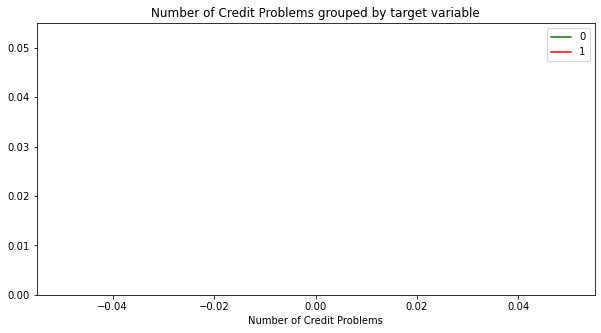

Значения теста Колмогорова-Смирнова (0.008266666666666667, 0.9994939493915016)
Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (5655742.5, 0.23974551535317956)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


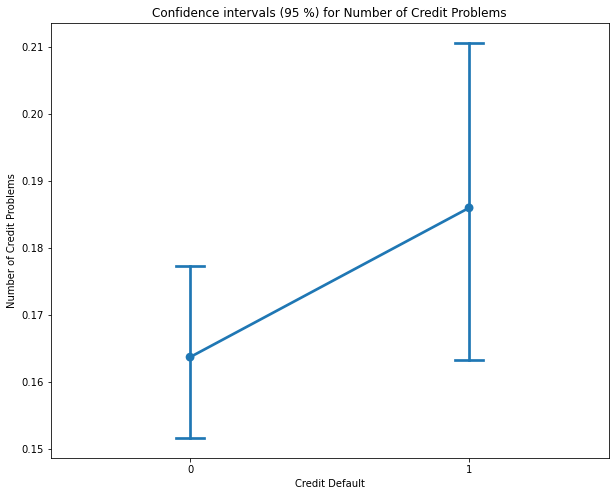

Посмотрим на корреляцию данного признака к другим
Bankruptcies                    0.730751
Tax Liens                       0.595339
Months since last delinquent    0.139905
Years of Credit History         0.071259
Years in current job            0.050220
Credit Default                  0.020088
Current Loan Amount            -0.008596
Annual Income                  -0.015407
Number of Open Accounts        -0.017813
Credit Score                   -0.018473
Monthly Debt                   -0.042252
Maximum Open Credit            -0.107795
Current Credit Balance         -0.124137
Name: Number of Credit Problems, dtype: float64


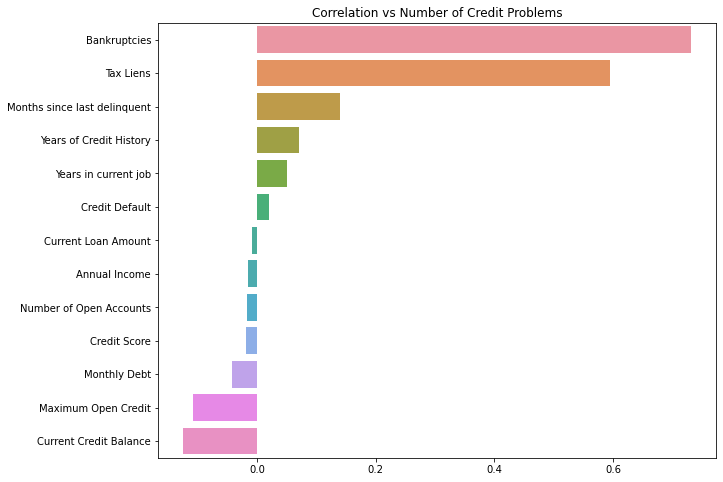

Коэф. Кендала
Bankruptcies                    0.869222
Tax Liens                       0.358815
Months since last delinquent    0.118877
Years of Credit History         0.072750
Years in current job            0.061682
Credit Default                  0.008094
Number of Open Accounts        -0.008421
Annual Income                  -0.038700
Monthly Debt                   -0.046936
Current Loan Amount            -0.058930
Credit Score                   -0.066844
Maximum Open Credit            -0.151100
Current Credit Balance         -0.169406
Name: Number of Credit Problems, dtype: float64


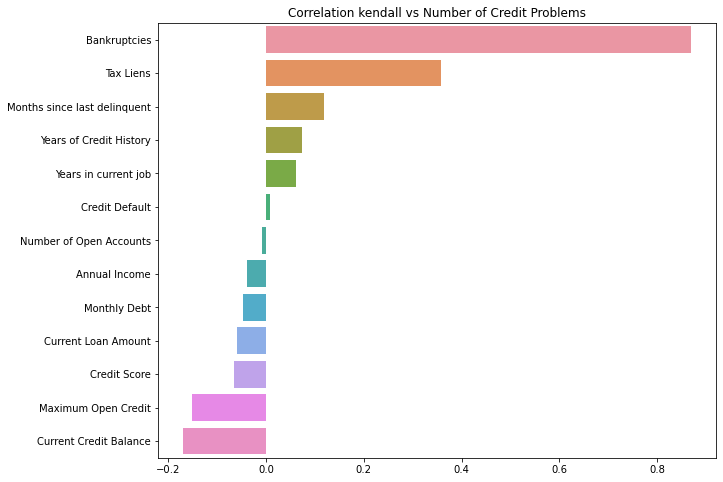

In [110]:
feature = 'Number of Credit Problems'
feature_analysis(train,test,feature,target_col[0])

Current Loan Amount

Будем считать значения 99 999 999 - пропусками и обработаеим их как пропуски

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: Credit Default, dtype: float64) 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.7182

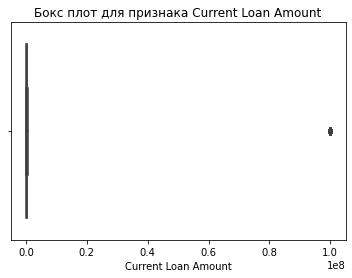

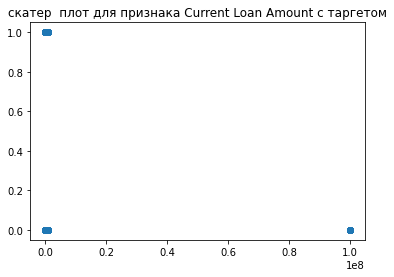

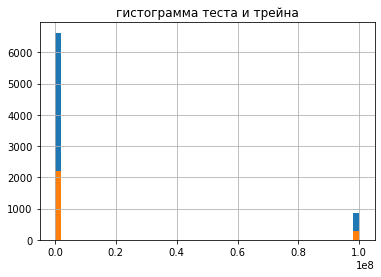

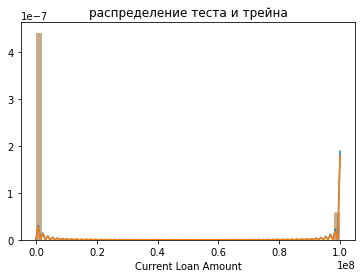

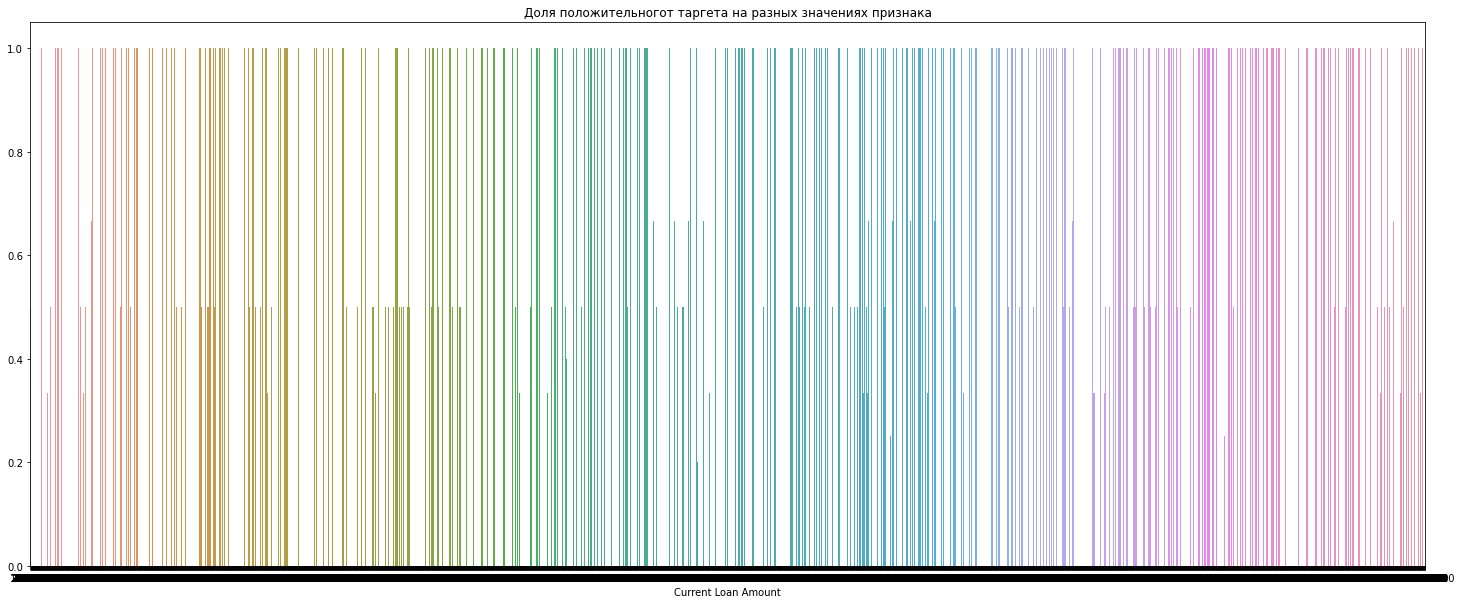

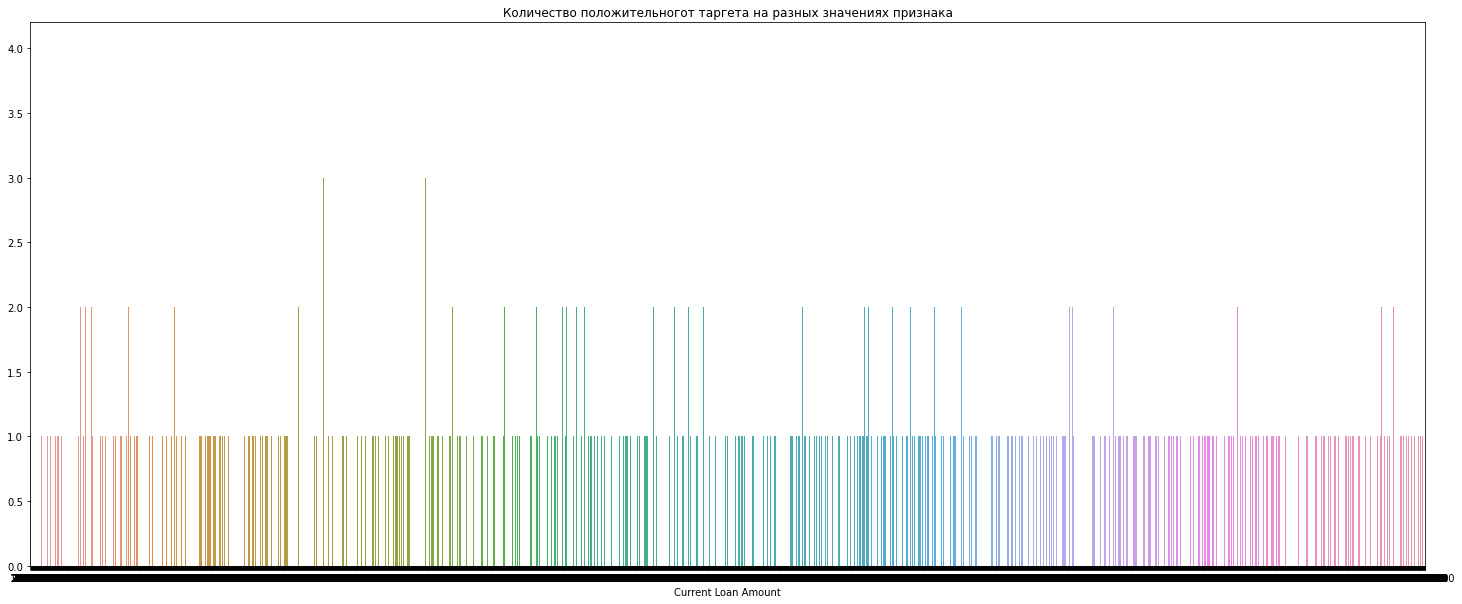

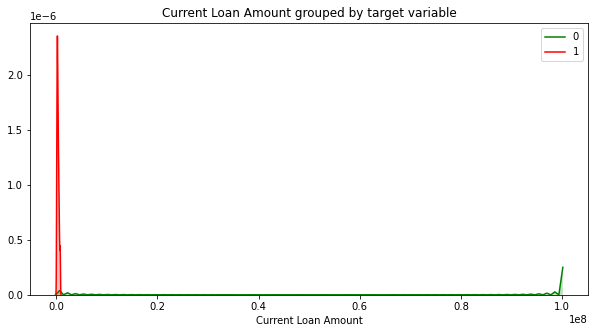

Значения теста Колмогорова-Смирнова (0.028, 0.10473047243038014)
Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (5169258.0, 2.923443678733522e-10)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


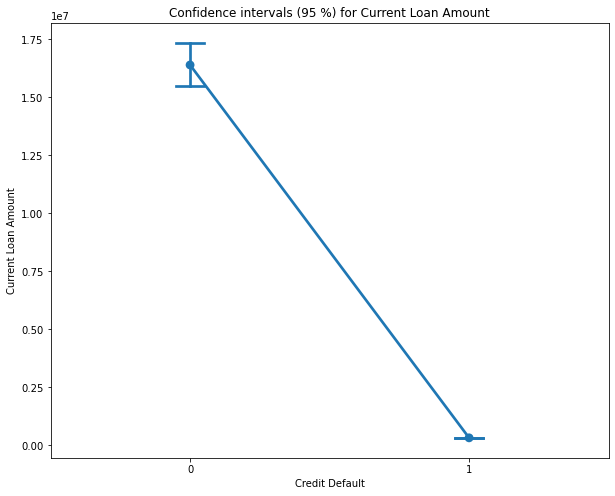

Посмотрим на корреляцию данного признака к другим
Maximum Open Credit             0.035924
Annual Income                   0.032082
Current Credit Balance          0.016672
Years of Credit History         0.010623
Number of Open Accounts         0.001346
Months since last delinquent    0.000459
Years in current job           -0.001335
Bankruptcies                   -0.005987
Tax Liens                      -0.007835
Number of Credit Problems      -0.008596
Monthly Debt                   -0.009382
Credit Score                   -0.108552
Credit Default                 -0.226522
Name: Current Loan Amount, dtype: float64


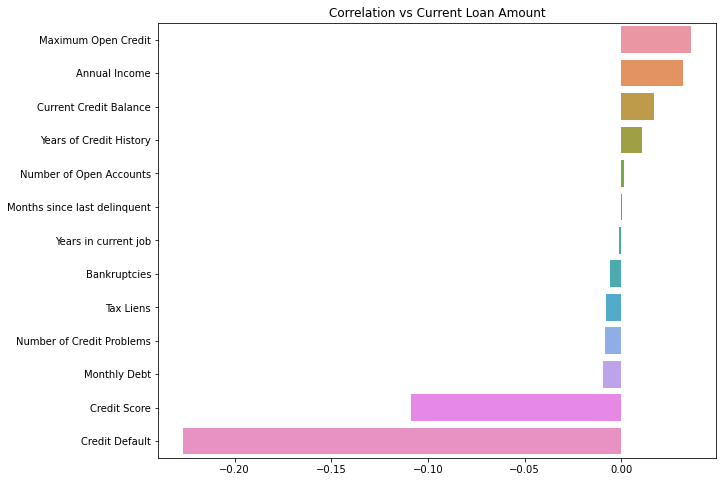

Коэф. Кендала
Annual Income                   0.281500
Current Credit Balance          0.266387
Maximum Open Credit             0.254338
Monthly Debt                    0.237972
Number of Open Accounts         0.124711
Years of Credit History         0.094082
Years in current job            0.080459
Tax Liens                       0.014602
Months since last delinquent   -0.014071
Credit Score                   -0.021581
Credit Default                 -0.058762
Number of Credit Problems      -0.058930
Bankruptcies                   -0.062713
Name: Current Loan Amount, dtype: float64


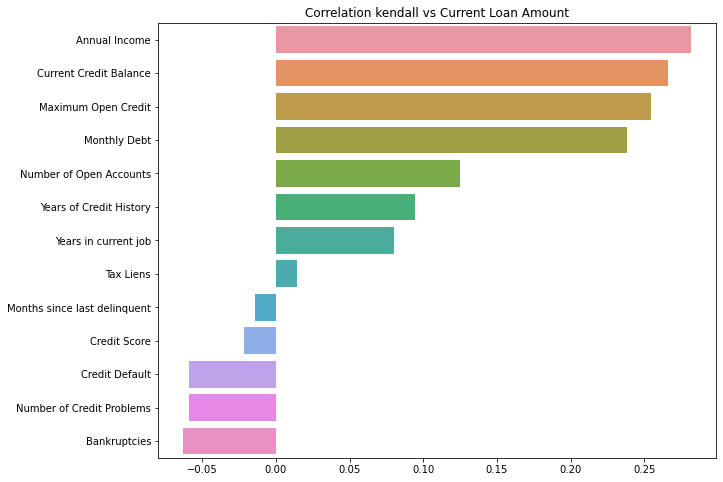

In [111]:
feature = 'Current Loan Amount'
feature_analysis(train,test,feature,target_col[0])

Создадим три варианта модели с заменой на 900000 и подбором данных через обучение на остальных признака и третий вариант 99999999

In [112]:
# model,ind,pred = miss_forecast_reg(train.drop(target_col,axis=1),feature,categorical_features)

In [113]:
# train_work['1-1'].loc[ind,feature]=pred
# train_work['1-2'].loc[ind,feature]=pred
# train_work['1-3'].loc[ind,feature]=pred
# train_work['2-1'].loc[ind,feature]=900000
# train_work['2-2'].loc[ind,feature]=900000
# train_work['2-3'].loc[ind,feature]=900000
# train_work['3-1'].loc[ind,feature]=99999999
# train_work['3-2'].loc[ind,feature]=99999999
# train_work['3-3'].loc[ind,feature]=99999999

In [114]:
# _,ind,pred = miss_forecast_reg(test,feature,categorical_features)

In [115]:
# test_work['1-1'].loc[ind,feature]=pred
# test_work['1-2'].loc[ind,feature]=pred
# test_work['1-3'].loc[ind,feature]=pred
# test_work['2-1'].loc[ind,feature]=900000
# test_work['2-2'].loc[ind,feature]=900000
# test_work['2-3'].loc[ind,feature]=900000
# test_work['3-1'].loc[ind,feature]=99999999
# test_work['3-2'].loc[ind,feature]=99999999
# test_work['3-3'].loc[ind,feature]=99999999

In [116]:
# # Не линейная связь Months since last delinquent с другими признаками на основе модели обучения
# non_linear_link_for_nan(model,feature,train.drop([target_col[0],feature],axis=1).columns)

In [117]:
# # Сравним до и после изменений
# matching_after_changes(train,train_work['1-1'],feature)

Current Credit Balance

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
0.0         53
191710.0     5
53580.0      4
106818.0     4
155059.0     4
            ..
229672.0     1
349467.0     1
116223.0     1
797240.0     1
189905.0     1
Name: Current Credit Balance, Length: 6592, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: Credit Default, dtype: float64) 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.718267
1    0.281733
Name: Cred

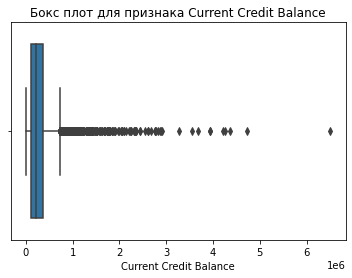

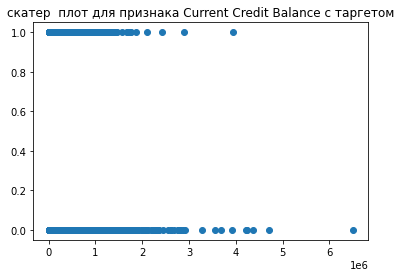

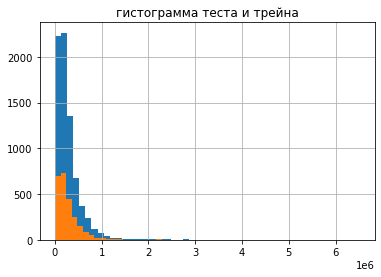

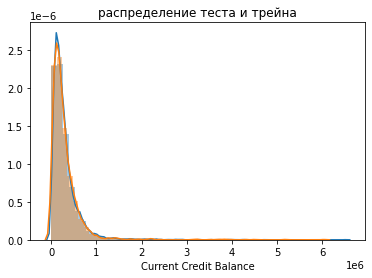

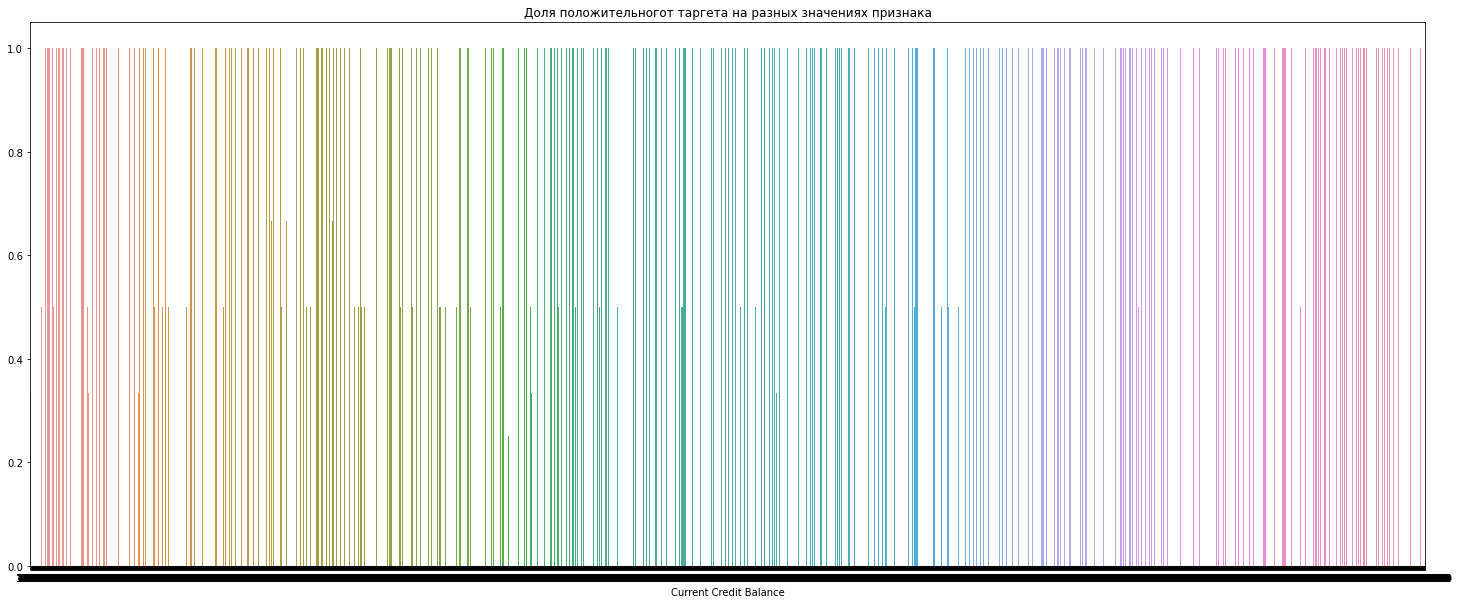

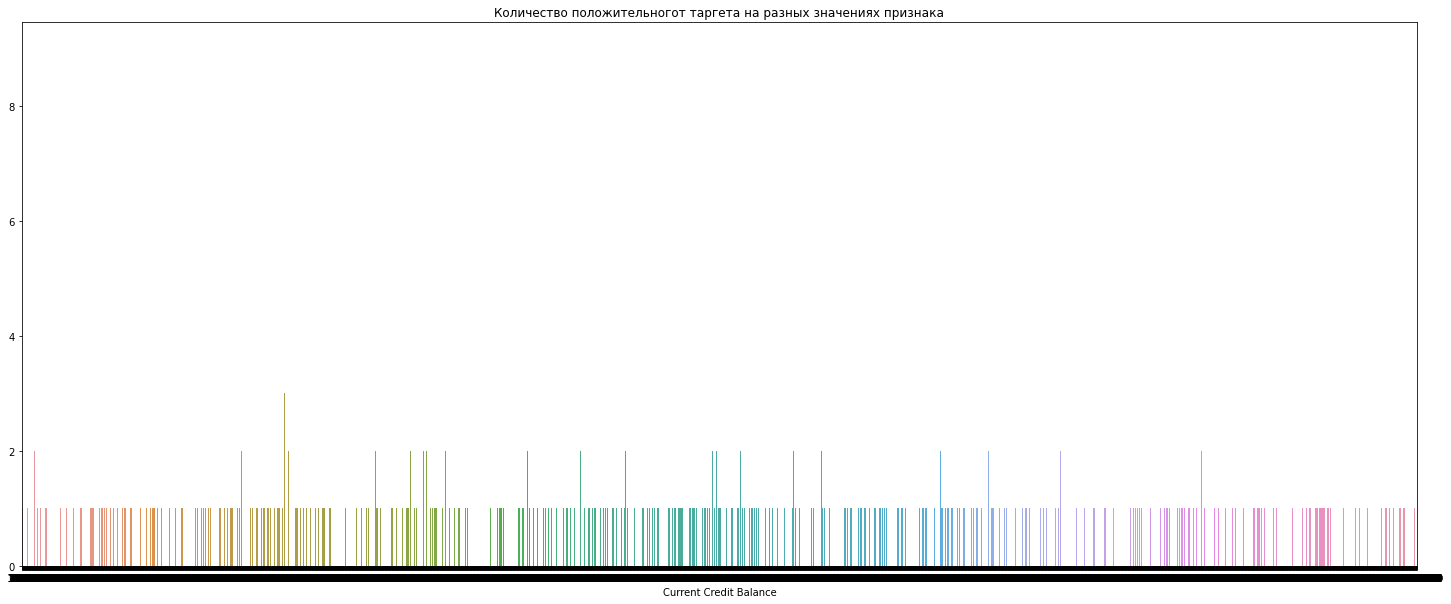

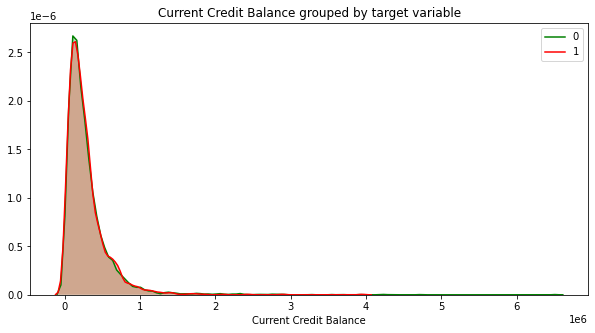

Значения теста Колмогорова-Смирнова (0.015066666666666667, 0.7853487354916262)
Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (5687957.0, 0.48388614709675304)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


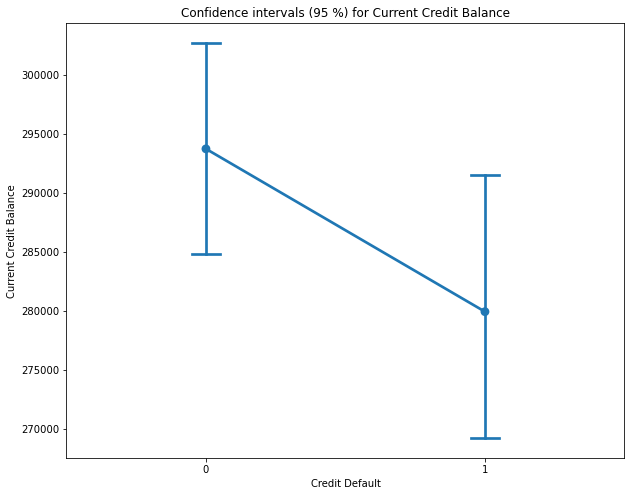

Посмотрим на корреляцию данного признака к другим
Maximum Open Credit             0.769682
Monthly Debt                    0.504964
Annual Income                   0.386481
Number of Open Accounts         0.267325
Years of Credit History         0.217856
Years in current job            0.110127
Current Loan Amount             0.016672
Credit Score                   -0.006159
Tax Liens                      -0.010195
Credit Default                 -0.019522
Months since last delinquent   -0.027198
Number of Credit Problems      -0.124137
Bankruptcies                   -0.142849
Name: Current Credit Balance, dtype: float64


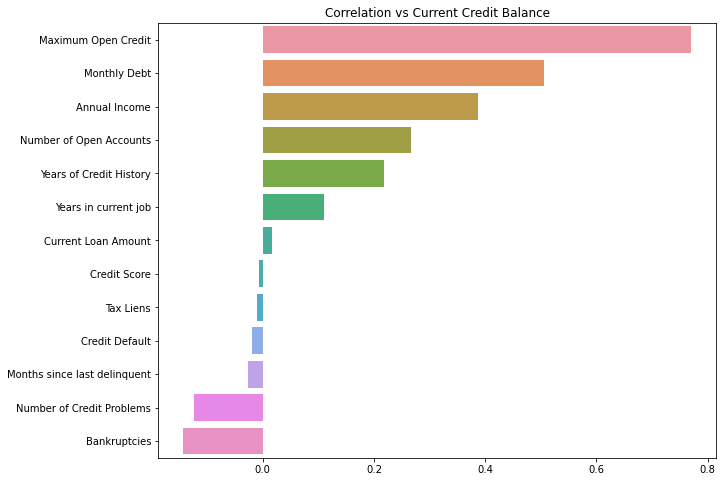

Коэф. Кендала
Maximum Open Credit             0.603016
Monthly Debt                    0.368655
Annual Income                   0.272327
Current Loan Amount             0.266387
Number of Open Accounts         0.260005
Years of Credit History         0.176226
Years in current job            0.104260
Credit Score                    0.004598
Credit Default                 -0.000381
Months since last delinquent   -0.009722
Tax Liens                      -0.020230
Bankruptcies                   -0.166627
Number of Credit Problems      -0.169406
Name: Current Credit Balance, dtype: float64


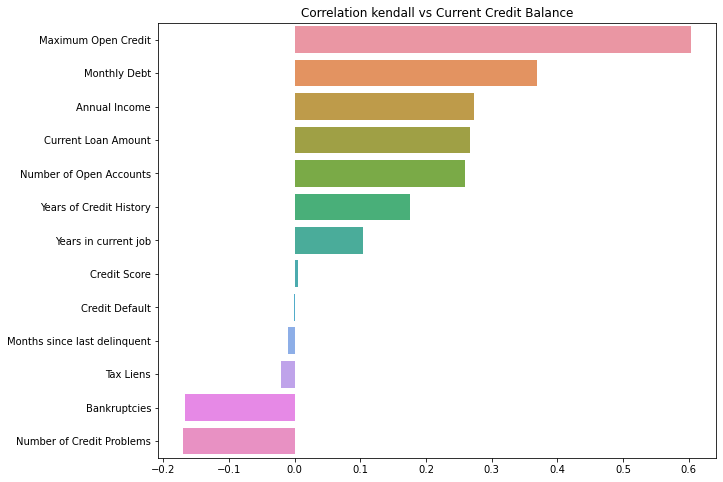

In [118]:
feature = 'Current Credit Balance'
feature_analysis(train,test,feature,target_col[0])

Monthly Debt

Основные статистические показатели
Количество пропусков  - 0
 ------------------------------------------------------------
Значения показателя и их частоты:
0.0        6
19222.0    4
19667.0    4
9525.0     3
22364.0    3
          ..
12897.0    1
27541.0    1
23227.0    1
55957.0    1
17.0       1
Name: Monthly Debt, Length: 6716, dtype: int64 
 ------------------------------------------------------------
Статистики показателя:
count      7500.000000
mean      18314.454133
std       11926.764673
min           0.000000
25%       10067.500000
50%       16076.500000
75%       23818.000000
max      136679.000000
Name: Monthly Debt, dtype: float64 
 ------------------------------------------------------------
Доля целевой переменной в пропущенных значениях:
Series([], Name: Credit Default, dtype: float64) 
 ------------------------------------------------------------
Доля целевой переменной в не пропущенных значениях:
0    0.718267
1    0.281733
Name: Credit Default, dtype: float64 
 -----

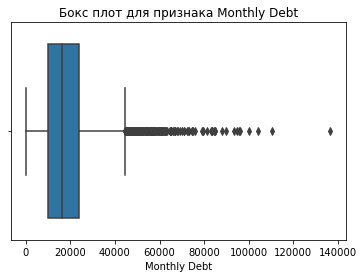

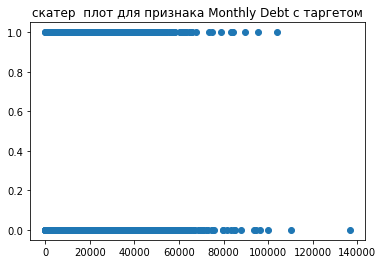

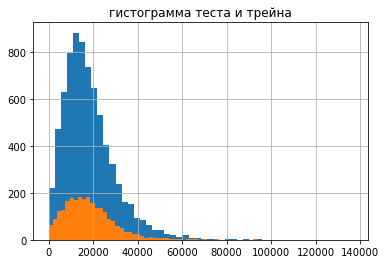

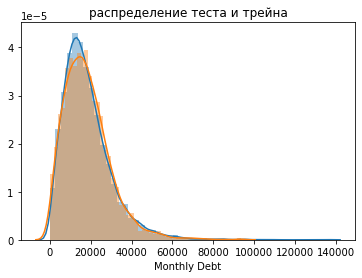

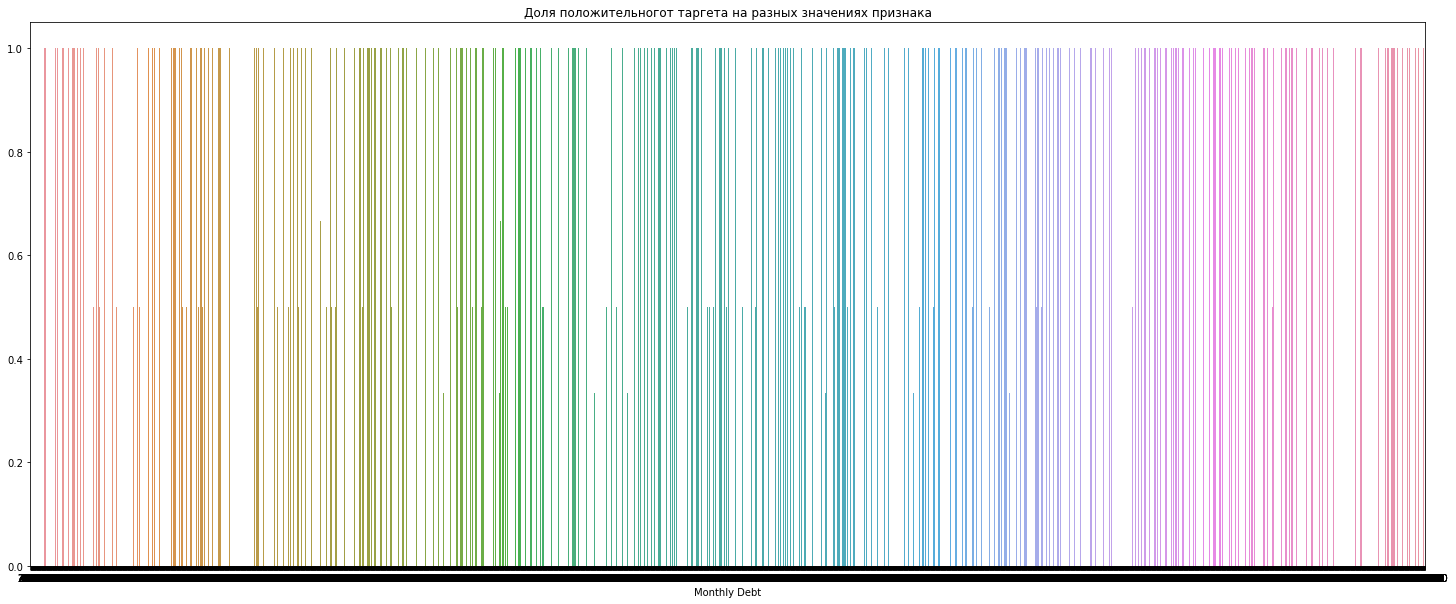

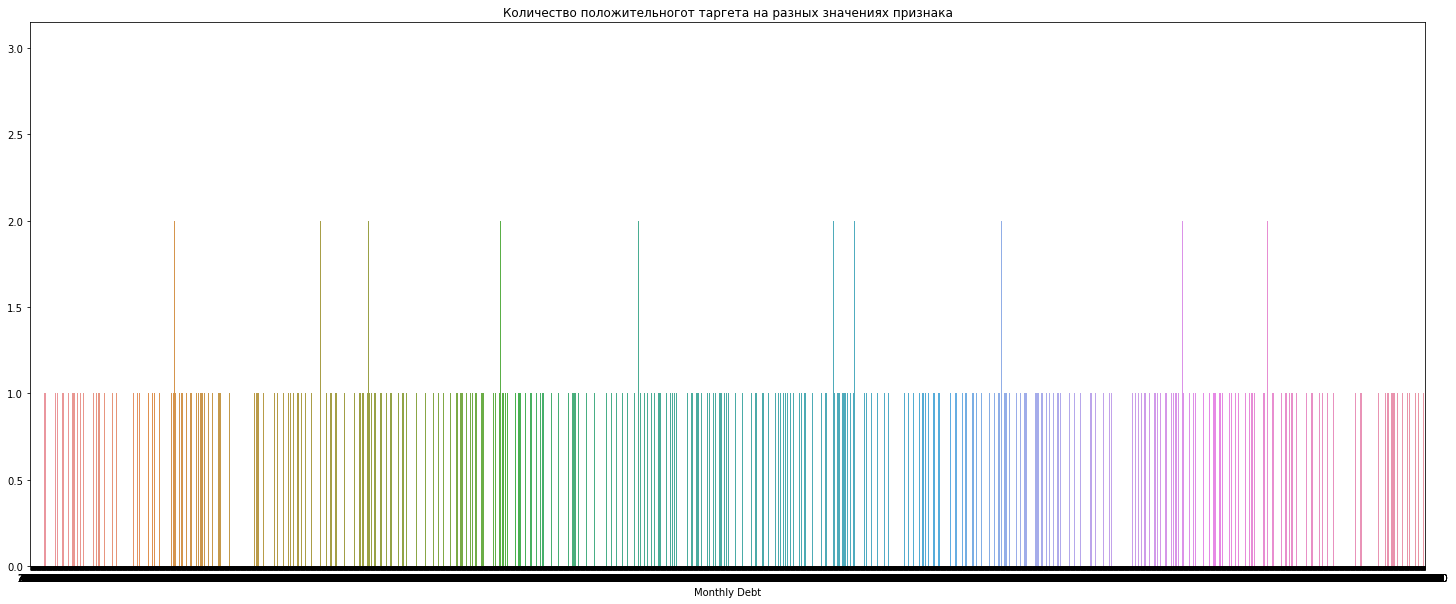

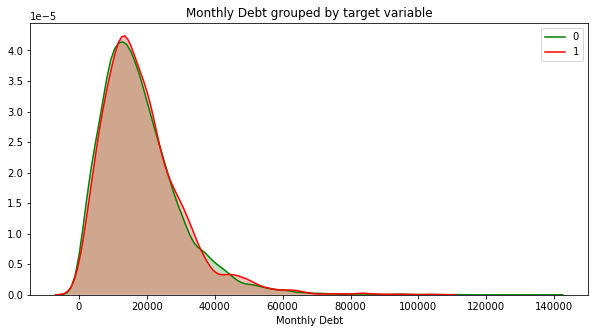

Значения теста Колмогорова-Смирнова (0.0244, 0.2125158663841833)
Оценим эквивалентность мат. ожиданий при разных значениях таргета с помощью критерия Манна-Уитни
Значения U - теста  (5534935.5, 0.03183394406726229)
Построим доверительные интервалы для средних значений каждой из двух групп и сравним их


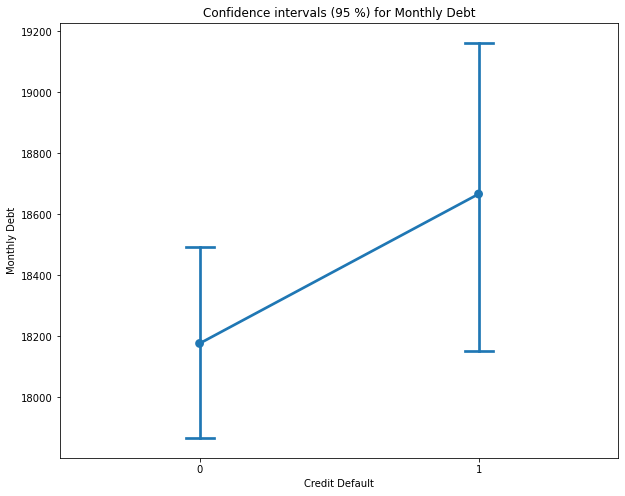

Посмотрим на корреляцию данного признака к другим
Annual Income                   0.584819
Current Credit Balance          0.504964
Number of Open Accounts         0.413904
Maximum Open Credit             0.358984
Years of Credit History         0.191978
Years in current job            0.125483
Tax Liens                       0.027211
Credit Default                  0.018480
Credit Score                    0.000234
Current Loan Amount            -0.009382
Number of Credit Problems      -0.042252
Months since last delinquent   -0.057702
Bankruptcies                   -0.079579
Name: Monthly Debt, dtype: float64


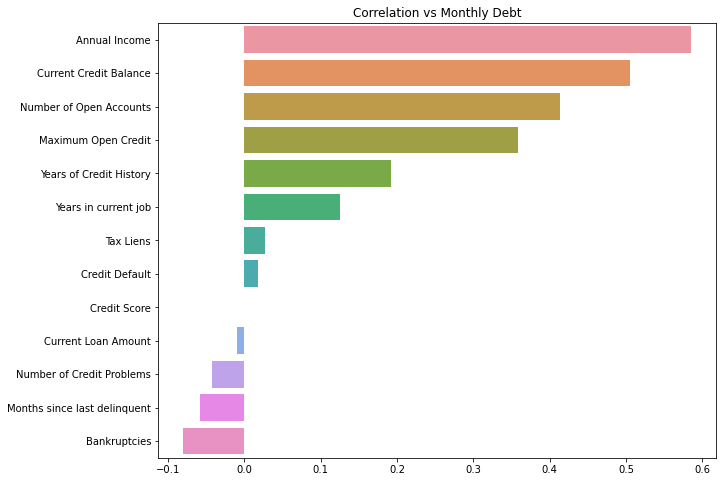

Коэф. Кендала
Annual Income                   0.426938
Current Credit Balance          0.368655
Number of Open Accounts         0.324219
Maximum Open Credit             0.296326
Current Loan Amount             0.237972
Years of Credit History         0.150542
Years in current job            0.106264
Credit Default                  0.017487
Tax Liens                       0.011747
Months since last delinquent   -0.042211
Credit Score                   -0.042276
Number of Credit Problems      -0.046936
Bankruptcies                   -0.057146
Name: Monthly Debt, dtype: float64


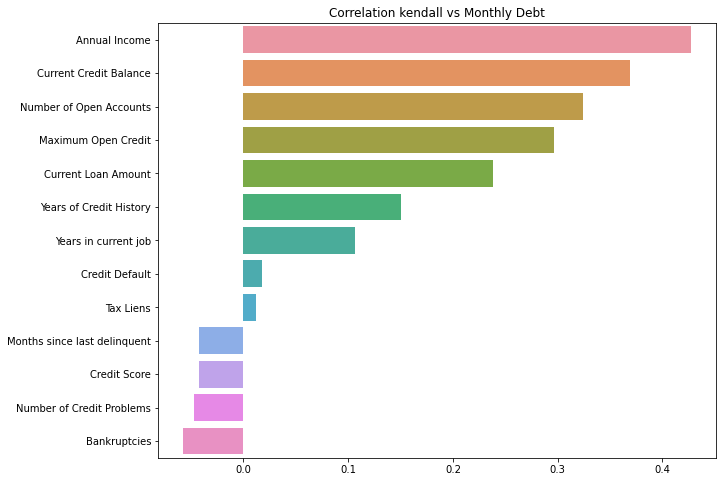

In [119]:
feature = 'Monthly Debt'
feature_analysis(train,test,feature,target_col[0])

Проедемся по всем признакам вместе

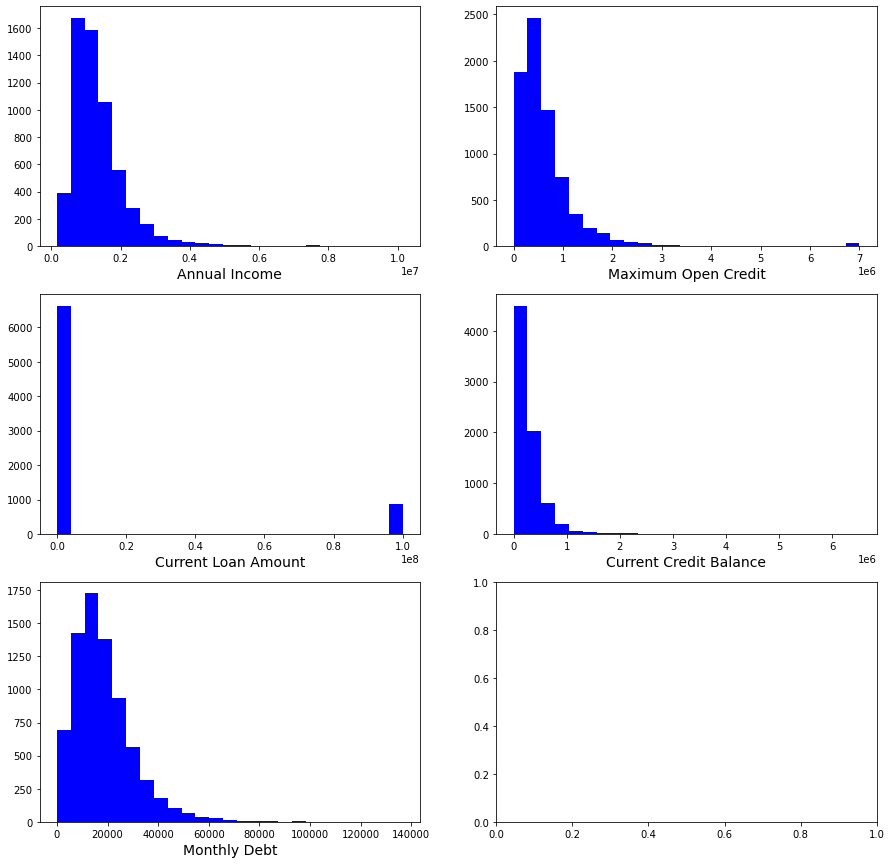

In [120]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

for num, feature in enumerate(continuous_feature):
    data = train[feature].copy()
    axes[num//2, num%2].hist(data, bins=25, color="blue")
    axes[num//2, num%2].set_xlabel(feature, fontsize=14)

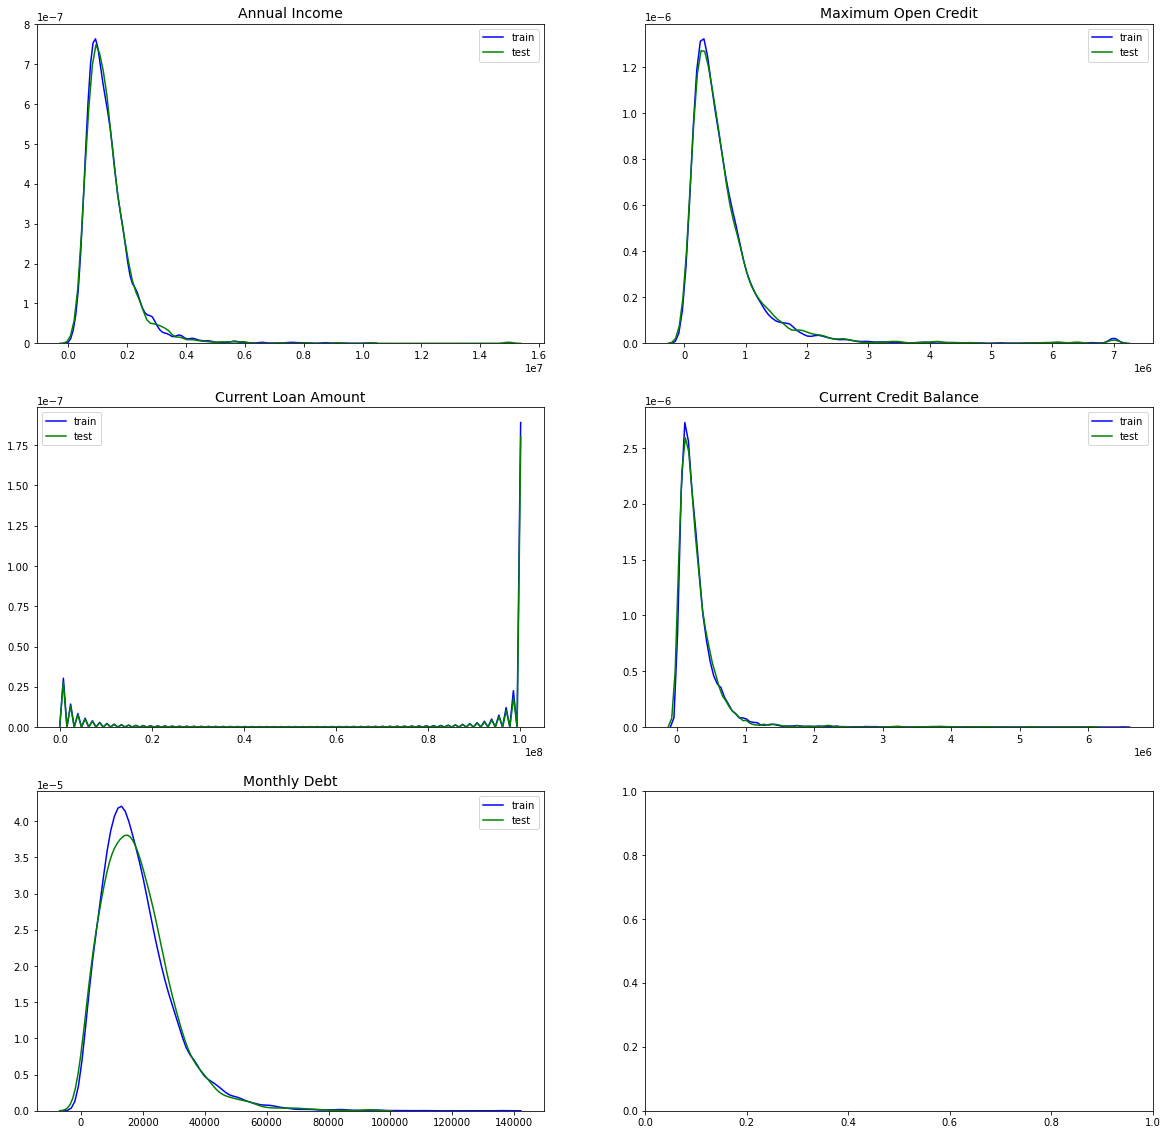

In [121]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

for num, feature in enumerate(continuous_feature):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//2, num%2], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//2, num%2], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
    axes[num//2, num%2].set_title(feature, fontsize=14)

In [122]:
correlation = train_work['1-1'].corr()
corr_with_target = correlation["Credit Default"].sort_values(ascending = False)
corr_with_target

Credit Default                  1.000000
Credit Score                    0.374909
Home Ownership                  0.043443
Number of Open Accounts         0.028884
Tax Liens                       0.024368
Number of Credit Problems       0.020088
Monthly Debt                    0.018480
Months since last delinquent    0.003484
Bankruptcies                    0.001640
Years in current job           -0.004485
Purpose                        -0.006216
Current Credit Balance         -0.019522
Years of Credit History        -0.020567
Maximum Open Credit            -0.067293
Annual Income                  -0.083094
Term                           -0.181487
Current Loan Amount            -0.226522
Name: Credit Default, dtype: float64

Text(0, 0.5, 'Density')

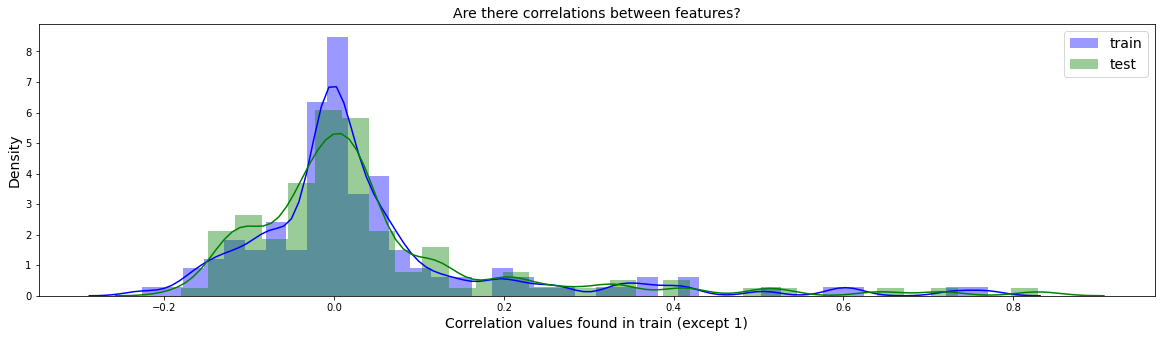

In [123]:
train_correlations = train_work['1-1'].corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = train_work['1-1'].columns.tolist()
columns.remove("Credit Default")

test_correlations = test_work['1-1'][columns].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

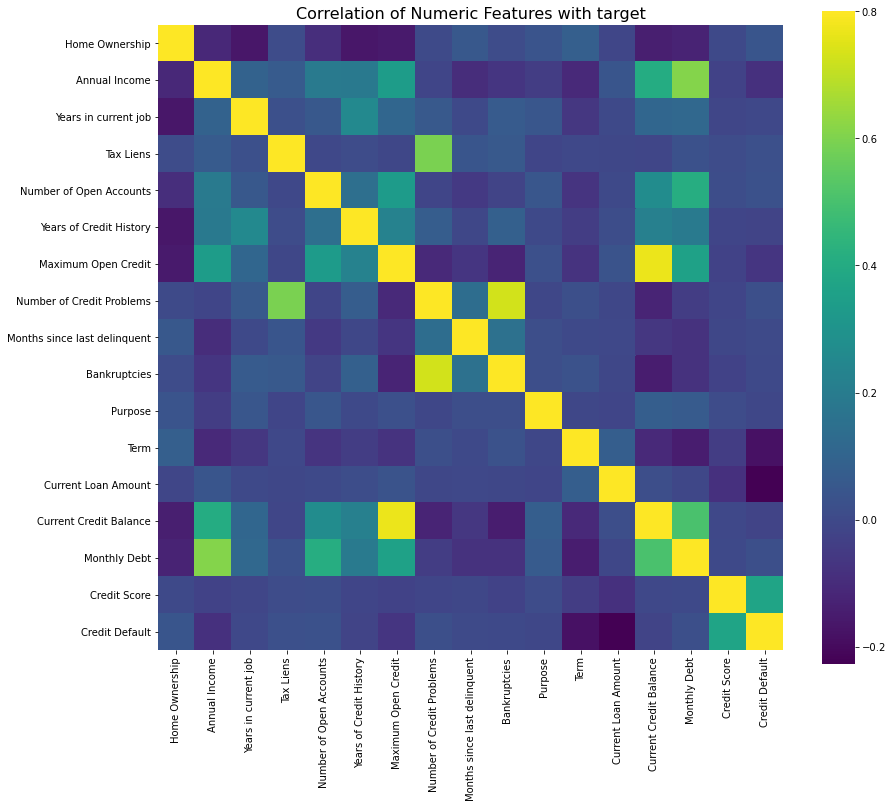

In [124]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Numeric Features with target", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

Нелинейная связь между признаками

In [125]:
parameters = {"max_depth": 6, "n_estimators": 100, "random_state": 27, "n_jobs": -1}

forest = RandomForestRegressor(**parameters)
forest.fit(train_work['1-1'].drop(target_col[0], axis=1), target)

RandomForestRegressor(max_depth=6, n_jobs=-1, random_state=27)

Text(0.5, 1.0, 'What are the top important features to start with?')

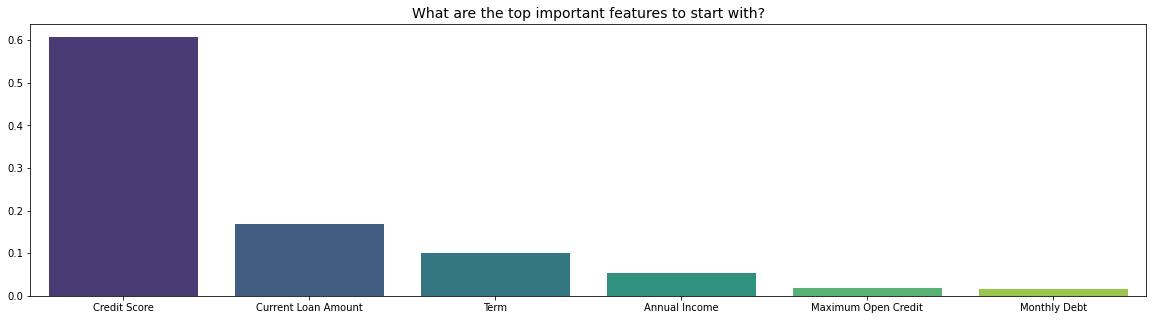

In [126]:
n_top = 6
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = train_work['1-1'].drop(target_col[0], axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

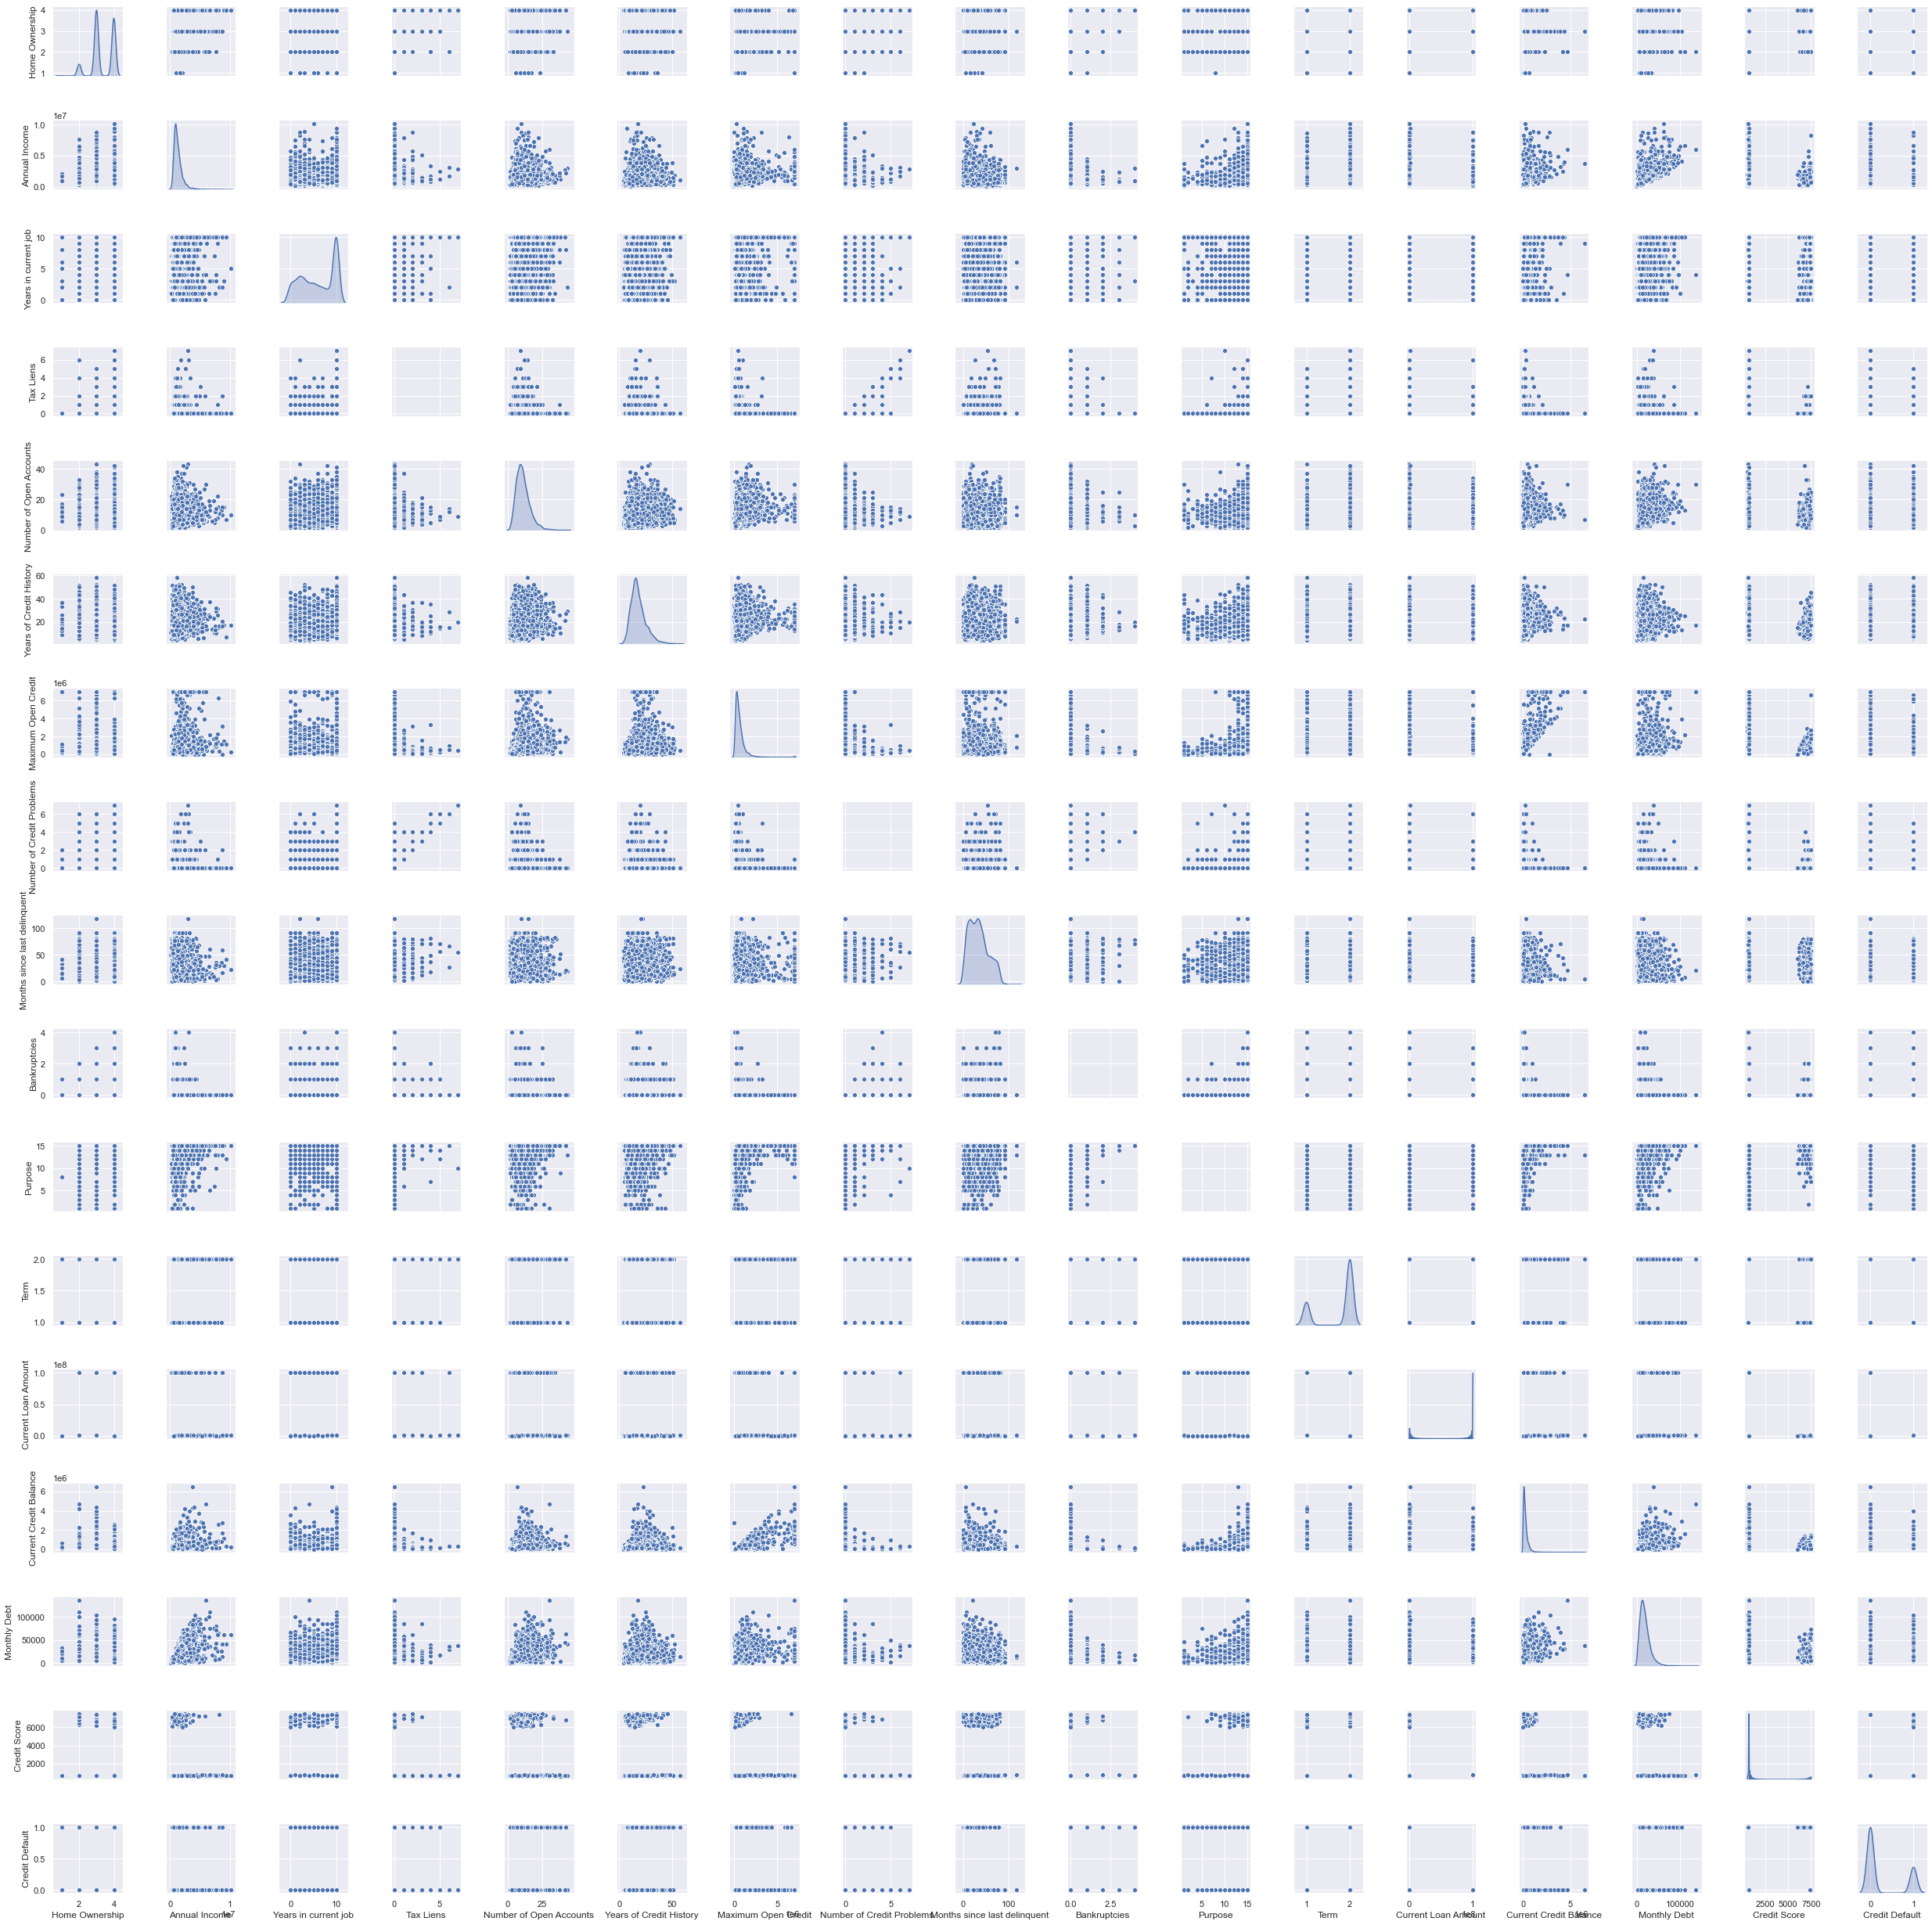

In [127]:
sns.set()
columns = train.columns.to_list()
columns.pop()

sns.pairplot(train_work['1-1'], size=2, kind="scatter", diag_kind="kde")
plt.show()

Adversarial Validation

In [128]:
features_to_score = test.columns.tolist()

In [129]:
X_adv = pd.concat([
    train[features_to_score], test[features_to_score]
])
y_adv = np.hstack(
    (np.ones(train.shape[0]), np.zeros(test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [130]:
lgb_model = quick_lgb_binary()

In [131]:
res_adv = lgb_model.test_cros(X_adv,y_adv)

Training until validation scores don't improve for 95 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.602069	train's f1: 0.856571	test's auc: 0.487129	test's f1: 0.859424
Выборка номер 0 имеет следующие параметры:
Показатель f1_test равен 0.8594240091246079
Показатель f1_train равен 0.8565711427142143
Показатель auc_train равен 0.6020692551873549
Показатель auc_test равен 0.4871290300437041
Показатель accuracy_test равен 0.7535
Показатель accuracy_train равен 0.749125
Показатель precision_train равен 0.749125
Показатель precision_test равен 0.7535
Показатель recall_train равен 1.0
Показатель recall_test равен 1.0
Показатель positiv_train равен 0.749125
Показатель positiv_test равен 0.7535
Показатель best_split равен 0.05
Training until validation scores don't improve for 95 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.669107	train's f1: 0.860457	test's auc: 0.528498	test's f1: 0.85518
Выборка номер 1 имеет следующие параметры:
Показатель f1_test равен 0.855

In [132]:
pd.DataFrame(res_adv)

f1_test  f1_train  auc_train  auc_test  accuracy_test  accuracy_train  \
0  0.859424  0.856571   0.602069  0.487129         0.7535        0.749125   
1  0.855180  0.860457   0.669107  0.528498         0.7470        0.750750   
2  0.854197  0.857877   0.602752  0.505651         0.7455        0.751125   
3  0.860399  0.856326   0.587389  0.522655         0.7550        0.748750   
4  0.856489  0.859663   0.638181  0.524391         0.7490        0.750250   
5  0.857138  0.858179   0.619900  0.513665         0.7500        0.750000   

   precision_train  precision_test  recall_train  recall_test  positiv_train  \
0         0.749125          0.7535           1.0          1.0       0.749125   
1         0.750750          0.7470           1.0          1.0       0.750750   
2         0.751125          0.7455           1.0          1.0       0.751125   
3         0.748750          0.7550           1.0          1.0       0.748750   
4         0.750250          0.7490           1.0          1.0       0.750250   
5         0.750000          0.7500           1.0          1.0       0.750000   

   positiv_test  best_split  
0        0.7535        0.05  
1        0.7470        0.05  
2        0.7455        0.05  
3        0.7550        0.05  
4        0.7490        0.05  
5        0.7500        0.05

In [133]:
X_adv = pd.concat([
    train_work['1-1'][features_to_score], test_work['1-1'][features_to_score]
])
y_adv = np.hstack(
    (np.ones(train.shape[0]), np.zeros(test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [134]:
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.6949


Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

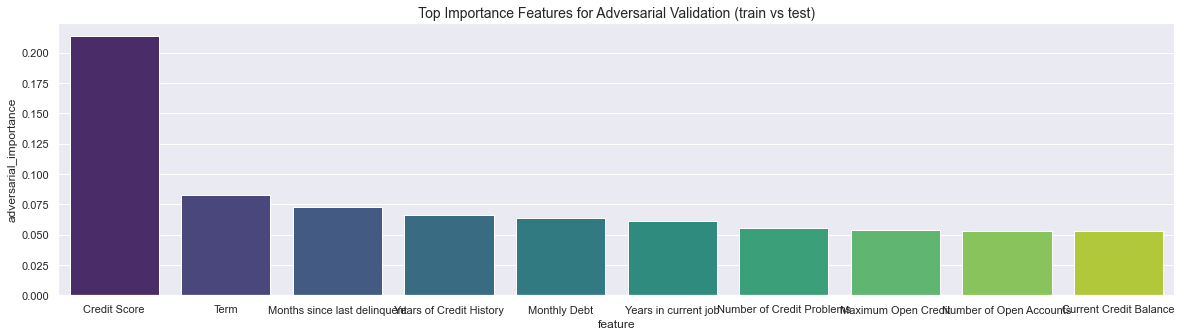

In [135]:
model.fit(X_adv, y_adv)

importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)

In [136]:
train_stats

Annual Income                     16.742139
Tax Liens                        215.604568
Number of Open Accounts            2.243359
Years of Credit History            1.602071
Maximum Open Credit             5894.458758
Number of Credit Problems         32.101329
Months since last delinquent      -0.788372
Bankruptcies                      13.621521
Current Loan Amount                3.754847
Current Credit Balance            52.946562
Monthly Debt                       5.832893
Credit Score                      10.063803
dtype: float64

In [137]:
train_stats = train_work['1-1'].describe()
test_stats = test_work['1-1'].describe()

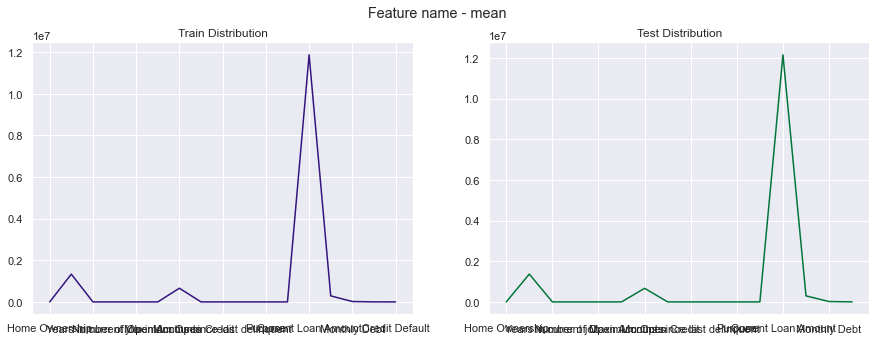

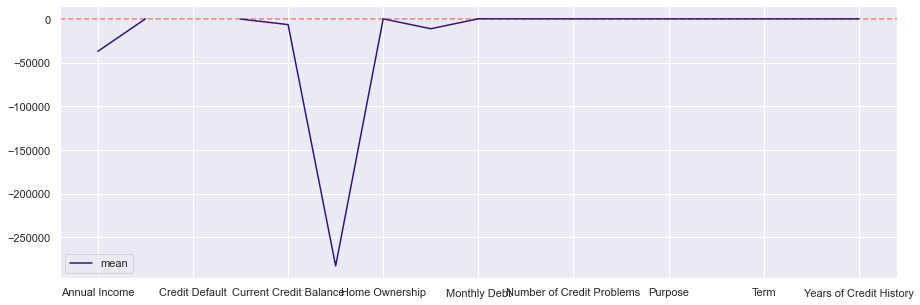

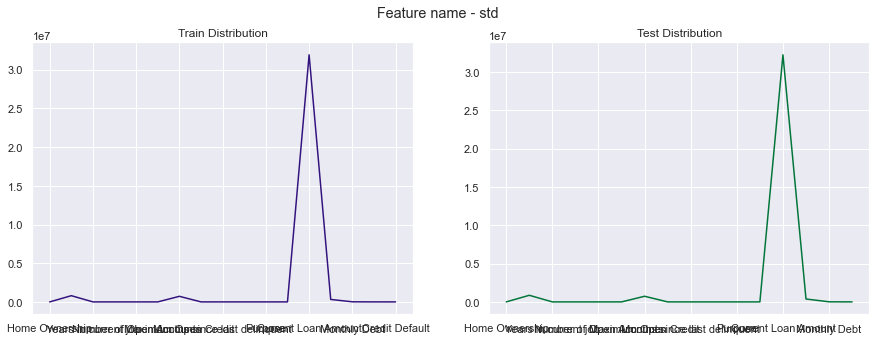

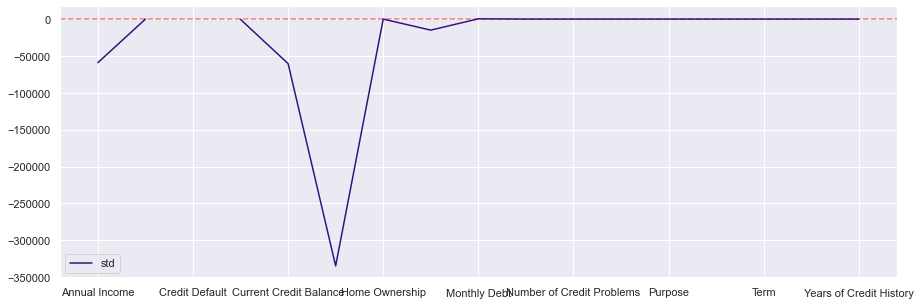

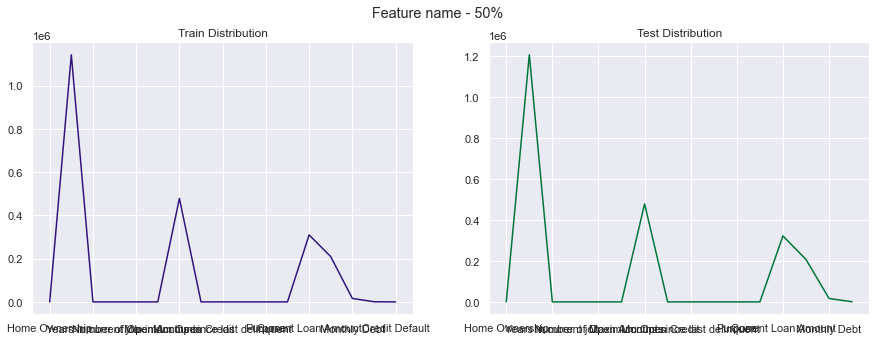

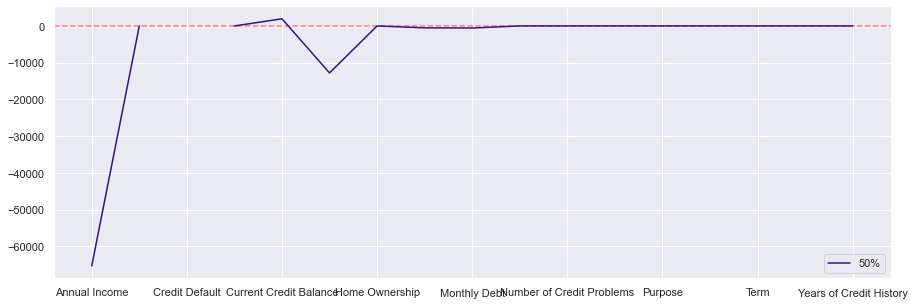

In [138]:
for feature in ["mean", "std", "50%"]:
    plot_stat_distribution(train_stats.loc[feature], test_stats.loc[feature])

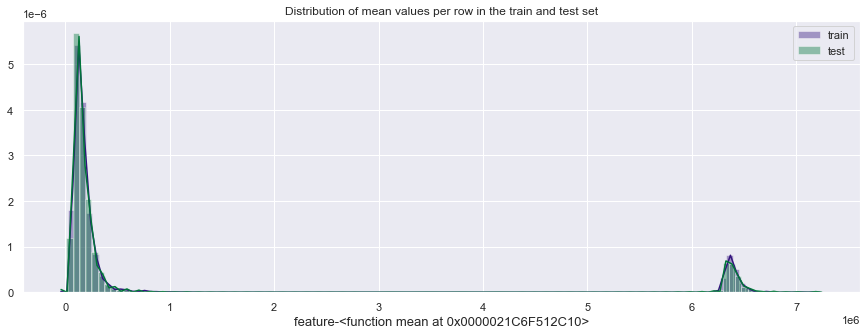

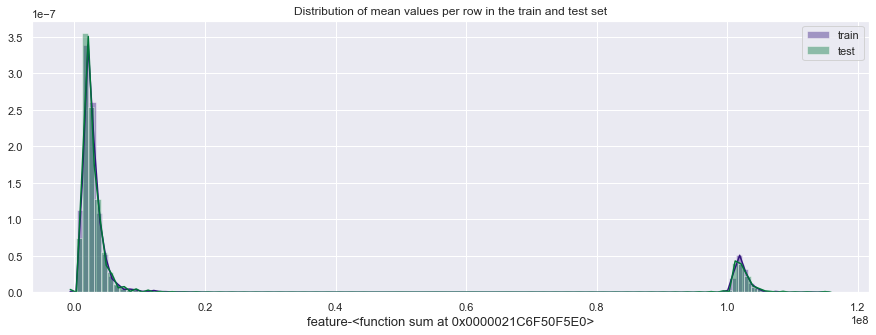

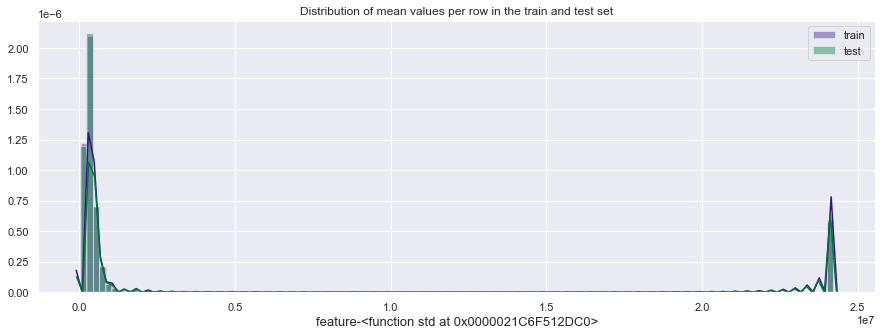

In [139]:
for func in [np.mean, np.sum, np.std]:
    plot_row_distribution(func, train_work['1-1'], test_work['1-1'])

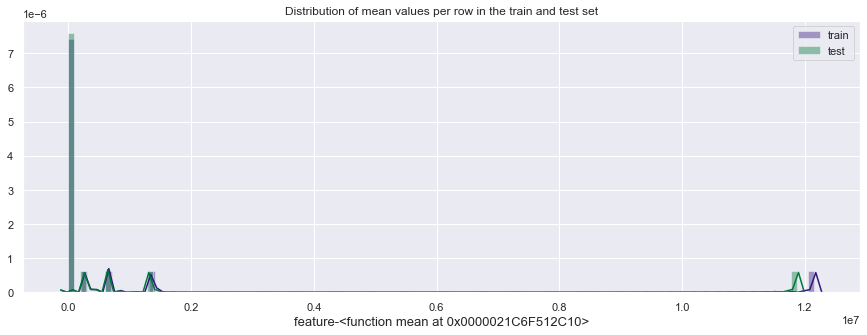

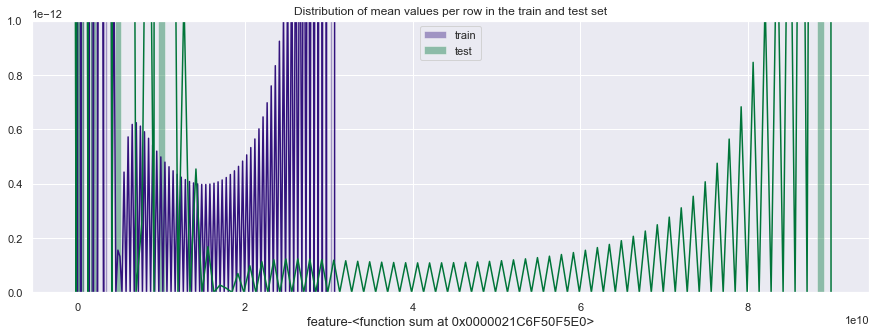

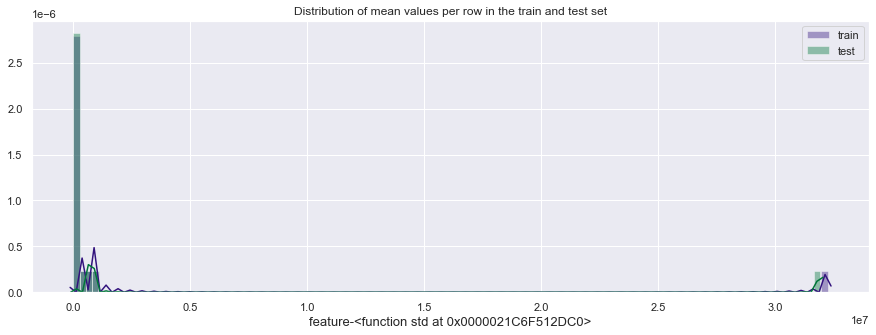

In [140]:
for func in [np.mean, np.sum, np.std]:
    plot_row_distribution(func, train_work['1-1'], test_work['1-1'],axis=0)

Посмотрим на таргет

Mean-target: 0.2817


Text(0, 0.5, 'Index')

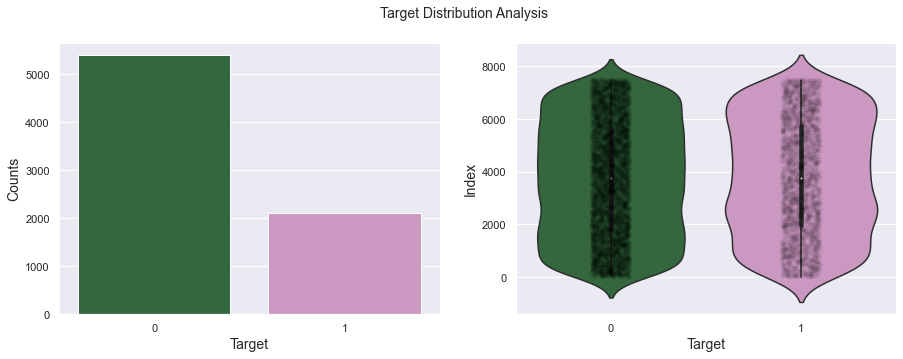

In [141]:

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Target Distribution Analysis", size=14)
print(f"Mean-target: {round(train['Credit Default'].mean(), 4)}")

sns.countplot(train['Credit Default'], ax=axes[0], palette="cubehelix")
sns.violinplot(train['Credit Default'], train.index, ax=axes[1], palette="cubehelix")
sns.stripplot(train['Credit Default'], train.index, jitter=True, ax=axes[1], color="black", alpha=0.05)

axes[0].set_xlabel("Target", fontsize=14)
axes[0].set_ylabel("Counts", fontsize=14)
axes[1].set_xlabel("Target", fontsize=14)
axes[1].set_ylabel("Index", fontsize=14)

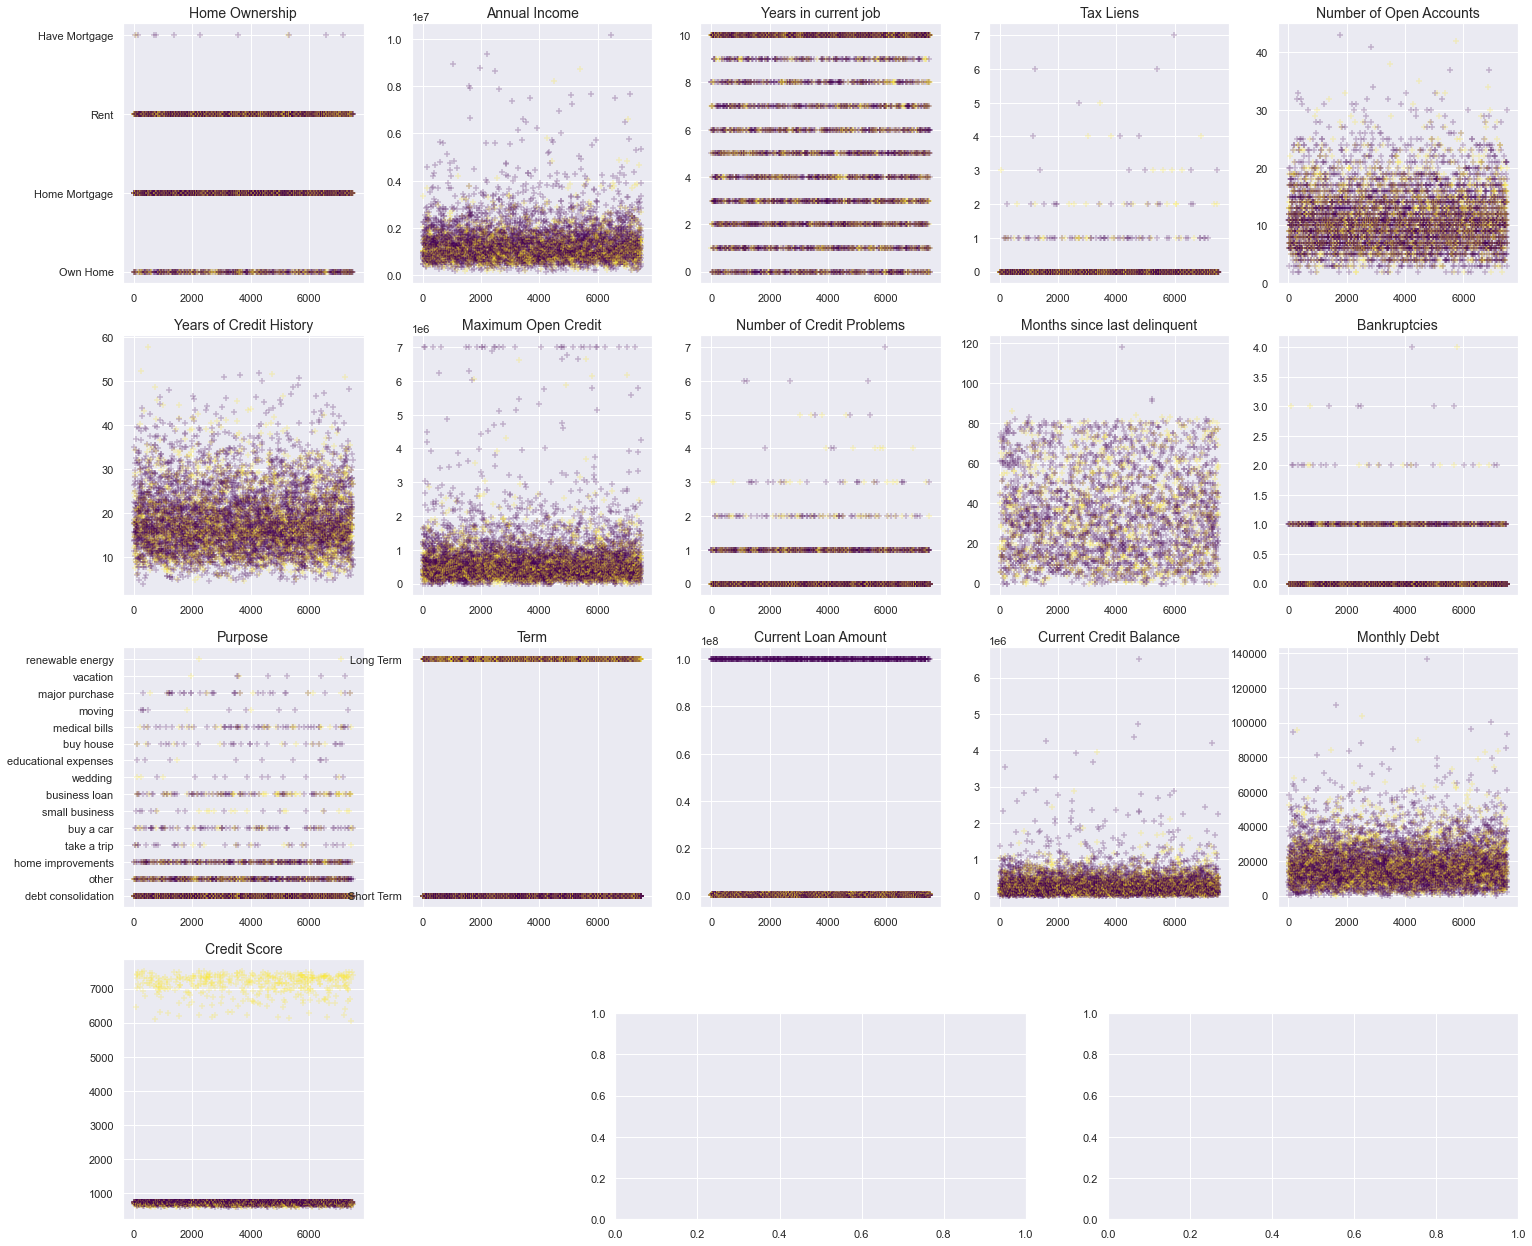

In [142]:
fig, axes = plt.subplots(5, 3, figsize=(25, 22))

for num, f in enumerate(test.columns.to_list(),start=1):
    plt.subplot(4, 5, num)
    plt.title(f"{f}", size=14)
    plt.scatter(
        train[f].index,
        train[f],
        c=train[target_col[0]],
        cmap="viridis",
        alpha=0.25,
        marker="+")

Сделаем набор данных без замен nan, но с переводом текстовых признаков в цифру

In [143]:
feature = 'Home Ownership'
enc_label(train,feature,target_col[0],train_work,'4','start')
enc_label(train,feature,target_col[0],test_work,'4','start')
enc_frc(train,feature,target_col[0],train_work,'5','start')
enc_frc(train,feature,target_col[0],test_work,'5','start')
enc_target(train,feature,target_col[0],train_work,'6','start')
enc_target(train,feature,target_col[0],test_work,'6','start')
    

In [144]:
feature = 'Purpose'
enc_label(train,feature,target_col[0],train_work,'4','4')
enc_label(train,feature,target_col[0],test_work,'4','4')
enc_frc(train,feature,target_col[0],train_work,'5','5')
enc_frc(train,feature,target_col[0],test_work,'5','5')
enc_target(train,feature,target_col[0],train_work,'6','6')
enc_target(train,feature,target_col[0],test_work,'6','6')

In [145]:
feature = 'Term'
enc_label(train,feature,target_col[0],train_work,'4','4')
enc_label(train,feature,target_col[0],train_work,'4','4')
enc_label(train,feature,target_col[0],test_work,'4','4')
enc_frc(train,feature,target_col[0],train_work,'5','5')
enc_frc(train,feature,target_col[0],test_work,'5','5')
enc_target(train,feature,target_col[0],train_work,'6','6')
enc_target(train,feature,target_col[0],test_work,'6','6')

In [146]:
del feature

In [147]:
not_imported = ['Purpose', 'Tax Liens', 'Bankruptcies']

In [148]:
# train_work['5-1'] = train_work['5'].copy()
# train_work['5-1'].loc[train_work['5-1']['Credit Score']>1000,'Credit Score'] = train_work['5-1'][train_work['5-1']['Credit Score']>1000]['Credit Score']/10
# test_work['5-1'] = test_work['5'].copy()
# test_work['5-1'].loc[test_work['5-1']['Credit Score']>1000,'Credit Score'] = test_work['5-1'][test_work['5-1']['Credit Score']>1000]['Credit Score']/10

In [149]:
# train_work['6-1'] = train_work['6'].copy()
# train_work['6-1'].loc[train_work['6-1']['Credit Score']>1000,'Credit Score'] = train_work['6-1'][train_work['6-1']['Credit Score']>1000]['Credit Score']/10
# test_work['6-1'] = test_work['6'].copy()
# test_work['6-1'].loc[test_work['6-1']['Credit Score']>1000,'Credit Score'] = test_work['6-1'][test_work['6-1']['Credit Score']>1000]['Credit Score']/10

In [150]:

# train_work['4-1'] = train_work['4'].copy()
# train_work['4-1'].loc[train_work['4-1']['Credit Score']>1000,'Credit Score'] = train_work['4-1'][train_work['4-1']['Credit Score']>1000]['Credit Score']/10
# test_work['4-1'] = test_work['4'].copy()
# test_work['4-1'].loc[test_work['4-1']['Credit Score']>1000,'Credit Score'] = test_work['4-1'][test_work['4-1']['Credit Score']>1000]['Credit Score']/10

In [151]:
# # del train_work['4-1'] 
# # del train_work['5-1']
# del train_work['6-1'] 




In [152]:
# del test_work['4-1'] 
# del test_work['5-1']
# del test_work['6-1'] 




In [153]:
train_work['4-2'] = train_work['4'].drop(not_imported,axis = 1)
test_work['4-2'] = test_work['4'].drop(not_imported,axis = 1)


In [154]:
train_work['5-2'] = train_work['5'].drop(not_imported,axis = 1)
test_work['5-2'] = test_work['5'].drop(not_imported,axis = 1)

In [155]:
train_work['6-2'] = train_work['6'].drop(not_imported,axis = 1)
test_work['6-2'] = test_work['6'].drop(not_imported,axis = 1)

In [156]:
train_work.keys()

dict_keys(['start', '1', '2', '3', '1-1', '1-2', '1-3', '2-1', '2-2', '2-3', '3-1', '3-2', '3-3', '4', '5', '6', '4-2', '5-2', '6-2'])

In [157]:
with open(Train_work, 'wb') as file:
    pickle.dump(train_work, file) 

In [158]:
with open(Test_work, 'wb') as file:
    pickle.dump(test_work, file)

In [159]:
train.to_csv(Train_working,index=False)

In [160]:
test.to_csv(Test_working,index=False)

Рабочие данные

In [161]:
X_train = drop_target(train_work['3-3'])
y_train = target
X_test = test_work['3-3']

Рабочая модель

In [162]:
param_cb = {
    "n_estimators": 800,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "thread_count": -1,
    "early_stopping_rounds": 90,
    'custom_metric':  ['AUC'],
#     'cat_features' : categorical_features,
    "verbose": False,
    "random_seed": 42,
    "max_bin": 30,
    'learning_rate':0.05,
    "max_depth": 2,
    "l2_leaf_reg": 28, 
#     'random_strength':150,
#     'bagging_temperature':500,
    
    
    
    }
model = cb.CatBoostClassifier(**param_cb)  

In [163]:
model.fit(X_train,target)

In [164]:
y_predict_proba = model.predict_proba(X_test)[:,1]
y_predict_proba

array([0.33067926, 0.53521373, 0.98585618, ..., 0.398701  , 0.1950319 ,
       0.98976065])

In [165]:
y_train_pred =model.predict_proba(X_train)[:,1] 
train_res = roc_auc_score(target,y_train_pred)
train_res

0.8210686872948153

In [166]:
y_train_pred=np.where(y_train_pred<0.33,0,1)
y_test = np.where(y_predict_proba<0.33,0,1)

In [167]:
classification_report(target, y_train_pred)

'              precision    recall  f1-score   support\n\n           0       0.84      0.84      0.84      5387\n           1       0.59      0.60      0.60      2113\n\n    accuracy                           0.77      7500\n   macro avg       0.72      0.72      0.72      7500\nweighted avg       0.77      0.77      0.77      7500\n'

In [168]:
predict = pd.DataFrame()
predict[target_col[0]] = y_test

In [171]:
with open(MODEL, 'wb') as file:
    pickle.dump(model, file)

In [172]:
predict.to_csv(PREDICT,index=False)